# Preprocessing Pipeline  

## Table of Contents   
1. [BIDS conversion](#bids)
  * [Make Report](#mr_bids)  
2. [fMRIPrep process](#fmriprep)    
3. [Skull Stripping functionals](#skull)  
4. [Motion Check](#motion)  
5. [Timing(Onset) files preparation](#onsets)   
6. [FSL Feat 1](#feat1) 
    * [Make Report](#mr_feat1)  
7. [FSL Feat 2](#feat2)  
    * [Make Report](#mr_feat2)  
8. [FSL Feat 3](#feat3)   
    * [Make Report](#mr_feat3)

In [133]:
"""
# Import Packages 
"""

import glob, os, re
import subprocess as sp
import sys
import datetime
import pandas as pd
import time
from datetime import date
from multiprocessing import Pool
from shutil import copyfile, rmtree
import functools
sys.path.append("/projects/niblab/jupyter_notebooks")
import fMRIPreprocessing
pd.set_option('display.max_rows', 300)

plt.rcParams["figure.figsize"] = (20,15)


In [11]:
# Load initial variables

today = date.today()
study_path='/projects/niblab/experiments/bbx'
bids_path='/projects/niblab/experiments/bbx/data/bids'
code_folder='/projects/niblab/experiments/bbx/code'
data_dict={}
# Get subject IDS from available BIDS data
study_path='/projects/niblab/experiments/bbx'
sub_ids=[x.split("/")[-1] for x in glob.glob(os.path.join(study_path,"data/bids/sub-*"))]
     

In [12]:
sub_ids[:4]

['sub-001', 'sub-002', 'sub-003', 'sub-004']

## Dicoms <a class="anchor" id="dicoms"></a>  
Collect and count the DICOM data available for the subject set on RENCI.
We can inspect this further in the quality report. 

We want to confirm we have available dicoms data before continuing. 

In [13]:
s1_dcm_subject_list=[x.split("/")[-2] for x in 
                   glob.glob(os.path.join(study_path, "data/sourcedata/by_subject/sub-*/ses-1"))]


s2_dcm_subject_list=[x.split("/")[-2] for x in 
                   glob.glob(os.path.join(study_path, "data/sourcedata/by_subject/sub-*/ses-2"))]



In [14]:
print("[INFO] %s session 1 dicom subjects found."%len(s1_dcm_subject_list))
print("[INFO] %s session 2 dicom subjects found."%len(s2_dcm_subject_list))

[INFO] 151 session 1 dicom subjects found.
[INFO] 132 session 2 dicom subjects found.


## BIDS <a class="anchor" id="bids"></a>  
Translate dicom data into BIDS. For further information on the BIDS format, refer to the [BIDS Dcoumentation](https://bids-specification.readthedocs.io/en/stable/), and for specific information about the labs unqiue setup for BIDS, refer to the [lab manual](https://docs.google.com/document/d/1qr6hHtyCIlxki1xbPV39w9qpfIjam-wwm0GpMgS1kVA/edit#heading=h.10tlb7fmw5f0).

In [16]:
s1_bids_subject_list=[x.split("/")[-2] for x in 
                   glob.glob(os.path.join(study_path, "data/bids/sub-*/ses-1"))]


s2_bids_subject_list=[x.split("/")[-2] for x in 
                   glob.glob(os.path.join(study_path, "data/bids/sub-*/ses-2"))]

s1_bids_missing = [x for x in s1_dcm_subject_list if x not in s1_bids_subject_list]
s2_bids_missing = [x for x in s2_dcm_subject_list if x not in s2_bids_subject_list]


In [19]:
print("[INFO] %s session 1 bids subjects found."%len(s1_bids_subject_list))
print("[INFO] %s session 1 dicom subjects are not processed through bids."%len(s1_bids_missing))
print("[INFO] subjects: %s "%s1_bids_missing)

print("\n[INFO] %s session 2 bids subjects found."%len(s2_bids_subject_list))
print("[INFO] %s session 2 dicom subjects are not processed through bids."%len(s2_bids_missing))
print("[INFO] subjects: %s "%s2_bids_missing)


[INFO] 150 session 1 bids subjects found.
[INFO] 1 session 1 dicom subjects are not processed through bids.
[INFO] subjects: ['sub-094'] 

[INFO] 131 session 2 bids subjects found.
[INFO] 1 session 2 dicom subjects are not processed through bids.
[INFO] subjects: ['sub-147'] 


### Submit batch (.job)

In [44]:
def run_bids_batch(job_file, sub, sess, x,y,z, submit_job=False):
    print('[INFO] batch file: %s'%job_file)
    id_int=sub.split("-")[1].lstrip('0')
    batch_cmd='sbatch --array={}-{}%{} {} 1'.format(x,y,z, job_file)
    print('[INFO] batch command: {}'.format(batch_cmd))
    
    # submit batch job
    if submit_job==True: 
        sp.run(['sbatch', '--array={}%1'.format(num), job_file, '1'])
        print('[INFO] submitted bids job.')

**Set parameters below.**

In [45]:
# Set Parameters 
bids_job_file=os.path.join(code_folder, "preprocessing/bids/bids.job")
start_id=1
finish_id=1
z=1 # how many jobs to run
sess=1
submit_job=False # set to True when you want to run the file 

run_bids_batch(bids_job_file, sub, sess,start_id, finish_id, z, submit_job)

[INFO] batch file: /projects/niblab/experiments/bbx/code/preprocessing/bids/bids.job
[INFO] batch command: sbatch --array=1-1%1 /projects/niblab/experiments/bbx/code/preprocessing/bids/bids.job 1


## SDC Setup
We run this quick modification on BIDS before running FMRIPREPa by dding functional references to the bids fmap (`.json`) files. This enables suscpetibility distortion correction (sdc) results from FMRIPREP.   

Code here: `/projects/niblab/jupyter_notebooks/fMRIPreprocessing.py`

In [46]:
# run sdc prep module
run_sdc=False # change to True to call the command
# as input the module requires a path to the bids data, containing sub-xx folders, and a session id
if run_sdc==True:
    sdc = fMRIPreprocessing.SDC(bids_path, "ses-2")
    sdc.fill_jsons()

## FMRIPREP

### Get available data

In [52]:
s1_fprep_subject_list=[x.split("/")[-2] for x in 
                   glob.glob(os.path.join(study_path, "data/fmriprep/sub-*/ses-1"))]


s2_fprep_subject_list=[x.split("/")[-2] for x in 
                   glob.glob(os.path.join(study_path, "data/fmriprep/sub-*/ses-2"))]
s1_fprep_missing = [x for x in s1_bids_subject_list if x not in s1_fprep_subject_list]
s2_fprep_missing = [x for x in s2_bids_subject_list if x not in s2_fprep_subject_list]

fprep_missing=list(set(s1_fprep_missing + s2_fprep_missing))
fprep_missing.sort()

In [54]:
print("[INFO] %s session 1 fmriprep subjects found."%len(s1_fprep_subject_list))
print("[INFO] %s session 1 bids subjects are not processed through fmriprep."%len(s1_fprep_missing))
print("[INFO] subjects: %s "%s1_fprep_missing)
print("\n[INFO] %s session 2 fmriprep subjects found."%len(s2_fprep_subject_list))
print("[INFO] %s session 2 bids subjects are not processed through fmriprep."%len(s2_fprep_missing))
print("[INFO] subjects: %s "%s2_fprep_missing)
print("\n[INFO] set of missing subjects: %s"%fprep_missing)

[INFO] 149 session 1 fmriprep subjects found.
[INFO] 1 session 1 bids subjects are not processed through fmriprep.
[INFO] subjects: ['sub-074'] 

[INFO] 125 session 2 fmriprep subjects found.
[INFO] 6 session 2 bids subjects are not processed through fmriprep.
[INFO] subjects: ['sub-016', 'sub-035', 'sub-059', 'sub-074', 'sub-094', 'sub-128'] 

[INFO] set of missing subjects: ['sub-016', 'sub-035', 'sub-059', 'sub-074', 'sub-094', 'sub-128']


### Submit batch (.job)

In [58]:
def submit_fmriprep_batch(job_file, sub, sess, x,y,z, submit_job=False):
    print('[INFO] batch file: %s'%job_file)
    id_int=sub.split("-")[1].lstrip('0')
    batch_cmd='sbatch --array={}-{}%{} {} 1'.format(x,y,z, job_file)
    print('[INFO] batch command: {}'.format(batch_cmd))
    
    # submit batch job
    if submit_job==True: 
        sp.run(batch_cmd, shell=True)
        print('[INFO] submitted job.')

In [59]:
# Set Parameters 
fmriprep_job_file='/projects/niblab/experiments/bbx/code/preprocessing/fmriprep/fmriprep.job'
start_id=1
finish_id=1
z=1 # how many jobs to run
sess=1
submit_job=False # set to True when you want to run the file 

submit_batch(fmriprep_job_file, sub, sess,start_id, finish_id, z, submit_job)

[INFO] batch file: /projects/niblab/experiments/bbx/code/preprocessing/fmriprep/fmriprep.job
[INFO] batch command: sbatch --array=1-1%1 /projects/niblab/experiments/bbx/code/preprocessing/fmriprep/fmriprep.job 1


## Skull stripping functional files 
Skull stripping the functional images with FSLs `bet` command. 

In [6]:
from multiprocessing import Pool 
import time
import sys
sys.path.append('/projects/niblab/experiments/bbx/code/modules')
import bbx_preproc

Method 1: Submit by subject the preprocessing module file through batch (processes in background).

In [72]:

def submit_bet_batch(job_file, subject, session, run_bet=False):
    
    command="python prepro.py -subject %s -session %s \
    -bet /projects/niblab/experiments/bbx/data/preprocessed \
    -outpath /projects/niblab/experiments/bbx/data/preprocessed"%(subject, session)
    shell_cmd = "sbatch {} {}".format(job_file,command)
    print('[INFO] command setup: ', shell_cmd)
    
    
    if run_bet == True:
        sp.run(shell_cmd, shell=True)
        print('[INFO] submitted: ', shell_cmd)


In [76]:
run_bet=False
prepro_job_file='/projects/niblab/experiments/bbx/code/preprocessing/prepo.job'
subject, session="sub-001", "ses-2"
submit_bet_batch(job_file, subject, session, run_bet)

[INFO] command setup:  sbatch /projects/niblab/experiments/bbx/code/preprocessing/prepo.job python prepro.py -subject sub-001 -session ses-2     -bet /projects/niblab/experiments/bbx/data/preprocessed     -outpath /projects/niblab/experiments/bbx/data/preprocessed


Method 2: Run command through a parallel process through this notebook below.

In [10]:
def run_bet(func_file, func_path):
    filename = func_file.split('/')[-1].split('.')[0]
    #print(filename)
    outpath = os.path.join(func_path, filename)
        
    bet_output='%s_brain.nii.gz'%outpath
    bet_cmd = ['bet' ,'%s'%func_file, bet_output, '-F']
    #print('[INFO] running command: \n', ' '.join(bet_cmd))
    if os.path.exists(bet_output):
        #print('passing, file there!')
        pass
    else:
        try:
            bet_process = sp.Popen(bet_cmd, stdout=sp.PIPE, stderr=sp.PIPE, universal_newlines=True)
            output, errors = bet_process.communicate()

        except Exception as e:
            print('[INFO] error: ', e)

### Run process

In [11]:
preprocessed_path=os.path.join(study_path, "data/preprocessed")

for sub_id in sub_ids:
    sub_path=os.path.join(preprocessed_path,  sub_id, "ses-2")
    func_path=os.path.join(sub_path, "func")
    

    if not os.path.exists(sub_path):
        print("[INFO] making path...", sub_path)
        os.makedirs(sub_path)
    if not os.path.exists(func_path):
        print("[INFO] making path...", func_path)
        os.makedirs(func_path)
    
        
    # skull strip func
    funcs=glob.glob(os.path.join(study_path, 'data/fmriprep', 
                                 sub_id,
                                 "ses-2", 
                                 'func/*_desc-preproc_bold.nii.gz'))
    
    
    pool = Pool()
    pool.map(functools.partial(run_bet, func_path=func_path), funcs)
    #MOCO(functionals, subject, ses, basepath)
    pool.close()        
        
    


        

## Prepare Onsets

*Add link to script used*

## Volume Trim 
This method uses the `fslroi` command to trim volumes from a file.  
For input the method expects an outpath and a functional file.  
Currently the code below is setup to run the method when passed the volume trim flag, and it is cutting 4 volumes. Make sure to always verify directory paths. 
  
  
The command:  

        $ fslroi
        Usage: fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize>
               fslroi <input> <output> <tmin> <tsize>
               fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize>
            Note: indexing (in both time and space) starts with 0 not 1!
            Inputting -1 for a size will set it to the full image extent for that dimension.

In [77]:

def trim_vols(job_file, subject, session, run_bet=False):
    
    command="python prepro.py -subject %s -session %s \
    -trim /projects/niblab/experiments/bbx/data/preprocessed \
    -outpath /projects/niblab/experiments/bbx/data/preprocessed -overwrite_trim"%(subject, session)
    shell_cmd = "sbatch {} {}".format(job_file,command)
    print('[INFO] command setup: ', shell_cmd)
    
    if run_trim== True:
        sp.run(shell_cmd, shell=True)
        print('[INFO] submitted: ', shell_cmd)



In [78]:
run_trim=False
def trim_vols(job_file, subject, session, run_bet=False):
    
    command="python prepro.py -subject %s -session %s \
    -trim /projects/niblab/experiments/bbx/data/preprocessed \
    -outpath /projects/niblab/experiments/bbx/data/preprocessed -overwrite_trim"%(subject, session)
    shell_cmd = "sbatch {} {}".format(job_file,command)
    print('[INFO] command setup: ', shell_cmd)
    
    if run_trim== True:
        sp.run(shell_cmd, shell=True)
        print('[INFO] submitted: ', shell_cmd)


prepro_job_file='/projects/niblab/experiments/bbx/code/preprocessing/prepo.job'
subject, session="sub-001", "ses-2"
trim_vols(job_file, subject, session, run_trim)

[INFO] command setup:  sbatch /projects/niblab/experiments/bbx/code/preprocessing/prepo.job python prepro.py -subject sub-001 -session ses-2     -trim /projects/niblab/experiments/bbx/data/preprocessed     -outpath /projects/niblab/experiments/bbx/data/preprocessed -overwrite_trim


## Prepare Confounds (Motion Parameters)  
There are two main processes done here:
* extracting the 6 basic rigid body motion parameters and,
* extracting framewise displacement(FD) spike regressors/confounds 

## Extracting the basic confounds  
**6 rigid-body motion parameters (mocos)**   

Extracted from the  `_confounds_regressors.tsv` files, from the **fmriprep** subject folderes.   

According to the fmriprep doc description:  

    Confound regressors description
    Basic confounds. The most commonly used confounding time series:

        Estimated head-motion parameters: trans_x, trans_y, trans_z, rot_x, rot_y, rot_z
        - the 6 rigid-body motion parameters (3 translations and 3 rotation),
        estimated relative to a reference image;


We will output these to ```~/preprocessed/sub-XX/ses-[1-2]/func/basic_confounds/*moco[0-5].tsv```

**Note: first 4 timepoints are trimmed from the moco[0-5] outputs, to modify for the trimmed images.** 

In [33]:
def prepare_basic_confounds(sub, session, write_files=False, makedir=False, verbose=False):
    
    outpath=os.path.join(study_path,
         'data/preprocessed/%s/%s/func/basic_confounds'%(sub,session))

    #outpath_s1=os.path.join(study_path, 'data/preprocessed/%s/ses-1/func/basic_confounds'%sub)
    #outpath_s2=os.path.join(study_path, 'data/preprocessed/%s/ses-2/func/basic_confounds'%sub)

    if makedir==True:
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        #if not os.path.exists(outpath_s1):
         #   os.makedirs(outpath_s1)
        #if not os.path.exists(outpath_s2):
         #   os.makedirs(outpath_s2)

    # get confounds. 
    # sub-001_ses-1_task-training_run-4_desc-confounds_regressors.tsv
    tsvs=glob.glob(os.path.join(
        study_path,
        'data/fmriprep/%s/%s/func/*confounds_regressors.tsv'%(sub,  session)))


    for tsv in tsvs:
        if 'resting' not in tsv:
            session=tsv.split("/")[-1].split("_")[1]
            if "resting" in tsv:
                run = ""
                task="task-resting"
            else:
                run=tsv.split("/")[-1].split("_")[3]+"_"
                task="task-training"

            # get mocos // edit any timepoints here 
            df=pd.read_csv(tsv, sep="\t")
            # grab the confound columns
            six_mocos=df.loc[:,['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
            six_mocos.drop([0,1,2,3],axis=0, inplace=True) # drop first 4 timepoints
            

            if write_files == True: 
                
                # write to files
                out_folder=os.path.join(study_path, 'data/preprocessed/%s/%s/func/basic_confounds'%(sub, session))
                moco0_out=os.path.join(out_folder, "%s_%s_%s_%smoco0.tsv"%(sub, session,task, run))
                moco1_out=os.path.join(out_folder, "%s_%s_%s_%smoco1.tsv"%(sub, session,task, run))
                moco2_out=os.path.join(out_folder, "%s_%s_%s_%smoco2.tsv"%(sub, session,task, run))
                moco3_out=os.path.join(out_folder, "%s_%s_%s_%smoco3.tsv"%(sub, session,task, run))
                moco4_out=os.path.join(out_folder, "%s_%s_%s_%smoco4.tsv"%(sub, session,task, run))
                moco5_out=os.path.join(out_folder, "%s_%s_%s_%smoco5.tsv"%(sub, session,task, run))


                six_mocos['trans_x'].to_csv(moco0_out, index=False, header=False)
                six_mocos['trans_y'].to_csv(moco1_out, index=False, header=False)
                six_mocos['trans_z'].to_csv(moco2_out, index=False, header=False)
                six_mocos['rot_x'].to_csv(moco3_out, index=False, header=False)
                six_mocos['rot_y'].to_csv(moco4_out, index=False, header=False)
                six_mocos['rot_z'].to_csv(moco5_out, index=False, header=False)
                
                
            else:
                pass
            
            
            row_ct=six_mocos.shape[0]
            if row_ct!= 229: 
                print("[INFO] row ct: %s \n[INFO] %s %s "%(row_ct, sub, run.strip("_")))
                display(df.tail())
                if verbose == True: display(six_mocos.tail())
            
            
print("[INFO] made motion confound files.")



[INFO] made motion confound files.


In [34]:

moco_st = time.time()

for sub in sub_ids:
    prepare_basic_confounds(sub, "ses-2",
            write_files=True, makedir=False, verbose=True)
    moco_ft = moco_st - time.time()
    
print("[INFO] process time ~ %s seconds"%moco_ft)

[INFO] row ct: 208 
[INFO] sub-001 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44
207,665.883215,2.690303,7.237732,443400.456250,533.715689,0.073864,284852.436637,0.005456,511.608030,1.054590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,663.772644,-2.110571,4.454509,440594.123315,533.031997,-0.683692,284123.109423,0.467435,510.536120,-1.071910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,664.393130,0.620486,0.385003,441418.231792,533.382903,0.350906,284497.321249,0.123135,509.983735,-0.552385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,663.579829,-0.813302,0.661460,440338.189183,533.815980,0.433077,284959.500067,0.187555,510.024984,0.041248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,664.437817,0.857988,0.736144,441477.612585,533.776266,-0.039713,284917.102661,0.001577,510.699306,0.674322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.000456,0.204275,0.494486,-0.000521,0.003577,-0.000599
208,-0.005879,0.253870,0.456233,0.000431,0.003713,-0.000971
209,0.006491,0.218887,0.446341,-0.000531,0.003835,-0.001180
210,0.001994,0.197415,0.455704,-0.000755,0.003683,-0.001160
211,-0.009998,0.260839,0.473996,-0.000829,0.003393,-0.001248


[INFO] row ct: 208 
[INFO] sub-001 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,663.294952,0.872194,0.760723,439960.194003,530.965338,-0.410406,281924.189819,0.168433,514.549915,-1.067707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,661.636456,-1.658497,2.750612,437762.799347,530.134875,-0.830463,281042.985787,0.689668,514.156294,-0.393621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,662.742782,1.106326,1.223957,439227.994533,530.130513,-0.004362,281038.360820,0.000019,514.740295,0.584001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,660.852494,-1.890287,3.573186,436726.019391,530.076697,-0.053816,280981.304516,0.002896,514.360762,-0.379533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,660.642378,-0.210116,0.044149,436448.351756,529.799777,-0.276920,280687.803191,0.076685,513.825346,-0.535416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.060893,1.32690,-1.30711,0.029792,0.008110,0.004414
208,-0.034126,1.27658,-1.25825,0.030177,0.006653,0.003917
209,-0.064091,1.42415,-1.15456,0.032358,0.004742,0.002247
210,-0.083969,1.33319,-1.22734,0.031454,0.005788,0.002541
211,-0.096960,1.39353,-1.17135,0.029812,0.005991,0.001867


[INFO] row ct: 208 
[INFO] sub-002 run-3 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01
207,492.590328,-0.173266,0.030021,242645.231441,406.984790,-0.446686,165636.619601,0.199528,392.146184,-0.868613,...,-0.006907,-0.000256,6.541318e-08,0.000048,0.000166,-0.000410,1.677361e-07,2.753874e-08,0.0,0.0
208,492.288473,-0.301855,0.091116,242347.940777,406.057925,-0.926865,164883.038477,0.859079,391.341702,-0.804482,...,-0.006867,0.000040,1.596003e-09,0.000047,0.000497,0.000331,1.093724e-07,2.466741e-07,0.0,0.0
209,490.812462,-1.476012,2.178610,240896.872396,405.790166,-0.267759,164665.658655,0.071695,390.882449,-0.459253,...,-0.007144,-0.000278,7.708397e-08,0.000051,0.000364,-0.000133,1.765683e-08,1.323388e-07,0.0,0.0
210,489.951967,-0.860495,0.740451,240052.929645,406.735390,0.945224,165433.677710,0.893449,390.859842,-0.022607,...,-0.006877,0.000267,7.137447e-08,0.000047,0.000618,0.000255,6.477330e-08,3.822825e-07,0.0,0.0
211,490.464270,0.512303,0.262455,240555.200030,406.575318,-0.160072,165303.489247,0.025623,391.349902,0.490061,...,-0.006981,-0.000104,1.078898e-08,0.000049,0.000494,-0.000125,1.556082e-08,2.435886e-07,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.147157,0.156682,-0.112242,0.006802,-0.006907,0.000166
208,0.166059,0.179547,-0.118285,0.007661,-0.006867,0.000497
209,0.159100,0.171262,-0.095259,0.007606,-0.007144,0.000364
210,0.159134,0.153650,-0.131420,0.008519,-0.006877,0.000618
211,0.161324,0.216752,-0.101194,0.007893,-0.006981,0.000494


[INFO] row ct: 208 
[INFO] sub-002 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10
207,492.125875,-0.054050,0.002921,242187.876520,405.527533,-0.559850,164452.579919,0.313432,393.425238,-0.182315,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,493.336283,1.210408,1.465088,243380.688035,406.276934,0.749401,165060.946791,0.561601,392.878272,-0.546967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,490.662047,-2.674236,7.151538,240749.244261,405.671262,-0.605672,164569.172865,0.366838,392.944090,0.065818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,491.763576,1.101529,1.213366,241831.414647,405.766195,0.094933,164646.205182,0.009012,392.796146,-0.147944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,493.864186,2.100610,4.412561,243901.833874,405.936779,0.170584,164784.668919,0.029099,393.346584,0.550438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.209169,0.065985,-0.165379,0.002127,0.000995,-0.007137
208,-0.218601,0.140100,-0.054137,0.001138,0.000603,-0.007287
209,-0.222642,0.084201,-0.147234,0.001526,0.001020,-0.007308
210,-0.219364,0.102396,-0.135004,0.001585,0.000603,-0.007131
211,-0.213815,0.171753,-0.126961,0.001780,0.000713,-0.007317


[INFO] row ct: 183 
[INFO] sub-002 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
182,497.575998,3.011259,9.067683,247581.873889,406.660872,-0.365707,165373.064506,0.133742,395.497214,0.994634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,495.244819,-2.331179,5.434395,245267.431006,406.351193,-0.309679,165121.291840,0.095901,395.540772,0.043558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,496.770999,1.526180,2.329224,246781.425330,406.402495,0.051302,165162.987766,0.002632,395.434560,-0.106212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
185,496.786526,0.015527,0.000241,246796.852751,406.420992,0.018497,165178.022831,0.000342,394.773855,-0.660705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,496.712753,-0.073774,0.005443,246723.558522,406.612538,0.191546,165333.756288,0.036690,394.181662,-0.592192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
182,0.026437,0.205316,-0.231591,0.001582,-0.002829,-0.001978
183,0.020346,0.102663,-0.277157,0.001875,-0.003314,-0.002425
184,0.034531,0.263241,-0.277102,0.001690,-0.003184,-0.001982
185,0.032910,0.177682,-0.306561,0.002118,-0.003569,-0.002181
186,0.030350,0.241181,-0.224673,0.001844,-0.003191,-0.002073


[INFO] row ct: 208 
[INFO] sub-004 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61
207,537.470361,-3.511122,288874.389001,12.327977,457.782114,-0.520879,209564.464280,0.271315,452.870527,-0.585343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,540.184859,2.714498,291799.682087,7.368500,458.105047,0.322933,209860.234398,0.104286,453.304450,0.433922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,538.435740,-1.749119,289913.046323,3.059417,459.058723,0.953675,210734.910953,0.909497,453.404409,0.099959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,540.410083,1.974343,292043.058274,3.898031,458.664735,-0.393988,210373.339105,0.155226,453.756204,0.351795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,539.538485,-0.871598,291101.776916,0.759684,458.481926,-0.182808,210205.676926,0.033419,453.323321,-0.432883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.240519,0.433360,-0.687621,0.025854,-0.004513,0.003052
208,0.233805,0.478940,-0.539247,0.023930,-0.004513,0.002743
209,0.240258,0.382079,-0.666276,0.022476,-0.004659,0.003073
210,0.247106,0.411344,-0.549928,0.021949,-0.004865,0.003030
211,0.240574,0.349590,-0.595689,0.020992,-0.004833,0.003051


[INFO] row ct: 208 
[INFO] sub-004 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60
207,540.117514,-1.516878,291726.928742,2.300920,458.819358,0.130525,210515.203211,0.017037,454.188390,-0.778160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,541.167164,1.049650,292861.899345,1.101765,459.087800,0.268442,210761.608353,0.072061,454.814981,0.626591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,540.359187,-0.807977,291988.050554,0.652827,457.991398,-1.096402,209756.120846,1.202097,454.583853,-0.231128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,536.289438,-4.069749,287606.361396,16.562853,456.087519,-1.903879,208015.824814,3.624757,452.149018,-2.434835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,538.594193,2.304755,290083.705164,5.311897,457.477110,1.389591,209285.306436,1.930964,454.060675,1.911657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.184800,0.364898,-0.020671,0.018125,-0.006232,0.000602
208,0.187723,0.365187,-0.058840,0.017510,-0.006379,0.000545
209,0.190278,0.351095,-0.028888,0.016784,-0.006226,0.000573
210,0.215294,0.621996,-0.497708,0.033790,-0.006675,0.001093
211,0.229837,0.629017,-0.297839,0.032402,-0.007847,0.000622


[INFO] row ct: 208 
[INFO] sub-005 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50
207,579.051725,-0.823762,335300.899838,0.678584,496.581462,-0.700195,246593.148612,0.490273,480.553469,0.362190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,578.125984,-0.925740,334229.653859,0.856995,496.098647,-0.482815,246113.867444,0.233111,481.009741,0.456272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,582.032796,3.906811,338762.175199,15.263174,497.760188,1.661542,247765.205181,2.760720,481.843473,0.833732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,583.574064,1.541268,340558.688037,2.375508,497.405758,-0.354431,247412.487955,0.125621,480.200424,-1.643049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,578.627708,-4.946355,334810.024940,24.466432,496.422324,-0.983434,246435.124083,0.967142,478.813937,-1.386487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.204636,0.174098,0.133765,-0.005368,-0.000444,-0.007653
208,-0.184182,0.205134,0.013669,-0.004648,-0.000444,-0.008549
209,-0.204906,0.278756,0.101587,-0.005681,-0.000312,-0.008278
210,-0.223986,0.232376,0.145868,-0.006032,-0.000283,-0.008618
211,-0.219930,0.203328,0.091548,-0.005620,-0.000999,-0.008607


[INFO] row ct: 208 
[INFO] sub-005 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48
207,578.655853,-1.427288,334842.596319,2.037150,495.773356,0.381473,245791.220550,0.145522,476.431331,-0.248001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,577.773001,-0.882853,333821.640190,0.779429,495.558078,-0.215278,245577.809164,0.046344,476.314367,-0.116964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,577.380240,-0.392760,333367.941983,0.154261,495.245182,-0.312896,245267.790588,0.097904,477.355962,1.041595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,580.016642,2.636402,336419.305110,6.950614,496.999863,1.754681,247008.864131,3.078905,478.415799,1.059836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,582.198258,2.181616,338954.811702,4.759448,497.436138,0.436274,247442.711042,0.190335,478.635398,0.219599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.219219,0.067587,0.556934,0.000536,-0.001799,-0.007898
208,-0.225409,0.071371,0.545164,0.001261,-0.001799,-0.008227
209,-0.218953,0.057685,0.453247,0.001193,-0.002433,-0.008666
210,-0.226760,0.113228,0.438511,0.002978,-0.002103,-0.008666
211,-0.219881,0.118926,0.479979,0.001413,-0.002291,-0.008585


[INFO] row ct: 208 
[INFO] sub-006 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33
207,523.385540,2.126041,273932.423619,4.520048,443.057879,0.831443,0.691298,196300.284055,424.351303,0.277864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,520.522221,-2.863319,270943.382837,8.198595,441.760949,-1.296930,1.682028,195152.735695,423.540137,-0.811166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,520.126776,-0.395445,270531.863625,0.156377,442.271202,0.510254,0.260359,195603.816240,423.462310,-0.077827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,522.014007,1.887231,272498.623682,3.561640,441.764855,-0.506347,0.256388,195156.187029,424.547273,1.084963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,519.545306,-2.468701,269927.324732,6.094487,442.372971,0.608116,0.369805,195693.845386,423.768398,-0.778876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.085338,0.336616,-0.099469,0.001021,-0.001115,0.001282
208,-0.072136,0.222818,-0.029575,0.000978,-0.001810,0.000556
209,-0.058555,0.241797,-0.044277,0.002534,-0.001927,0.000991
210,-0.058549,0.240530,-0.044288,0.002420,-0.001464,0.000943
211,-0.054604,0.173380,-0.022830,0.002464,-0.001506,0.001025


[INFO] row ct: 208 
[INFO] sub-006 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29
207,474.871404,-0.851916,225502.849955,0.725761,449.227196,-0.833716,0.695082,201805.073620,415.683612,-1.661915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,475.932256,1.060853,226511.512582,1.125408,448.793366,-0.433829,0.188208,201415.485811,416.092350,0.408737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,472.623837,-3.308419,223373.291476,10.945637,449.069358,0.275992,0.076171,201663.288510,415.900144,-0.192206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,472.756676,0.132839,223498.874602,0.017646,448.160510,-0.908848,0.826005,200847.843026,414.541385,-1.358759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,472.329499,-0.427177,223095.155362,0.182480,449.118333,0.957823,0.917425,201707.277385,415.263054,0.721669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.229292,0.137136,2.02190,-0.005762,-0.008527,-0.002409
208,0.227004,0.186860,1.96540,-0.006376,-0.008802,-0.002144
209,0.215136,0.182196,1.92371,-0.004905,-0.008823,-0.002179
210,0.223890,0.215350,1.90353,-0.001446,-0.009506,-0.002592
211,0.219083,0.279500,1.94613,-0.002622,-0.008633,-0.002573


[INFO] row ct: 208 
[INFO] sub-007 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48
207,450.408201,2.727983,202867.547544,7.441889,395.885495,-0.659331,0.434718,156725.325087,379.031338,0.727770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,449.092011,-1.316190,201683.634221,1.732357,395.659330,-0.226165,0.051151,156546.305180,378.247148,-0.784190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,446.785623,-2.306388,199617.392929,5.319425,394.856789,-0.802541,0.644071,155911.883926,377.590743,-0.656405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,448.495149,1.709526,201147.898915,2.922480,394.878036,0.021247,0.000451,155928.663527,378.186392,0.595650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,447.633183,-0.861966,200375.466798,0.742985,394.819275,-0.058761,0.003453,155882.260002,377.783150,-0.403243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.220886,0.165671,-0.113084,-0.001779,-0.001651,-0.002193
208,-0.182863,0.113725,-0.193573,-0.000539,-0.001804,-0.002247
209,-0.198157,0.164480,-0.209377,-0.000335,-0.001272,-0.002211
210,-0.208695,0.248446,-0.210202,0.000215,-0.001804,-0.002257
211,-0.210618,0.151857,-0.175832,0.000329,-0.001527,-0.002231


[INFO] row ct: 208 
[INFO] sub-007 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53
207,444.689759,-1.162564,197748.982167,1.351554,393.268934,-0.416128,0.173163,154660.454400,375.554924,-0.694240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,444.336734,-0.353026,197435.132958,0.124627,392.471354,-0.797580,0.636134,154033.763382,375.186885,-0.368039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,445.434423,1.097690,198411.825438,1.204922,393.277269,0.805915,0.649499,154667.010129,375.328796,0.141911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,442.374338,-3.060085,195695.055076,9.364121,391.714252,-1.563017,2.443021,153440.055371,373.919242,-1.409554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,446.222685,3.848347,199114.684354,14.809771,392.864404,1.150152,1.322849,154342.439721,374.872607,0.953365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.148705,0.170489,-0.630106,0.008892,0.001731,0.001984
208,0.143737,0.314685,-0.569650,0.009135,0.001592,0.001706
209,0.153358,0.243374,-0.680885,0.008933,0.000761,0.001858
210,0.187153,0.247239,-0.632231,0.009081,0.000761,0.002122
211,0.185653,0.255012,-0.304486,0.005069,0.001137,0.002122


[INFO] row ct: 208 
[INFO] sub-008 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67
207,481.367835,1.604689,231714.992487,2.575027,410.521786,0.479027,0.229467,168528.136627,397.076636,0.323055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,481.011385,-0.356450,231371.952685,0.127056,409.358390,-1.163396,1.353490,167574.291328,395.738881,-1.337755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,477.503787,-3.507598,228009.866521,12.303246,409.158798,-0.199592,0.039837,167410.921596,394.061202,-1.677679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,478.603791,1.100005,229061.589186,1.210010,410.047304,0.888506,0.789443,168138.791137,395.288400,1.227198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,475.846051,-2.757741,226429.463899,7.605134,411.050574,1.003271,1.006553,168962.574771,396.321733,1.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.012020,0.114991,-0.009661,-0.000432,0.001811,-0.000818
208,0.006217,0.100973,-0.005185,-0.000105,0.001690,-0.000818
209,0.015884,0.101026,-0.013208,0.001710,0.001690,-0.001117
210,0.012029,0.154312,0.022749,-0.001007,0.002127,-0.000691
211,-0.002198,0.083977,0.030712,-0.001244,0.002000,-0.000915


[INFO] row ct: 208 
[INFO] sub-008 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56
207,481.747967,-0.475413,232081.103764,0.226017,409.210442,0.512095,0.262242,167453.186081,394.638257,0.316800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,482.100696,0.352729,232421.081276,0.124418,409.689871,0.479429,0.229852,167845.790615,395.676278,1.038021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,482.628000,0.527303,232929.786037,0.278049,409.602743,-0.087128,0.007591,167774.407247,395.825996,0.149718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,482.490648,-0.137351,232797.225863,0.018865,408.722957,-0.879786,0.774023,167054.455916,395.128256,-0.697739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,481.637806,-0.852842,231974.976382,0.727340,409.340916,0.617959,0.381873,167559.985743,394.407869,-0.720388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.005646,-0.067098,-0.171339,0.003106,0.000584,-2.843160e-04
208,0.011985,-0.079055,-0.171496,0.002205,0.000893,-1.842400e-04
209,0.016913,-0.069657,-0.166780,0.001742,0.000754,-6.555330e-05
210,0.028658,-0.051453,-0.148254,0.002124,0.000754,7.965360e-06
211,0.026992,-0.076156,-0.143164,0.002212,0.000734,6.352750e-22


[INFO] row ct: 208 
[INFO] sub-009 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44
207,594.267515,-1.691594,353153.879974,2.861489,497.863505,-0.051345,0.002636,247868.070068,484.602507,0.313359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,593.610010,-0.657505,352372.844139,0.432313,497.620270,-0.243236,0.059164,247625.932851,484.926967,0.324459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,596.977785,3.367775,356382.475555,11.341906,499.439719,1.819449,3.310395,249440.032663,486.242316,1.315349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,598.602832,1.625047,358325.350551,2.640779,499.220817,-0.218902,0.047918,249221.423680,486.229404,-0.012912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,598.046982,-0.555850,357660.193162,0.308969,498.199914,-1.020903,1.042243,248203.153819,484.967217,-1.262187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.030785,-0.018716,-0.405323,-0.005441,-0.001371,0.000785
208,-0.026156,-0.049676,-0.389115,-0.005950,-0.001371,0.001160
209,-0.024810,-0.009894,-0.348624,-0.006265,-0.001244,0.000785
210,-0.028600,-0.062710,-0.335417,-0.006349,-0.001002,0.000785
211,-0.017258,-0.026199,-0.315773,-0.006571,-0.000965,0.000557


[INFO] row ct: 208 
[INFO] sub-009 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44
207,589.517743,0.585729,347531.168839,0.343078,495.188135,0.207017,0.042856,245211.288861,485.146316,-0.522649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,593.629193,4.111450,352395.618558,16.904023,495.777137,0.589002,0.346924,245794.969847,486.416567,1.270251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,588.269232,-5.359961,346060.689603,28.729177,495.405025,-0.372112,0.138468,245426.138642,484.701710,-1.714857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,589.989394,1.720161,348087.484604,2.958955,496.524522,1.119497,1.253274,246536.601076,484.488828,-0.212882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,588.253922,-1.735472,346042.676460,3.011863,497.311359,0.786837,0.619112,247318.587734,484.359742,-0.129086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.042671,-0.000498,-0.640894,-0.003119,-0.000333,0.002855
208,-0.032601,0.072309,-0.567700,-0.004567,-0.000776,0.002947
209,-0.034497,-0.021654,-0.517725,-0.002437,-0.000766,0.002855
210,-0.025447,0.053559,-0.450171,-0.003733,-0.000333,0.002498
211,-0.051085,-0.034371,-0.444429,-0.003455,-0.000359,0.002404


[INFO] row ct: 208 
[INFO] sub-010 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32
207,551.794335,0.299168,304476.987711,0.089502,427.137323,0.895402,0.801745,182446.292393,422.088243,1.536267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,553.428701,1.634366,306283.326695,2.671152,427.398821,0.261498,0.068381,182669.751917,422.043155,-0.045088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,553.258266,-0.170435,306094.708887,0.029048,427.021136,-0.377684,0.142645,182347.051000,421.568164,-0.474991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,552.910119,-0.348147,305709.599377,0.121207,425.983157,-1.037980,1.077402,181461.649882,420.596323,-0.971841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,551.652482,-1.257636,304320.461188,1.581649,426.235376,0.252219,0.063614,181676.595390,420.404019,-0.192303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.046435,0.076432,-0.150981,0.000737,0.002193,-0.000671
208,-0.032427,0.224049,-0.022932,-0.000070,0.001849,-0.000856
209,-0.014285,0.095866,-0.049015,0.001199,0.001778,-0.000480
210,-0.025740,0.178293,-0.056496,0.001374,0.001778,-0.000663
211,-0.029073,0.134077,-0.014194,0.001797,0.002000,-0.000767


[INFO] row ct: 208 
[INFO] sub-010 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27
207,547.929915,-0.304023,300227.191499,0.092430,425.366451,-0.000567,3.215388e-07,180936.617715,418.816534,0.519388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,549.217674,1.287759,301640.053282,1.658323,426.668185,1.301734,1.694511e+00,182045.740082,418.459971,-0.356563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,549.516608,0.298934,301968.502384,0.089362,425.632196,-1.035989,1.073274e+00,181162.766043,419.815439,1.355467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,546.076448,-3.440160,298199.486934,11.834701,425.562181,-0.070015,4.902101e-03,181103.169667,418.661755,-1.153684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,547.735579,1.659131,300014.264381,2.752716,425.097712,-0.464469,2.157311e-01,180708.064801,418.622181,-0.039574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.076068,0.184176,-0.195874,0.009208,0.003155,0.003627
208,0.076305,0.115562,-0.130510,0.006196,0.003981,0.004336
209,0.093207,0.283423,-0.091801,0.007579,0.003155,0.004025
210,0.062458,0.155227,-0.182799,0.009591,0.003155,0.003399
211,0.084540,0.315792,-0.113435,0.007007,0.003142,0.003802


[INFO] row ct: 208 
[INFO] sub-011 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_z_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08
207,536.585333,-0.147879,287923.819199,0.021868,467.294017,0.081571,218363.698008,0.006654,449.095779,0.627310,...,9.967367e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,537.254767,0.669434,288642.684608,0.448142,467.494157,0.200140,218550.786795,0.040056,448.451336,-0.644442,...,4.792198e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,536.401752,-0.853015,287726.839072,0.727635,466.952458,-0.541699,218044.598084,0.293438,447.417049,-1.034287,...,4.792198e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,536.656777,0.255025,288000.496279,0.065038,466.379839,-0.572619,217510.154081,0.327893,447.559178,0.142129,...,3.441099e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,534.127473,-2.529304,285292.157285,6.397379,466.454517,0.074678,217579.816556,0.005577,447.451346,-0.107832,...,2.350310e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.270910,0.337936,-0.632218,0.012271,0.003114,-0.000998
208,-0.264479,0.426807,-0.583691,0.010985,0.002952,-0.000692
209,-0.264557,0.339487,-0.627067,0.012510,0.002783,-0.000692
210,-0.263581,0.438571,-0.557049,0.011493,0.002735,-0.000186
211,-0.259265,0.323444,-0.603063,0.012110,0.002911,-0.000485


[INFO] row ct: 208 
[INFO] sub-011 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
207,536.733968,0.044821,288083.351988,0.002009,465.744913,-0.122518,216918.324311,0.015011,447.314349,-0.173957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,535.232584,-1.501383,286473.919244,2.254152,465.957330,0.212417,217116.233384,0.045121,447.207740,-0.106609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,536.744842,1.512258,288095.025689,2.286924,466.196227,0.238897,217338.921672,0.057072,447.800863,0.593123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,535.959480,-0.785363,287252.563825,0.616794,465.927752,-0.268475,217088.669882,0.072079,448.043689,0.242826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,536.246570,0.287091,287560.384138,0.082421,466.115844,0.188092,217263.979900,0.035379,447.548778,-0.494911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.169589,0.179300,-0.562568,0.006959,-0.001084,0.002973
208,0.152744,0.104666,-0.583616,0.008608,-0.001039,0.002699
209,0.172036,0.217179,-0.578650,0.008730,-0.000534,0.002812
210,0.171854,0.136689,-0.599135,0.009464,-0.000627,0.002772
211,0.152082,0.212395,-0.592049,0.009200,-0.000726,0.002546


[INFO] row ct: 208 
[INFO] sub-013 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01,motion_outlier02
207,492.008778,-0.283559,0.080406,242072.637183,402.588510,-1.086259,1.179959,162077.508550,388.492449,-2.307491,...,0.000000,1.766427e-06,0.000000e+00,0.000340,0.000125,1.553014e-08,1.157707e-07,0.0,0.0,1.0
208,490.346300,-1.662478,2.763832,240439.493906,402.690470,0.101959,0.010396,162159.614253,389.230670,0.738221,...,0.000000,1.766427e-06,0.000000e+00,0.000216,-0.000124,1.545298e-08,4.663052e-08,0.0,0.0,0.0
209,492.219336,1.873036,3.508265,242279.874884,403.074679,0.384209,0.147617,162469.196817,390.040434,0.809764,...,0.000000,1.766427e-06,0.000000e+00,0.000201,-0.000015,2.374065e-10,4.021348e-08,0.0,0.0,0.0
210,491.923205,-0.296132,0.087694,241988.439214,403.019420,-0.055259,0.003054,162424.652572,388.987875,-1.052559,...,0.000410,8.441677e-07,1.683330e-07,0.000324,0.000124,1.528487e-08,1.050829e-07,0.0,0.0,0.0
211,491.669060,-0.254144,0.064589,241738.464863,402.531441,-0.487978,0.238123,162031.561308,388.621545,-0.366330,...,0.000023,8.021316e-07,5.367562e-10,0.000285,-0.000039,1.530609e-09,8.124894e-08,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.029739,-0.204982,-0.243533,0.001499,-0.001329,0.000340
208,-0.030519,-0.078807,-0.235920,0.000368,-0.001329,0.000216
209,-0.029932,-0.165305,-0.241437,0.000905,-0.001329,0.000201
210,-0.034797,-0.157220,-0.231322,0.000715,-0.000919,0.000324
211,-0.043926,-0.144950,-0.226031,0.000945,-0.000896,0.000285


[INFO] row ct: 208 
[INFO] sub-013 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_y,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01
207,492.956369,-0.896581,0.803857,243005.981428,404.646454,0.322235,0.103835,163738.752900,389.710571,-0.235854,...,-0.000685,-1.185530e-04,4.694278e-07,1.405481e-08,-5.410400e-08,-1.631231e-04,2.660915e-08,2.927243e-15,0.0,0.0
208,493.669604,0.713235,0.508704,243709.677457,404.710461,0.064007,0.004097,163790.557069,390.703647,0.993076,...,-0.000567,1.185530e-04,3.210299e-07,1.405481e-08,-5.410400e-08,0.000000e+00,0.000000e+00,2.927243e-15,0.0,0.0
209,494.773306,1.103702,1.218159,244800.624189,405.722521,1.012060,1.024266,164610.764033,391.479857,0.776211,...,-0.000472,9.417400e-05,2.231816e-07,8.868742e-09,1.049170e-04,1.049711e-04,1.101893e-08,1.100758e-08,0.0,0.0
210,494.707750,-0.065556,0.004298,244735.757646,405.494330,-0.228191,0.052071,164425.651385,390.694262,-0.785596,...,-0.000551,-7.893600e-05,3.039945e-07,6.230892e-09,-5.410400e-08,-1.049711e-04,1.101893e-08,2.927243e-15,0.0,0.0
211,494.838094,0.130344,0.016990,244864.739270,405.532352,0.038023,0.001446,164456.488900,391.394235,0.699973,...,-0.000551,6.050000e-07,3.033278e-07,3.660250e-13,0.000000e+00,5.410400e-08,2.927243e-15,0.000000e+00,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.009542,0.089200,-0.042184,0.001996,-0.000685,-5.410400e-08
208,0.000867,0.080455,-0.051126,0.002171,-0.000567,-5.410400e-08
209,0.000870,0.009906,-0.057130,0.002213,-0.000472,1.049170e-04
210,0.000865,0.065047,-0.051076,0.001683,-0.000551,-5.410400e-08
211,-0.004632,0.046276,-0.064182,0.002000,-0.000551,0.000000e+00


[INFO] row ct: 208 
[INFO] sub-014 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier82,motion_outlier83,motion_outlier84,motion_outlier85,motion_outlier86,motion_outlier87,motion_outlier88,motion_outlier89,motion_outlier90,motion_outlier91
207,593.422054,-4.785967,22.905478,352149.734075,539.390402,-0.049838,0.002484,290942.006167,515.203716,-0.911258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,598.759439,5.337385,28.487677,358512.865518,540.395407,1.005004,1.010034,292027.195662,517.376379,2.172662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,596.182624,-2.576815,6.639976,355433.720667,540.027995,-0.367411,0.134991,291630.235834,517.116748,-0.259631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,595.449075,-0.733549,0.538094,354559.600500,539.775056,-0.252939,0.063978,291357.111214,516.099014,-1.017735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,597.195515,1.746441,3.050055,356642.483643,540.508092,0.733036,0.537341,292148.997128,516.517993,0.418980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.017939,0.057466,0.004644,0.003102,-0.001942,-0.000369
208,0.051060,0.148432,-0.022506,0.002921,-0.002308,-0.000073
209,0.081292,0.090590,-0.051452,0.003504,-0.002489,0.000542
210,0.069844,0.090601,-0.036923,0.003050,-0.002465,0.000406
211,0.065502,0.065134,-0.027495,0.003010,-0.002679,0.000000


[INFO] row ct: 208 
[INFO] sub-014 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier74,motion_outlier75,motion_outlier76,motion_outlier77,motion_outlier78,motion_outlier79,motion_outlier80,motion_outlier81,motion_outlier82,motion_outlier83
207,594.868644,-6.054096,36.652076,353868.703129,540.779178,-1.042224,1.086230,292442.119624,518.305456,0.616827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,600.324636,5.455992,29.767850,360389.668294,542.502731,1.723553,2.970633,294309.212921,521.227336,2.921880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,603.377092,3.052456,9.317487,364063.914668,540.904727,-1.598004,2.553615,292577.923917,519.446049,-1.781288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,601.254268,-2.122823,4.506380,361506.694929,540.246517,-0.658210,0.433240,291866.299466,517.925399,-1.520649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,604.108415,2.854147,8.146156,364946.977458,539.756167,-0.490351,0.240444,291336.719466,516.733064,-1.192335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.077586,0.070271,-0.095396,0.007069,-0.002631,-0.001579
208,0.091352,0.188365,-0.066417,0.005499,-0.002305,-0.001476
209,0.078835,0.106463,-0.134717,0.008198,-0.002305,-0.001321
210,0.088069,0.138045,-0.094232,0.007853,-0.002607,-0.001241
211,0.131517,0.121784,-0.107543,0.007052,-0.003495,0.000226


[INFO] row ct: 208 
[INFO] sub-015 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50
207,537.882042,0.696008,0.484427,289317.091607,436.313154,0.756190,190369.167967,0.571823,422.723528,0.910778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,539.412863,1.530820,2.343411,290966.236433,436.372228,0.059074,190420.721086,0.003490,423.484479,0.760951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,541.226982,1.814119,3.291029,292926.646171,436.852007,0.479779,190839.675799,0.230188,423.658278,0.173799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,541.232444,0.005462,0.000030,292932.558100,436.603403,-0.248604,190622.531659,0.061804,421.750433,-1.907846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,539.585438,-1.647006,2.712628,291152.444659,436.230159,-0.373244,190296.751351,0.139311,418.393232,-3.357201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.015061,0.020076,0.454846,-0.007856,0.002777,-0.000983
208,-0.018455,0.026823,0.535445,-0.010938,0.002991,-0.001207
209,-0.004924,0.003989,0.541999,-0.009331,0.002431,-0.000797
210,0.002052,0.010385,0.909128,-0.012311,0.002249,-0.000554
211,-0.009849,0.037659,1.302800,-0.015791,0.002173,-0.000197


[INFO] row ct: 208 
[INFO] sub-017 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24
207,559.935427,-3.176550,313527.682491,10.090469,527.022154,-0.218934,277752.351135,0.047932,471.467878,0.921386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,563.211148,3.275721,317206.797258,10.730348,527.147073,0.124918,277884.036057,0.015605,471.609103,0.141226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,567.701237,4.490089,322284.694040,20.160895,526.780946,-0.366126,277498.165125,0.134049,470.049805,-1.559298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,556.288751,-11.412485,309457.174877,130.244820,526.040519,-0.740427,276718.627746,0.548232,469.200015,-0.849790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,561.357044,5.068293,315121.730920,25.687591,527.697770,1.657251,278464.936149,2.746480,471.559649,2.359634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.167072,0.335886,-0.123820,0.013228,0.000870,0.001438
208,-0.145173,0.198816,-0.111348,0.013130,0.001316,0.001718
209,-0.169137,0.298578,-0.093046,0.010789,0.001517,0.001626
210,-0.173409,0.200385,-0.157500,0.014228,0.001517,0.001907
211,-0.172854,0.310696,-0.119982,0.013096,0.001546,0.002020


[INFO] row ct: 208 
[INFO] sub-017 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29
207,569.194512,4.124100,323982.392111,17.008202,530.889350,1.375571,281843.502147,1.892195,473.587876,0.950080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,568.040416,-1.154096,322669.914277,1.331937,531.347445,0.458095,282330.107365,0.209851,474.407040,0.819164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,573.691706,5.651290,329122.173837,31.937081,529.995362,-1.352083,280895.083269,1.828130,472.796050,-1.610991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,569.866671,-3.825036,324748.022261,14.630898,530.321551,0.326189,281240.947104,0.106399,472.867408,0.071358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,568.068608,-1.798062,322701.943762,3.233028,529.119245,-1.202305,279967.175944,1.445538,472.929611,0.062203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.056716,0.393592,0.099461,0.005435,-0.000837,-0.001118
208,-0.056461,0.275213,0.102534,0.001801,-0.001068,-0.000428
209,-0.074806,0.265597,0.080443,0.002680,-0.001068,-0.000343
210,-0.075104,0.324623,0.077879,0.002175,-0.000511,-0.001187
211,-0.062927,0.207283,0.146035,0.001158,-0.000620,-0.000725


[INFO] row ct: 208 
[INFO] sub-019 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22
207,528.972820,-0.638245,279812.244098,0.407357,464.058264,-0.098054,215350.072616,0.009615,430.172347,-1.945808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,527.267833,-1.704987,278011.367254,2.906982,463.103951,-0.954314,214465.269057,0.910715,429.418682,-0.753665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,524.656908,-2.610924,275264.871321,6.816926,462.142758,-0.961193,213575.928390,0.923892,428.339922,-1.078761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,523.191370,-1.465538,273729.209630,2.147802,462.496187,0.353430,213902.723231,0.124913,426.930550,-1.409372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,521.898549,-1.292821,272378.095173,1.671387,462.349594,-0.146593,213767.147095,0.021490,426.548882,-0.381668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.067712,0.217828,-0.291068,0.007119,0.002318,-0.000872
208,0.094997,0.233753,-0.247440,0.006733,0.002004,-0.001003
209,0.108981,0.357187,-0.233778,0.006691,0.001992,-0.000940
210,0.110699,0.449921,-0.217458,0.007088,0.001769,-0.000940
211,0.109936,0.429511,-0.202633,0.007574,0.001882,-0.000458


[INFO] row ct: 208 
[INFO] sub-019 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29
207,530.129388,1.226225,281037.167495,1.503629,463.785883,0.521961,215097.345093,0.272443,430.512217,1.145218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,532.249782,2.120394,283289.830090,4.496071,464.983849,1.197966,216209.979823,1.435123,431.419748,0.907531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,530.316510,-1.933271,281235.601172,3.737538,463.918013,-1.065836,215219.922947,1.136006,429.584024,-1.835724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,525.370838,-4.945673,276014.517080,24.459678,461.747796,-2.170217,213211.027424,4.709841,427.930443,-1.653581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,528.416359,3.045521,279223.848428,9.275200,463.375366,1.627569,214716.729494,2.648982,428.520167,0.589723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.030153,0.353115,0.327645,0.000537,-0.000782,-0.001046
208,0.018409,0.140454,0.210826,0.000538,-0.000624,-0.001256
209,0.047468,0.006403,0.143389,0.000569,-0.000624,-0.001506
210,0.047409,0.114259,0.002551,0.000551,0.000126,-0.001750
211,0.085935,0.244992,0.072556,-0.000232,-0.000247,-0.001376


[INFO] row ct: 208 
[INFO] sub-020 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21
207,499.240695,2.086979,249241.271449,4.355481,438.521474,0.002891,0.000008,192301.083317,423.304136,0.639580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,499.553223,0.312529,249553.423106,0.097674,439.169943,0.648469,0.420512,192870.239018,423.193035,-0.111100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,497.696508,-1.856715,247701.814088,3.447392,439.026181,-0.143762,0.020668,192743.987557,422.071223,-1.121813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,495.237784,-2.458724,245260.462268,6.045326,438.076440,-0.949741,0.902008,191910.967225,420.925432,-1.145791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,494.886287,-0.351496,244912.437357,0.123550,438.667617,0.591177,0.349490,192429.278074,421.940519,1.015088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.072664,0.090730,-0.576003,0.001987,-0.000258,0.001692
208,0.053664,0.207473,-0.388065,-0.000888,0.000067,0.001170
209,0.053557,0.212320,-0.477200,0.001320,-0.000299,0.001326
210,0.063786,0.161638,-0.469185,0.000644,-0.000255,0.001265
211,0.043751,0.136013,-0.480242,0.000632,-0.000155,0.001298


[INFO] row ct: 208 
[INFO] sub-020 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13
207,492.158583,-1.207811,242220.070741,1.458808,437.777553,-0.055684,0.003101,191649.185868,420.144927,-0.002336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,493.496785,1.338202,243539.076996,1.790785,437.977277,0.199724,0.039890,191824.094830,421.120771,0.975844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,494.606855,1.110070,244635.940915,1.232255,437.831121,-0.146156,0.021362,191696.090083,420.543915,-0.576856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,493.354634,-1.252221,243398.794985,1.568057,437.660286,-0.170835,0.029185,191546.525533,419.747325,-0.796590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,489.429381,-3.925254,239541.118564,15.407615,437.715046,0.054761,0.002999,191594.461865,419.529217,-0.218108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.027124,0.115917,-0.279342,0.006628,-0.000346,0.001284
208,0.021914,0.087982,-0.366084,0.006919,-0.000269,0.001137
209,0.020376,0.115757,-0.354037,0.006977,-0.000292,0.001148
210,0.023460,0.073441,-0.326505,0.007339,-0.000330,0.001423
211,0.021638,0.092549,-0.288271,0.007485,-0.000150,0.001170


[INFO] row ct: 208 
[INFO] sub-021 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32
207,543.508215,-2.224983,4.950551,295401.180208,449.091993,-1.797579,201683.618297,3.231290,444.576463,-0.083112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,547.140598,3.632383,13.194205,299362.834286,450.170074,1.078081,202653.095939,1.162259,446.468186,1.891723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,549.516842,2.376244,5.646536,301968.760139,450.216069,0.045994,202694.508461,0.002115,445.243625,-1.224560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,546.484261,-3.032581,9.196551,298645.047478,449.818248,-0.397821,202336.456243,0.158261,444.345729,-0.897897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,544.918771,-1.565490,2.450758,296936.467225,449.798186,-0.020062,202318.408158,0.000402,444.160987,-0.184742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.217692,-0.047058,-0.112660,-0.000616,-0.000349,0.001386
208,0.197731,0.055894,-0.074724,-0.001074,-0.000074,0.002300
209,0.202589,-0.033925,-0.091233,-0.001440,0.000078,0.002839
210,0.203215,-0.009981,-0.065289,-0.001440,0.000078,0.002787
211,0.184334,0.037665,-0.061694,-0.001376,0.000410,0.002087


[INFO] row ct: 208 
[INFO] sub-022 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,561.164613,0.823968,314905.723373,0.678924,457.036985,-0.402941,208882.805806,0.162361,448.940578,-0.487625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,561.258653,0.094039,315011.275016,0.008843,457.886333,0.849348,209659.893890,0.721392,448.463594,-0.476984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,562.854935,1.596283,316805.678073,2.548118,457.939899,0.053566,209708.950882,0.002869,449.743393,1.279799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,562.325169,-0.529766,316209.595554,0.280652,458.166685,0.226786,209916.710964,0.051432,449.175265,-0.568128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,562.692877,0.367708,316623.273940,0.135209,458.058798,-0.107886,209817.862722,0.011639,448.255280,-0.919984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.055759,0.072198,-0.578467,0.001667,-0.001938,-0.002075
208,0.034209,-0.001563,-0.619053,0.001223,-0.001652,-0.002075
209,0.021763,0.058800,-0.572454,0.000712,-0.001652,-0.002075
210,0.011325,0.030345,-0.577694,0.001713,-0.001652,-0.002075
211,0.012268,0.025966,-0.577861,0.002442,-0.001933,-0.002332


[INFO] row ct: 208 
[INFO] sub-022 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14
207,557.259697,-2.647532,310538.369895,7.009427,457.764376,-0.616566,209548.223695,0.380154,447.692449,-0.900847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,560.547637,3.287940,314213.653843,10.810552,458.679853,0.915478,210387.207985,0.838099,448.119800,0.427351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,558.690263,-1.857374,312134.810322,3.449839,457.573164,-1.106690,209373.199961,1.224763,447.639668,-0.480131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,558.495569,-0.194695,311917.300269,0.037906,458.370640,0.797476,210103.643349,0.635968,448.285061,0.645393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,559.693916,1.198347,313257.279650,1.436036,458.499270,0.128630,210221.580615,0.016546,448.578681,0.293619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.125311,0.208099,-0.239384,0.002202,0.000196,-0.000245
208,0.128966,0.218871,-0.252652,0.003454,0.000061,-0.000059
209,0.125263,0.236306,-0.226439,0.004037,0.000061,-0.000245
210,0.125213,0.201906,-0.253896,0.003440,-0.000172,-0.000245
211,0.125353,0.212382,-0.184622,0.001387,-0.000550,0.000275


[INFO] row ct: 208 
[INFO] sub-023 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30
207,547.794076,-1.428422,300078.349588,2.040390,449.684087,0.038675,202215.777811,0.001496,444.516027,-0.258037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,549.812732,2.018656,302294.040339,4.074973,449.071429,-0.612658,201665.148058,0.375350,445.235760,0.719733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,550.006562,0.193830,302507.218574,0.037570,449.151727,0.080298,201737.273614,0.006448,444.693447,-0.542312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,549.450916,-0.555646,301896.309586,0.308742,448.714645,-0.437082,201344.832722,0.191040,443.471828,-1.221619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,546.963538,-2.487378,299169.112018,6.187051,448.684957,-0.029689,201318.190269,0.000881,442.461139,-1.010689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.264061,0.140742,-0.302667,0.000541,0.001794,-0.002428
208,-0.263681,0.152748,-0.278066,0.000541,0.001512,-0.002491
209,-0.263116,0.142112,-0.300701,0.001019,0.001618,-0.002509
210,-0.258561,0.187966,-0.265997,0.000812,0.001638,-0.002723
211,-0.276670,0.107888,-0.268505,0.001048,0.001724,-0.002614


[INFO] row ct: 208 
[INFO] sub-024 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,556.117956,-2.990258,309267.181461,8.941646,458.009688,-0.453906,209772.874020,0.206030,446.977382,-1.695722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,554.395620,-1.722336,307354.503650,2.966442,457.707082,-0.302606,209495.772850,0.091570,446.809836,-0.167546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,553.319676,-1.075945,306162.663416,1.157657,458.514925,0.807843,210235.936603,0.652611,447.584131,0.774296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,557.255419,3.935743,310533.601515,15.490073,459.750555,1.235629,211370.572493,1.526780,449.072403,1.488272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,556.586886,-0.668533,309788.961513,0.446936,459.847790,0.097235,211459.989899,0.009455,449.958467,0.886064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.032558,0.249419,-0.127272,0.000883,-0.000750,0.000275
208,-0.047050,0.220043,-0.110459,0.000311,-0.000750,0.000436
209,-0.043610,0.223981,-0.119820,0.000848,-0.000551,0.000436
210,-0.040678,0.263415,-0.110484,0.000415,-0.000750,0.000436
211,-0.049839,0.202782,-0.143593,0.000269,-0.000864,0.000423


[INFO] row ct: 208 
[INFO] sub-025 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44
207,485.622754,-2.714514,235829.459623,7.368586,405.224185,-0.643420,0.413989,164206.639918,392.369144,-0.620638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,486.828347,1.205593,237001.839603,1.453454,405.212847,-0.011338,0.000129,164197.451504,392.513337,0.144193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,488.563543,1.735196,238694.335808,3.010906,406.195878,0.983031,0.966349,164995.091142,392.839850,0.326513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,488.422459,-0.141085,238556.498070,0.019905,405.701447,-0.494431,0.244462,164593.664177,393.262192,0.422342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,489.725527,1.303068,239831.091554,1.697987,405.900080,0.198633,0.039455,164754.874922,393.330200,0.068008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.219778,0.268346,0.478278,0.011469,-0.002326,0.006726
208,0.219812,0.189737,0.478288,0.011213,-0.002492,0.006571
209,0.214232,0.214258,0.444620,0.010667,-0.002651,0.006339
210,0.213623,0.200018,0.461135,0.011156,-0.002447,0.006141
211,0.214875,0.120703,0.455919,0.010962,-0.002800,0.006273


[INFO] row ct: 208 
[INFO] sub-028 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33
207,520.880774,-5.068685,271316.780791,25.691571,478.859780,-0.502650,0.252657,229306.688984,456.957553,-0.717563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,521.169532,0.288758,271617.681208,0.083381,479.317861,0.458081,0.209838,229745.611572,457.752944,0.795391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,523.364559,2.195026,273910.461140,4.818141,479.469414,0.151553,0.022968,229890.918557,458.505534,0.752590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,521.290985,-2.073574,271744.290633,4.299709,478.941251,-0.528163,0.278956,229384.721555,457.316841,-1.188693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,519.034139,-2.256845,269396.437819,5.093350,479.316371,0.375120,0.140715,229744.183254,456.984987,-0.331853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.161752,0.073942,-0.044219,0.007019,-0.001074,-0.000193
208,-0.095178,0.171167,0.085926,0.004115,-0.001883,0.000528
209,-0.108968,0.086450,-0.001967,0.004940,-0.001207,0.000528
210,-0.108971,0.129972,0.004875,0.005262,-0.001336,0.000326
211,-0.125357,0.101351,0.008842,0.006253,-0.001370,-0.000098


[INFO] row ct: 208 
[INFO] sub-030 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23
207,461.223818,-0.648729,212727.410734,0.420850,381.979525,-0.225127,0.050682,145908.357668,361.410096,-0.295167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,462.572437,1.348618,213973.259083,1.818771,382.325086,0.345561,0.119412,146172.471208,361.106912,-0.303184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,460.364296,-2.208141,211935.284770,4.875886,381.904662,-0.420423,0.176756,145851.171236,360.681787,-0.425126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,460.285409,-0.078886,211862.658081,0.006223,381.741114,-0.163549,0.026748,145726.278001,360.753118,0.071332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,460.950043,0.664633,212474.941850,0.441737,381.373854,-0.367260,0.134880,145446.016316,360.685528,-0.067590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.059329,0.067618,0.238332,-0.002150,0.000999,-0.001954
208,-0.064837,0.046402,0.203754,-0.001562,0.001264,-0.002030
209,-0.078475,0.149003,0.236332,-0.001737,0.001210,-0.002087
210,-0.066745,0.021760,0.116039,0.000710,0.000991,-0.001853
211,-0.067990,0.088203,0.140904,0.000429,0.001044,-0.001741


[INFO] row ct: 208 
[INFO] sub-031 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
207,519.212551,-2.659920,7.075176,269581.673381,428.572334,-0.022549,183674.245308,0.000508,415.567505,-0.372685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,522.679977,3.467426,12.023040,273194.358235,428.814871,0.242538,183882.193913,0.058824,415.654736,0.087231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,521.045145,-1.634832,2.672674,271488.043389,428.347808,-0.467063,183481.844555,0.218148,415.238268,-0.416468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,520.819198,-0.225947,0.051052,271252.636810,428.896160,0.548352,183951.916053,0.300690,415.363044,0.124776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,522.733235,1.914037,3.663538,273250.034775,429.032220,0.136060,184068.645622,0.018512,415.743707,0.380663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.093146,0.052113,0.205486,0.008848,-0.002685,-0.001198
208,-0.103614,0.096246,0.154996,0.009922,-0.003119,-0.001285
209,-0.093015,0.163138,0.219449,0.008973,-0.003109,-0.000861
210,-0.118239,0.096042,0.237954,0.009751,-0.002853,-0.001390
211,-0.104788,0.166592,0.253077,0.009656,-0.003319,-0.001426


[INFO] row ct: 208 
[INFO] sub-031 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,477.757638,0.449981,0.202483,228252.360586,439.917520,1.447937,193527.424433,2.096521,417.966159,0.725164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,477.264124,-0.493514,0.243556,227781.044052,439.430375,-0.487145,193099.054875,0.237310,417.523842,-0.442318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,477.504805,0.240681,0.057927,228010.838594,440.360323,0.929948,193917.214246,0.864803,417.706803,0.182961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,478.166473,0.661668,0.437804,228643.175551,440.524294,0.163971,194061.653476,0.026886,418.124852,0.418049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,478.744666,0.578193,0.334307,229196.454992,440.148086,-0.376208,193730.337719,0.141532,418.025327,-0.099525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.177534,0.149831,-0.381785,0.000973,0.002985,0.003040
208,-0.187082,0.070102,-0.369359,0.001271,0.003643,0.002979
209,-0.171049,0.135571,-0.361268,0.001339,0.002934,0.002686
210,-0.171087,0.098257,-0.343979,0.001449,0.003272,0.002809
211,-0.173849,0.096518,-0.356506,0.001452,0.003028,0.002727


[INFO] row ct: 208 
[INFO] sub-032 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,501.542981,-0.786745,251545.362146,0.618968,427.351400,0.169986,182629.218854,0.028895,419.590076,0.034063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,501.407188,-0.135793,251409.168535,0.018440,427.466575,0.115176,182727.673117,0.013265,419.666133,0.076056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,499.665563,-1.741626,249665.674687,3.033259,426.253708,-1.212867,181692.223890,1.471047,419.238743,-0.427390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,502.549107,2.883544,252555.605121,8.314828,426.969276,0.715568,182302.762693,0.512037,419.437618,0.198876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,501.503783,-1.045324,251506.044537,1.092702,427.267810,0.298534,182557.781614,0.089123,419.849380,0.411762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.024049,0.336041,-0.126718,0.001401,0.002851,0.000104
208,0.016897,0.215794,-0.215337,0.001311,0.003386,-0.000508
209,-0.014022,0.183136,-0.224830,0.003686,0.003386,-0.000654
210,-0.033197,0.348230,-0.190801,0.004357,0.003386,-0.000654
211,-0.064821,0.327541,-0.173505,0.003438,0.003477,-0.000950


[INFO] row ct: 208 
[INFO] sub-032 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40
207,500.008245,-2.526650,250008.245426,6.383962,426.142445,-1.903396,181597.383843,3.622918,420.360950,-0.879462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,501.783375,1.775129,251786.555043,3.151084,426.904905,0.762460,182247.798321,0.581345,419.931241,-0.429709,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
209,504.289973,2.506599,254308.377299,6.283038,427.866552,0.961647,183069.786471,0.924764,420.734128,0.802886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210,497.929414,-6.360559,247933.701598,40.456713,425.245507,-2.621045,180833.741080,6.869879,418.257869,-2.476258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,506.505318,8.575903,256547.636664,73.546116,429.201508,3.956001,184213.934446,15.649945,421.954758,3.696889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.012853,0.327963,-0.130739,0.001454,0.002269,0.000684
208,0.009975,0.375862,-0.170127,0.002810,0.002094,0.000927
209,0.025170,0.420815,-0.064231,-0.000568,0.001541,0.000646
210,0.008343,0.325917,-0.160001,-0.000014,0.000565,0.000506
211,0.027198,0.406659,0.150592,-0.003181,0.000130,-0.000221


[INFO] row ct: 208 
[INFO] sub-033 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
207,599.427513,-1.851798,359313.343436,3.429156,509.938221,0.023772,260036.988972,0.000565,490.625822,0.147975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,602.479890,3.052377,362982.018148,9.317006,510.692688,0.754467,260807.021755,0.569221,491.454588,0.828766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,603.546624,1.066734,364268.527747,1.137922,510.732853,0.040165,260848.047212,0.001613,492.082729,0.628140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,601.231561,-2.315064,361479.389367,5.359520,510.419585,-0.313268,260528.152382,0.098137,491.272143,-0.810586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,600.982079,-0.249482,361179.458889,0.062241,509.619620,-0.799964,259712.157268,0.639943,490.830113,-0.442030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.044155,-0.111940,-0.106177,-0.003999,0.001020,0.001198
208,-0.055564,-0.071793,-0.087145,-0.004109,0.000911,0.000686
209,-0.055508,-0.071811,-0.075012,-0.004502,0.001339,0.001201
210,-0.058657,-0.089561,-0.069070,-0.004027,0.001365,0.001478
211,-0.069465,-0.140668,-0.078538,-0.003526,0.001173,0.001008


[INFO] row ct: 208 
[INFO] sub-034 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26
207,520.475190,2.109867,4.451540,270894.423774,414.805874,0.160254,172063.913198,0.025681,403.889750,0.346434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,520.361003,-0.114187,0.013039,270775.573468,415.371690,0.565816,172533.640742,0.320147,403.556205,-0.333545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,519.737021,-0.623982,0.389354,270126.570513,414.816926,-0.554764,172073.082181,0.307763,404.279947,0.723741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,518.804524,-0.932496,0.869550,269158.134201,414.807115,-0.009811,172064.942601,0.000096,403.579745,-0.700201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,517.748218,-1.056306,1.115782,268063.217262,413.901818,-0.905297,171314.715264,0.819562,403.118460,-0.461286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.158611,0.587525,-1.11287,0.026345,0.002527,0.005025
208,0.158770,0.680402,-1.07867,0.025723,0.002804,0.004964
209,0.174289,0.713385,-1.01895,0.025353,0.002637,0.005664
210,0.173005,0.615877,-1.12600,0.026170,0.002809,0.005037
211,0.166641,0.711298,-1.04617,0.025721,0.002237,0.005266


[INFO] row ct: 208 
[INFO] sub-034 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29
207,521.908551,0.783984,0.614631,272388.536077,417.339982,-0.390587,174172.660909,0.152558,404.569522,0.238971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,523.651706,1.743155,3.038588,274211.109304,417.183800,-0.156182,174042.322980,0.024393,404.342836,-0.226686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,523.278345,-0.373362,0.139399,273820.225853,417.134844,-0.048956,174001.478233,0.002397,403.969356,-0.373480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,521.619088,-1.659256,2.753132,272086.473037,417.104056,-0.030789,173975.793147,0.000948,403.629839,-0.339517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,520.567258,-1.051830,1.106346,270990.270308,416.492865,-0.611190,173466.306989,0.373553,402.720244,-0.909595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.002511,0.287561,-0.459770,0.019984,0.010672,0.002884
208,-0.037561,0.315070,-0.554859,0.019856,0.011223,0.002591
209,-0.034762,0.358784,-0.321268,0.019009,0.010951,0.002549
210,-0.032776,0.389389,-0.394332,0.019863,0.011076,0.002819
211,-0.043411,0.419330,-0.335281,0.019042,0.011304,0.003031


[INFO] row ct: 208 
[INFO] sub-036 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,544.740550,-0.862539,0.743974,296742.266989,470.365314,-0.094741,221243.528297,0.008976,450.749467,-0.332590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,544.009982,-0.730568,0.533730,295946.860287,469.172495,-1.192818,220122.830237,1.422816,449.172092,-1.577375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,544.416909,0.406927,0.165590,296389.770811,469.620440,0.447945,220543.357471,0.200654,449.850783,0.678691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,541.123065,-3.293844,10.849410,292814.171127,469.326407,-0.294033,220267.276255,0.086455,449.240778,-0.610005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,545.099377,3.976312,15.811061,297133.330934,470.448815,1.122408,221322.087071,1.259799,450.525517,1.284739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.019251,0.043154,-0.001698,0.005677,0.003584,0.000045
208,0.005514,-0.054460,-0.133756,0.007479,0.004206,-0.000045
209,0.024964,0.151080,0.011661,0.003964,0.003409,0.000359
210,0.006890,0.110815,-0.031686,0.005711,0.003248,-0.000308
211,-0.032576,0.213590,0.050199,0.005663,0.002805,-0.001100


[INFO] row ct: 208 
[INFO] sub-036 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,548.137775,-1.406652,1.978670,300455.020594,471.619319,-0.081969,222424.781974,0.006719,451.240401,-0.070309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,549.632198,1.494423,2.233299,302095.552800,471.482393,-0.136925,222295.647311,0.018749,451.856126,0.615725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,550.728355,1.096158,1.201562,303301.721541,471.573314,0.090920,222381.390058,0.008266,451.626169,-0.229958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,551.656097,0.927741,0.860704,304324.449191,471.622390,0.049076,222427.678759,0.002408,451.195793,-0.430375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,550.949448,-0.706648,0.499352,303545.294770,471.987571,0.365181,222772.267348,0.133357,452.105772,0.909978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.180112,-0.145284,-0.263492,0.000988,0.002463,-0.001546
208,-0.187537,-0.151897,-0.221362,0.001512,0.003093,-0.001618
209,-0.197004,-0.121065,-0.201697,0.001499,0.002898,-0.002076
210,-0.187544,-0.142620,-0.149104,0.001566,0.002596,-0.001727
211,-0.181000,-0.125923,-0.168397,0.001299,0.002636,-0.001637


[INFO] row ct: 208 
[INFO] sub-038 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39
207,602.266660,4.797617,23.017129,362725.129188,455.298682,0.763797,0.583385,207296.889427,442.656183,-0.767948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,600.580361,-1.686298,2.843602,360696.770192,455.134093,-0.164588,0.027089,207147.042829,442.518419,-0.137764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,600.751988,0.171627,0.029456,360902.951068,454.978818,-0.155275,0.024110,207005.724860,442.164663,-0.353756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,600.546208,-0.205780,0.042345,360655.748262,455.078099,0.099281,0.009857,207096.076383,442.442456,0.277793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,600.962425,0.416217,0.173236,361155.836160,455.044672,-0.033428,0.001117,207065.653128,442.232401,-0.210054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.049490,0.156123,0.279612,0.000149,-0.000573,0.001063
208,-0.053650,0.154483,0.315961,-0.001650,-0.000532,0.001229
209,-0.047148,0.205893,0.370015,-0.001219,-0.000854,0.001344
210,-0.023569,0.151882,0.453413,-0.002580,-0.000576,0.000780
211,-0.027414,0.135580,0.421647,-0.001175,-0.000776,0.001020


[INFO] row ct: 208 
[INFO] sub-038 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39
207,600.840077,0.123657,0.015291,361008.798011,453.164656,0.042243,0.001784,205358.205831,442.341825,-0.125526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,601.805210,0.965133,0.931481,362169.510347,453.203196,0.038540,0.001485,205393.136846,441.638795,-0.703031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,600.991937,-0.813273,0.661412,361191.308261,452.526717,-0.676479,0.457624,204780.429539,441.547016,-0.091779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,600.501874,-0.490063,0.240162,360602.500363,452.766721,0.240004,0.057602,204997.703475,441.132713,-0.414303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,597.157940,-3.343933,11.181890,356597.605737,452.819288,0.052567,0.002763,205045.307679,441.220521,0.087808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.057928,0.178592,0.009856,0.003351,0.002501,-0.001442
208,-0.049065,0.168387,0.032829,0.003357,0.002331,-0.001354
209,-0.062046,0.205809,0.084882,0.000592,0.003026,-0.001157
210,-0.093428,0.191199,0.060648,0.002017,0.003137,-0.001316
211,-0.102523,0.219111,0.053212,0.004448,0.003383,-0.001482


[INFO] row ct: 208 
[INFO] sub-039 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50
207,512.205309,-0.911107,262354.278607,0.830117,419.189166,0.396190,0.156966,175719.557311,408.907000,-0.395168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,511.639206,-0.566103,261774.677374,0.320472,418.511739,-0.677428,0.458908,175152.075602,408.664278,-0.242721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,513.158953,1.519747,263332.111369,2.309631,418.868071,0.356333,0.126973,175450.461319,409.644803,0.980525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,509.891132,-3.267822,259988.966006,10.678659,418.985851,0.117780,0.013872,175549.143518,410.479446,0.834643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,515.427922,5.536791,265665.943269,30.656054,420.537185,1.551334,2.406638,176851.524364,411.990068,1.510622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.024417,-0.222415,-2.05498,-0.021893,-0.003257,-0.003175
208,0.032953,-0.272594,-2.06965,-0.021526,-0.003257,-0.003104
209,0.027795,-0.214665,-2.04077,-0.021892,-0.002470,-0.002738
210,0.018241,-0.192746,-2.28916,-0.016855,-0.002319,-0.003215
211,0.027295,-0.107140,-2.29353,-0.011951,-0.002704,-0.002397


[INFO] row ct: 208 
[INFO] sub-039 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39
207,519.464265,-9.150990,269843.122620,83.740616,417.197483,-0.973301,0.947314,174053.740006,411.024858,-2.222934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,522.873560,3.409295,273396.760051,11.623294,417.187744,-0.009739,0.000095,174045.613652,410.563586,-0.461272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,521.187383,-1.686178,271636.287833,2.843195,416.733874,-0.453870,0.205998,173667.121992,408.740967,-1.822619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,521.496578,0.309195,271958.680767,0.095602,416.393928,-0.339946,0.115564,173383.903208,408.231513,-0.509454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,519.409816,-2.086762,269786.557331,4.354574,415.411614,-0.982314,0.964941,172566.808682,408.981692,0.750180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.021291,0.742235,0.522051,0.036941,-0.003107,0.001312
208,0.024676,0.714708,0.570572,0.037415,-0.003182,0.001442
209,0.025933,0.706648,0.631052,0.036125,-0.002610,0.001820
210,0.022614,0.742438,0.662370,0.036233,-0.002606,0.001750
211,0.023327,0.734126,0.683684,0.034322,-0.002950,0.001568


[INFO] row ct: 208 
[INFO] sub-040 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,561.692586,-5.519222,30.461814,315498.560765,457.892750,-0.620080,0.384499,209665.770124,450.379618,-1.905256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,558.722460,-2.970126,8.821646,312170.787331,457.847300,-0.045450,0.002066,209624.149940,450.302881,-0.076738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,557.672639,-1.049821,1.102123,310998.772699,457.589530,-0.257770,0.066445,209388.178108,450.690201,0.387320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,560.439653,2.767014,7.656364,314092.604542,458.592876,1.003346,1.006703,210307.426160,452.117896,1.427695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,560.165599,-0.274054,0.075106,313785.498080,458.865875,0.272999,0.074528,210557.891266,452.514242,0.396346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.002612,0.071993,-0.248420,-0.001010,0.000643,0.000731
208,-0.009592,0.032520,-0.313356,-0.000281,0.000965,0.000731
209,-0.006831,0.057120,-0.329684,0.000842,0.000790,0.000731
210,-0.001357,0.071660,-0.273524,0.000444,0.000363,0.000731
211,0.000091,-0.024599,-0.262352,-0.000040,0.000533,0.000651


[INFO] row ct: 208 
[INFO] sub-040 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30
207,573.779842,-0.330876,0.109479,329223.307178,465.680684,0.376098,0.141450,216858.499764,458.908911,-0.405769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,572.255548,-1.524294,2.323473,327476.411827,465.932982,0.252298,0.063654,217093.543796,457.570141,-1.338769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,573.236299,0.980752,0.961874,328599.855016,466.572562,0.639580,0.409062,217689.955441,458.048018,0.477877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,573.437435,0.201136,0.040456,328830.492070,466.898450,0.325888,0.106203,217994.162845,457.985341,-0.062677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,571.949341,-1.488095,2.214425,327126.048217,466.866477,-0.031973,0.001022,217964.307518,458.036323,0.050982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.010923,0.100630,-0.121930,-0.001130,0.000996,0.000920
208,0.011571,0.128490,-0.097947,-0.000763,0.000758,0.000783
209,-0.001342,0.109266,-0.072992,-0.001387,0.000894,0.000381
210,0.009057,0.035027,-0.056564,-0.001411,0.000378,0.000362
211,0.000043,0.074032,-0.032974,-0.001993,0.000650,0.000345


[INFO] row ct: 208 
[INFO] sub-041 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43
207,503.538913,2.936751,253551.437341,8.624508,443.896739,1.081002,197044.315067,1.168564,436.495817,1.625872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,505.761023,2.222109,255794.211998,4.937769,443.515178,-0.381561,196705.713036,0.145589,436.160034,-0.335783,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,503.841759,-1.919264,253856.517961,3.683573,443.600986,0.085808,196781.835092,0.007363,435.216030,-0.944004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,504.687421,0.845662,254709.393124,0.715145,443.559199,-0.041787,196744.763041,0.001746,434.597277,-0.618753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,499.425108,-5.262313,249425.438333,27.691942,443.375405,-0.183794,196581.750118,0.033780,434.293175,-0.304102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.123068,0.147987,-0.250528,0.004831,-0.000623,-0.001133
208,0.103364,0.155326,-0.250914,0.004089,-0.000641,-0.001133
209,0.103370,0.204177,-0.244794,0.004004,-0.000850,-0.000901
210,0.103362,0.237284,-0.188354,0.003624,-0.000850,-0.000842
211,0.100642,0.141250,-0.168990,0.003856,-0.000830,-0.000777


[INFO] row ct: 208 
[INFO] sub-041 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23
207,498.184570,0.073140,248187.866078,0.005350,441.362459,-1.059926,194800.820384,1.123443,436.752231,-0.240014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,497.933811,-0.250759,247938.080468,0.062880,440.757983,-0.604476,194267.599725,0.365391,436.153146,-0.599085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,497.521295,-0.412517,247527.438675,0.170170,441.157904,0.399921,194620.296596,0.159937,435.467599,-0.685547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,498.262646,0.741351,248265.664039,0.549601,440.943580,-0.214324,194431.240691,0.045935,435.745970,0.278372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,498.899807,0.637161,248901.016937,0.405974,441.770132,0.826552,195160.849622,0.683188,435.915987,0.170017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.076075,-0.098421,0.137018,0.012560,-0.003145,0.000103
208,-0.072425,-0.063490,0.180089,0.011214,-0.002947,-0.000054
209,-0.074844,-0.095038,0.139772,0.013113,-0.003512,0.000051
210,-0.082443,-0.049503,0.203843,0.012621,-0.003282,0.000281
211,-0.077346,-0.081732,0.130368,0.014096,-0.003602,0.000000


[INFO] row ct: 208 
[INFO] sub-042 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48
207,544.300204,-2.094838,4.388348,296262.711895,451.957372,-0.683584,0.467287,204265.466400,452.909684,-1.431603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,541.954167,-2.346037,5.503889,293714.318999,451.474228,-0.483144,0.233428,203828.978948,451.585973,-1.323711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,535.994945,-5.959222,35.512328,287290.580796,449.964378,-1.509851,2.279649,202467.941158,448.415238,-3.170735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,542.137229,6.142284,37.727656,293912.775045,451.975725,2.011348,4.045519,204282.056275,452.551440,4.136202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,542.182383,0.045154,0.002039,293961.736284,452.271436,0.295711,0.087445,204549.452194,452.315394,-0.236046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.090116,0.044397,-0.307060,0.005027,0.001079,-0.001458
208,-0.089360,0.044401,-0.295215,0.005014,0.001136,-0.001315
209,-0.083944,0.076839,-0.407654,0.010772,0.001353,-0.001804
210,-0.089243,0.044514,-0.262972,0.004480,0.001029,-0.001469
211,-0.090485,0.050129,-0.268670,0.004465,0.001286,-0.001456


[INFO] row ct: 208 
[INFO] sub-042 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,540.266311,4.290590,18.409163,291887.687106,452.470621,0.456819,0.208683,204729.663301,450.265501,1.849821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,540.211457,-0.054855,0.003009,291828.417969,453.559632,1.089011,1.185944,205716.339895,448.878102,-1.387400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,545.368588,5.157132,26.596007,297426.897198,455.214148,1.654516,2.737422,207219.920374,452.746659,3.868558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,542.948401,-2.420188,5.857308,294792.965922,453.839013,-1.375135,1.890997,205969.849361,450.852161,-1.894498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,541.668213,-1.280188,1.638881,293404.453066,453.394195,-0.444818,0.197863,205566.295896,450.242275,-0.609886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.087516,-0.006282,0.044373,0.000397,-0.000187,-0.000761
208,-0.066334,0.156573,0.216637,0.002380,0.000394,-0.001285
209,-0.069673,0.059622,0.154911,-0.000785,0.000648,-0.000365
210,-0.069599,0.097942,0.173497,-0.000490,0.000614,-0.000216
211,-0.065943,0.025192,0.110320,0.000406,0.000332,0.000000


[INFO] row ct: 208 
[INFO] sub-043 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13
207,587.309019,1.309752,1.715450,344931.884340,504.136689,-0.209485,254153.800791,0.043884,478.289919,0.208072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,587.963221,0.654201,0.427979,345700.748867,504.942615,0.805926,254967.044245,0.649517,478.860589,0.570670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,588.257008,0.293787,0.086311,346046.307227,505.146672,0.204057,255173.160461,0.041639,478.989540,0.128952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,589.033378,0.776370,0.602750,346960.320078,504.653691,-0.492981,254675.348193,0.243030,478.086458,-0.903082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,586.523916,-2.509461,6.297397,344010.304406,504.557780,-0.095911,254578.553462,0.009199,477.595582,-0.490876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.120062,0.053295,-0.606108,0.007575,0.006841,-0.000964
208,-0.120146,0.070018,-0.542395,0.007056,0.006542,-0.000701
209,-0.119958,0.027660,-0.643076,0.008888,0.007029,-0.000806
210,-0.123641,0.066038,-0.605887,0.008096,0.006827,-0.000936
211,-0.118521,0.021122,-0.607331,0.008664,0.006935,-0.000871


[INFO] row ct: 208 
[INFO] sub-043 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16
207,580.955529,1.944163,3.779770,337509.326112,502.948205,-0.456451,252956.896487,0.208347,476.253537,0.281217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,581.021120,0.065592,0.004302,337585.542454,502.573553,-0.374651,252580.176256,0.140364,475.665095,-0.588442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,580.310427,-0.710694,0.505086,336760.191379,502.391400,-0.182153,252397.118735,0.033180,475.173689,-0.491406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,579.337642,-0.972784,0.946309,335632.103984,501.827063,-0.564336,251830.401659,0.318476,474.270520,-0.903170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,579.157473,-0.180170,0.032461,335423.378046,501.226797,-0.600267,251228.301769,0.360320,473.867640,-0.402880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.079173,0.106691,-0.131191,0.016119,-0.000059,0.000682
208,0.081236,0.136535,-0.070567,0.014177,0.000285,0.000968
209,0.078783,0.114584,-0.055778,0.014556,0.000542,0.000690
210,0.094590,0.109784,-0.033448,0.014218,0.000156,0.000821
211,0.106636,0.092243,-0.035565,0.014930,0.000350,0.001401


[INFO] row ct: 208 
[INFO] sub-044 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_y_derivative1,rot_y_power2,rot_y_derivative1_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01,motion_outlier02
207,490.173638,-0.319267,0.101932,240270.195379,409.765582,0.901614,0.812908,167907.832438,389.959476,0.535867,...,-0.000161,0.000002,2.599511e-08,0.000834,0.000118,1.402093e-08,6.953725e-07,0.0,0.0,0.0
208,491.941097,1.767459,3.123910,242006.042582,409.826095,0.060512,0.003662,167957.427931,390.310301,0.350825,...,0.000039,0.000002,1.542918e-09,0.000834,0.000000,0.000000e+00,6.953725e-07,0.0,0.0,0.0
209,493.793847,1.852751,3.432685,243832.363753,410.169396,0.343301,0.117856,168238.933393,389.579181,-0.731120,...,-0.000090,0.000002,8.044296e-09,0.000834,0.000000,0.000000e+00,6.953725e-07,0.0,0.0,0.0
210,492.520120,-1.273727,1.622380,242576.069076,408.701512,-1.467884,2.154683,167036.926056,388.357972,-1.221209,...,0.000060,0.000002,3.644537e-09,0.000757,-0.000077,5.924381e-09,5.729279e-07,0.0,0.0,0.0
211,490.525228,-1.994892,3.979595,240614.999471,408.098920,-0.602592,0.363117,166544.728872,387.699429,-0.658543,...,0.000087,0.000002,7.581185e-09,0.000611,-0.000146,2.118946e-08,3.737537e-07,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.059122,0.205148,-0.414539,0.009722,0.001452,0.000834
208,0.065148,0.230373,-0.389429,0.008410,0.001491,0.000834
209,0.068022,0.197684,-0.364043,0.008548,0.001401,0.000834
210,0.068334,0.198067,-0.370214,0.008641,0.001462,0.000757
211,0.069766,0.216648,-0.381817,0.008660,0.001549,0.000611


[INFO] row ct: 208 
[INFO] sub-044 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05
207,500.356309,0.193013,0.037254,250356.436358,409.664789,0.070731,0.005003,167825.239590,389.067513,-0.142751,...,-0.000759,-0.000067,4.444222e-09,5.755180e-07,0.0,0.0,0.0,0.0,0.0,0.0
208,499.914062,-0.442247,0.195583,249914.069644,409.712586,0.047797,0.002285,167864.403109,389.402838,0.335325,...,-0.000563,0.000195,3.810772e-08,3.174387e-07,0.0,0.0,0.0,0.0,0.0,0.0
209,500.478680,0.564618,0.318793,250478.909079,410.147833,0.435247,0.189440,168221.244999,390.132440,0.729602,...,-0.000623,-0.000060,3.599760e-09,3.886463e-07,0.0,0.0,0.0,0.0,0.0,0.0
210,501.395305,0.916625,0.840202,251397.252115,409.754242,-0.393591,0.154914,167898.538532,390.655455,0.523015,...,-0.000718,-0.000095,8.944809e-09,5.155125e-07,0.0,0.0,0.0,0.0,0.0,0.0
211,499.836453,-1.558852,2.430020,249836.479860,409.082595,-0.671646,0.451109,167348.569690,390.093726,-0.561729,...,-0.000726,-0.000008,6.604813e-11,5.272488e-07,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.036007,0.031499,-0.138798,-0.003157,0.000016,-0.000759
208,-0.023324,-0.006693,-0.076389,-0.003254,0.000344,-0.000563
209,-0.015510,-0.054197,-0.072023,-0.003121,0.000128,-0.000623
210,-0.019065,-0.042675,-0.099023,-0.003236,0.000176,-0.000718
211,-0.028357,-0.025833,-0.073519,-0.003026,0.000170,-0.000726


[INFO] row ct: 208 
[INFO] sub-045 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16
207,471.800257,-3.420251,11.698118,222595.482777,386.401090,-0.392472,0.154034,149305.802046,390.412040,-0.398742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,475.293219,3.492962,12.200784,225903.644368,386.370982,-0.030108,0.000906,149282.535639,390.671425,0.259385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,475.079191,-0.214029,0.045808,225700.237335,386.640841,0.269860,0.072824,149491.140281,389.752592,-0.918834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,472.611101,-2.468090,6.091466,223361.252863,386.406624,-0.234218,0.054858,149310.078847,388.761616,-0.990975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,470.470627,-2.140474,4.581628,221342.611116,385.995229,-0.411395,0.169246,148992.316906,388.194148,-0.567469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.249616,0.193715,0.419789,-0.011392,-0.003801,-0.001110
208,-0.257715,0.292010,0.392800,-0.012896,-0.004097,-0.001235
209,-0.247558,0.248958,0.514969,-0.014618,-0.004181,-0.000373
210,-0.220383,0.299884,0.594340,-0.020275,-0.004255,0.000764
211,-0.210228,0.261102,0.514900,-0.018209,-0.003704,0.000453


[INFO] row ct: 208 
[INFO] sub-045 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36
207,475.770099,0.921020,0.848278,226357.187377,386.916944,-0.180185,0.032467,149704.721732,392.313456,0.698718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,474.667850,-1.102250,1.214954,225309.567517,386.622835,-0.294110,0.086500,149477.216231,392.030390,-0.283066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,473.972477,-0.695373,0.483543,224649.909098,386.846821,0.223987,0.050170,149650.463249,391.936070,-0.094319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,474.837638,0.865161,0.748504,225470.782837,386.495611,-0.351210,0.123349,149378.857463,392.145730,0.209660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,474.740314,-0.097324,0.009472,225378.366131,386.405519,-0.090092,0.008117,149309.224897,391.842546,-0.303185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.084214,0.385716,-0.115384,-0.008755,0.000459,0.002723
208,0.090559,0.417879,-0.116107,-0.007058,0.000459,0.002931
209,0.083662,0.377985,-0.135578,-0.005527,0.000208,0.002477
210,0.069504,0.410655,-0.112790,-0.008231,0.000211,0.002159
211,0.071776,0.451597,-0.139728,-0.005723,0.000783,0.002316


[INFO] row ct: 208 
[INFO] sub-046 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
207,516.068746,-0.729036,266326.950913,0.531493,431.093984,-0.935516,185842.023241,8.751895e-01,419.128875,-0.512727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,514.801170,-1.267576,265020.244633,1.606750,431.848777,0.754792,186493.365847,5.697115e-01,419.081515,-0.047359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,514.986720,0.185550,265211.321984,0.034429,431.849088,0.000311,186493.634378,9.666404e-08,418.872511,-0.209005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,516.588085,1.601365,266863.249662,2.564370,432.337330,0.488243,186915.567180,2.383810e-01,419.128369,0.255859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,516.445255,-0.142830,266715.701347,0.020400,432.565895,0.228564,187113.253200,5.224165e-02,418.786593,-0.341776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.137239,0.061443,0.060143,0.004131,0.000682,-0.000696
208,0.125096,0.097203,0.091098,0.002181,0.000733,-0.000968
209,0.115554,0.069841,0.136115,0.001693,0.000214,-0.001287
210,0.130663,0.071026,0.115607,0.002390,0.000304,-0.001172
211,0.122303,0.152677,0.239825,0.001125,-0.000000,-0.000901


[INFO] row ct: 208 
[INFO] sub-046 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30
207,523.420552,-1.243905,273969.074095,1.547299,431.785336,-0.333941,186438.576011,0.111516,421.432508,-0.682026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,522.460009,-0.960543,272964.461305,0.922642,431.421703,-0.363633,186124.685677,0.132229,421.622030,0.189522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,521.825116,-0.634893,272301.451494,0.403090,431.919249,0.497546,186554.237731,0.247552,421.027175,-0.594855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,523.274358,1.449243,273816.054135,2.100304,431.912674,-0.006575,186548.558301,0.000043,421.855727,0.828552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,522.623981,-0.650378,273135.825308,0.422991,432.213855,0.301180,186808.816104,0.090710,421.711822,-0.143905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.015124,0.012554,0.009766,-0.003105,-0.001273,-0.000601
208,-0.006586,-0.070985,-0.035465,-0.000388,-0.000584,-0.000144
209,-0.024977,0.034948,0.043839,-0.002846,-0.000938,-0.000358
210,-0.015225,-0.047163,-0.017960,-0.001776,-0.001083,-0.000358
211,-0.029266,0.000010,0.010693,-0.002614,-0.001264,-0.000615


[INFO] row ct: 208 
[INFO] sub-048 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,532.933408,0.511841,0.261981,284018.017310,452.969708,0.443480,0.196674,205181.555941,436.230520,-0.470661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,533.343597,0.410189,0.168255,284455.392488,452.924247,-0.045461,0.002067,205140.373100,436.559216,0.328696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,532.180094,-1.163503,1.353738,283215.652921,452.901745,-0.022501,0.000506,205119.990996,436.428717,-0.130498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,531.561476,-0.618619,0.382689,282557.602623,452.778824,-0.122921,0.015110,205008.663456,436.516390,0.087673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,534.880286,3.318810,11.014500,286096.920219,452.973453,0.194629,0.037880,205184.948855,436.841785,0.325394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.031196,0.218641,0.194897,-0.000171,-0.000955,-0.001766
208,-0.031239,0.139232,0.060695,-0.000958,-0.001280,-0.001797
209,-0.036645,0.155596,0.133807,0.000469,-0.001108,-0.001259
210,-0.061038,0.136096,0.034973,0.000778,-0.001379,-0.001436
211,-0.076401,0.152081,-0.007121,0.001801,-0.001823,-0.002416


[INFO] row ct: 208 
[INFO] sub-048 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20
207,529.154622,0.926161,0.857775,280004.614176,451.530842,-0.215632,0.046497,203880.101133,433.334465,0.064845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,529.888936,0.734314,0.539217,280782.284557,452.125342,0.594500,0.353430,204417.324559,433.217714,-0.116751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,530.635489,0.746553,0.557342,281574.022514,451.691158,-0.434183,0.188515,204024.902564,433.551400,0.333685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,527.667563,-2.967927,8.808589,278433.056530,452.281892,0.590734,0.348966,204558.909765,432.947628,-0.603771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,531.215135,3.547573,12.585273,282189.520057,452.743556,0.461664,0.213134,204976.727339,433.059421,0.111792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.020131,0.019726,1.019640,-0.010575,0.001516,-0.001304
208,0.010253,0.108557,0.948082,-0.008176,0.002433,-0.001224
209,0.016486,0.029097,1.167770,-0.010914,0.002285,-0.000761
210,0.015953,0.044119,1.058400,-0.009951,0.002220,-0.001202
211,-0.001470,0.058745,1.080760,-0.011436,0.001772,-0.000681


[INFO] row ct: 208 
[INFO] sub-050 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_z_derivative1_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08
207,496.774524,0.697984,246784.927508,0.487182,439.054527,-0.743932,192768.877929,0.553434,413.298141,-0.977498,...,1.002102e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,496.889535,0.115012,246899.210365,0.013228,439.805990,0.751463,193429.309064,0.564697,414.406622,1.108482,...,5.538962e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,497.229548,0.340013,247237.223606,0.115609,439.631180,-0.174810,193275.574461,0.030559,414.578140,0.171518,...,2.994278e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,498.627100,1.397552,248628.984579,1.953150,440.146007,0.514827,193728.507085,0.265046,414.785206,0.207066,...,3.165908e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,499.480434,0.853334,249480.704162,0.728180,440.106258,-0.039749,193693.518333,0.001580,414.481726,-0.303479,...,2.660161e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.206659,0.621864,-0.264973,0.007498,0.002882,-0.001550
208,-0.210674,0.708497,-0.240324,0.006621,0.002946,-0.001786
209,-0.206812,0.598505,-0.289693,0.007327,0.003092,-0.001840
210,-0.193763,0.725963,-0.204026,0.006225,0.002952,-0.001663
211,-0.186902,0.609083,-0.231432,0.006394,0.002736,-0.001646


[INFO] row ct: 208 
[INFO] sub-050 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18
207,496.330956,1.617565,246344.417928,2.616517,440.181665,0.071749,193759.898134,0.005148,415.455293,0.176169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,495.920740,-0.410216,245937.380682,0.168277,440.162478,-0.019187,193743.006657,0.000368,414.997552,-0.457740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,493.584905,-2.335836,243626.058003,5.456129,439.828760,-0.333717,193449.338339,0.111367,414.515700,-0.481852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,493.892377,0.307472,243929.680108,0.094539,440.052398,0.223638,193646.113053,0.050014,414.281427,-0.234273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,492.092216,-1.800161,242154.748622,3.240581,440.085848,0.033450,193675.553696,0.001119,414.710396,0.428969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.057432,0.412489,-0.143550,0.000964,0.001728,-0.002303
208,-0.046222,0.299670,-0.160747,0.001662,0.001751,-0.002501
209,-0.050013,0.374621,-0.154881,0.001592,0.001751,-0.002303
210,-0.043085,0.336166,-0.134735,0.001460,0.001751,-0.002303
211,-0.031227,0.313385,-0.182509,0.001979,0.001584,-0.002327


[INFO] row ct: 208 
[INFO] sub-051 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21
207,551.537531,-1.501589,304193.647898,2.254769,456.953573,-0.635800,208806.567949,0.404241,444.586475,-0.601282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,550.744851,-0.792679,303319.891440,0.628341,456.831645,-0.121928,208695.151812,0.014866,444.477608,-0.108867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,551.760647,1.015795,304439.811554,1.031840,456.472616,-0.359029,208367.249380,0.128902,444.252375,-0.225233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,550.599916,-1.160731,303160.267970,1.347295,456.538289,0.065673,208427.209360,0.004313,444.294754,0.042379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,549.463173,-1.136744,301909.778036,1.292187,457.216502,0.678213,209046.929723,0.459973,444.646104,0.351350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.143985,0.007341,-0.006225,0.000700,0.001553,-0.002038
208,-0.143978,0.014095,-0.006227,0.001028,0.001485,-0.001961
209,-0.153932,0.030138,0.007495,0.000899,0.001350,-0.002080
210,-0.162781,0.018554,0.015319,0.001015,0.001499,-0.002232
211,-0.157906,-0.000475,0.004901,0.001163,0.001405,-0.002227


[INFO] row ct: 208 
[INFO] sub-051 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28
207,560.956596,-0.761061,314672.302259,0.579213,460.642063,-0.194825,212191.110179,0.037957,449.597524,-0.988273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,560.100311,-0.856285,313712.358345,0.733224,460.897344,0.255281,212426.361846,0.065168,448.334568,-1.262956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,557.148364,-2.951947,310414.299909,8.713989,459.718839,-1.178505,211341.410632,1.388875,446.498126,-1.836442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,556.073525,-1.074840,309217.764982,1.155280,459.558489,-0.160349,211194.005045,0.025712,446.136388,-0.361738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,553.688485,-2.385040,306570.938203,5.688416,459.282053,-0.276437,210940.003872,0.076417,445.777508,-0.358880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.095935,-0.012135,-0.160101,0.000806,0.004095,-0.002400
208,-0.091618,0.009843,-0.132131,0.000748,0.004028,-0.002521
209,-0.074757,-0.034084,-0.124758,0.001615,0.003915,-0.002400
210,-0.081551,0.044068,-0.097926,0.001292,0.003877,-0.002144
211,-0.069287,-0.010146,-0.105480,0.001892,0.003711,-0.002057


[INFO] row ct: 208 
[INFO] sub-053 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09
207,543.478908,-0.816681,295369.323773,0.666968,465.410832,0.824441,216607.242298,0.679703,446.600256,0.156002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,546.973748,3.494840,299180.281048,12.213905,465.362331,-0.048500,216562.099463,0.002352,447.330436,0.730180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,546.057802,-0.915946,298179.123278,0.838957,465.786594,0.424263,216957.151178,0.179999,446.677009,-0.653427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,544.581015,-1.476787,296568.482217,2.180899,465.549266,-0.237328,216736.118777,0.056325,445.672441,-1.004568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,543.574256,-1.006759,295472.971635,1.013565,464.804600,-0.744666,216043.316176,0.554527,445.659887,-0.012554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.072809,-0.063427,0.371579,0.010257,0.002369,0.002787
208,-0.087901,-0.059106,0.373728,0.009561,0.002235,0.002787
209,-0.090619,-0.096404,0.370056,0.009561,0.002282,0.002787
210,-0.091670,-0.098208,0.376713,0.009999,0.002369,0.002736
211,-0.087897,-0.093896,0.389760,0.010222,0.002166,0.002766


[INFO] row ct: 208 
[INFO] sub-053 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,545.809383,3.948685,297907.882680,15.592114,465.886870,0.739647,217050.575690,0.547078,446.587682,0.693241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,548.731238,2.921855,301105.971464,8.537236,467.020014,1.133144,218107.693409,1.284015,448.245685,1.658003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,550.338445,1.607207,302872.404270,2.583115,466.342631,-0.677383,217475.449719,0.458847,447.529698,-0.715987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,546.785143,-3.553302,298973.992729,12.625956,465.832470,-0.510162,216999.889860,0.260265,446.798907,-0.730791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,547.590161,0.805018,299854.984394,0.648054,466.633041,0.800571,217746.394798,0.640914,447.491775,0.692868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.070912,-0.047461,0.252341,-0.003689,0.000345,-0.002499
208,-0.073985,0.024446,0.277534,-0.003243,0.000099,-0.002285
209,-0.053633,-0.065907,0.323196,-0.002943,0.000298,-0.001575
210,-0.071857,-0.143893,0.384957,-0.003920,0.000254,-0.002132
211,-0.067701,-0.076024,0.370520,-0.004570,0.000019,-0.002790


[INFO] row ct: 208 
[INFO] sub-054 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58
207,523.696531,-3.562204,12.689297,274258.056254,437.204752,-1.030820,1.062589,191147.995494,426.663951,-0.597403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,525.026163,1.329632,1.767922,275652.471929,437.964011,0.759259,0.576474,191812.474950,427.340161,0.676210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,527.950919,2.924756,8.554196,278732.172644,438.454431,0.490420,0.240512,192242.288411,428.047587,0.707427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,526.268525,-1.682393,2.830448,276958.560812,437.751097,-0.703335,0.494679,191626.022791,427.046243,-1.001344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,527.223161,0.954636,0.911330,277964.261920,438.070273,0.319176,0.101873,191905.564139,426.448282,-0.597961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.130825,0.008787,-0.424696,-0.001577,-0.001624,-0.001023
208,-0.127281,0.094167,-0.332955,-0.002967,-0.002043,-0.000508
209,-0.124743,0.036527,-0.387855,-0.002722,-0.001624,-0.000486
210,-0.130775,0.077996,-0.350195,-0.003034,-0.002104,-0.000367
211,-0.126186,0.031072,-0.346685,-0.001989,-0.002143,-0.000457


[INFO] row ct: 208 
[INFO] sub-054 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39
207,524.162822,-2.093219,4.381564,274746.664011,438.261862,-0.714737,0.510849,192073.459896,425.520019,-1.121582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,522.025901,-2.136921,4.566431,272511.041452,437.888561,-0.373301,0.139354,191746.392202,425.542493,0.022474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,522.031292,0.005391,0.000029,272516.670061,438.029197,0.140635,0.019778,191869.577043,425.674571,0.132077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,519.819781,-2.211511,4.890782,270212.604593,438.664477,0.635280,0.403581,192426.523100,426.300840,0.626270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,524.189089,4.369308,19.090856,274774.201320,439.499468,0.834992,0.697211,193159.782794,427.777100,1.476260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.016779,0.053309,-0.102681,0.002965,-0.000510,-0.000737
208,-0.033146,0.104391,-0.015323,0.001895,-0.001194,-0.000711
209,-0.026280,0.071868,-0.015358,0.001551,-0.001130,-0.001173
210,-0.030393,0.042113,-0.055106,0.002299,-0.001029,-0.000803
211,-0.035048,0.058015,0.009145,0.000160,-0.000928,-0.000292


[INFO] row ct: 208 
[INFO] sub-055 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32
207,523.173088,-2.426030,5.885621,273710.080161,491.570633,-1.994465,3.977890,241641.687151,460.059647,-0.801057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,525.360926,2.187838,4.786634,276004.102434,493.176386,1.605753,2.578442,243222.947447,460.364660,0.305013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,524.954518,-0.406408,0.165167,275577.245833,492.316076,-0.860310,0.740133,242375.118641,459.651764,-0.712896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,521.232876,-3.721642,13.850619,271683.710954,491.897397,-0.418679,0.175292,241963.049189,459.841479,0.189715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,523.193318,1.960442,3.843334,273731.248279,492.023307,0.125910,0.015853,242086.934658,460.150368,0.308890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.019556,0.171115,-0.864549,0.013569,-0.001008,-0.001758
208,-0.019171,0.227011,-0.868453,0.013076,-0.001071,-0.001758
209,-0.026159,0.214668,-0.949117,0.013243,-0.001008,-0.001758
210,-0.039452,0.196528,-0.915153,0.013429,-0.001008,-0.001942
211,-0.032900,0.259754,-0.897460,0.014054,-0.001358,-0.001997


[INFO] row ct: 208 
[INFO] sub-055 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,536.038893,1.063250,1.130501,287337.694610,482.025428,0.124020,0.015381,232348.513194,462.409759,-0.141232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,536.140599,0.101707,0.010344,287446.742341,481.815667,-0.209761,0.044000,232146.337122,461.159538,-1.250221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,532.339849,-3.800750,14.445703,283385.714962,480.487750,-1.327917,1.763364,230868.477980,459.816990,-1.342548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,528.960222,-3.379627,11.421879,279798.916522,481.491116,1.003366,1.006744,231833.695090,460.332427,0.515437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,535.637315,6.677093,44.583565,286907.332815,482.751683,1.260567,1.589028,233049.187309,463.313047,2.980620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.034203,0.275423,-0.704582,0.024302,-0.001391,-0.000845
208,-0.034278,0.179625,-0.704550,0.024110,-0.001540,-0.000845
209,-0.034356,0.227165,-0.667419,0.023782,-0.001722,-0.000845
210,-0.034217,0.136398,-0.663837,0.023692,-0.001457,-0.000845
211,-0.007553,0.183257,-0.635546,0.022901,-0.001703,-0.000424


[INFO] row ct: 208 
[INFO] sub-057 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72,motion_outlier73,motion_outlier74,motion_outlier75,motion_outlier76,motion_outlier77,motion_outlier78
207,456.728594,0.176636,0.031200,208601.008606,380.323123,-0.560446,0.314100,144645.677704,371.930134,-1.313291,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,458.200056,1.471462,2.165200,209947.291289,381.759585,1.436463,2.063425,145740.381047,375.114177,3.184043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,457.465011,-0.735045,0.540291,209274.236256,380.686275,-1.073310,1.151995,144922.040147,374.142816,-0.971361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,460.776503,3.311492,10.965982,212314.986118,381.879803,1.193528,1.424509,145832.184210,375.591232,1.448417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,461.548831,0.772327,0.596489,213027.323026,382.110856,0.231052,0.053385,146008.706145,376.113445,0.522213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.173939,0.176713,-0.467010,-0.011204,0.002718,-0.005640
208,-0.200525,0.228523,-0.437823,-0.015890,0.000825,-0.006245
209,-0.198315,0.058291,-0.536839,-0.011296,0.002021,-0.005298
210,-0.208278,0.299918,-0.471009,-0.012247,0.002269,-0.005406
211,-0.225900,0.093325,-0.523983,-0.013451,0.001977,-0.004968


[INFO] row ct: 208 
[INFO] sub-057 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier77,motion_outlier78,motion_outlier79,motion_outlier80,motion_outlier81,motion_outlier82,motion_outlier83,motion_outlier84,motion_outlier85,motion_outlier86
207,462.857194,1.345294,1.809815,214236.781853,383.161769,0.508088,0.258154,146812.940966,378.901986,0.963049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,463.695096,0.837902,0.702080,215013.141832,383.497446,0.335678,0.112679,147070.291279,379.330577,0.428590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,462.761349,-0.933747,0.871883,214148.065912,383.501729,0.004283,0.000018,147073.576395,378.488852,-0.841725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,462.293601,-0.467748,0.218788,213715.373759,382.772190,-0.729539,0.532228,146514.549470,378.215298,-0.273554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,461.494123,-0.799478,0.639165,212976.825618,382.369530,-0.402660,0.162135,146206.457403,378.024466,-0.190832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.153471,0.183457,-0.051724,-0.005276,0.000812,-0.001040
208,-0.145404,0.076791,-0.013141,-0.005580,0.000119,-0.001079
209,-0.139708,0.014276,-0.042879,-0.004331,-0.000031,-0.001192
210,-0.139704,0.079389,-0.019774,-0.004903,-0.000063,-0.001344
211,-0.142999,0.027617,0.000151,-0.005498,-0.000116,-0.001192


[INFO] row ct: 208 
[INFO] sub-058 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,477.298389,0.265394,0.070434,227813.752114,406.276408,0.194527,0.037841,165060.519470,401.907830,-0.119277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,475.253258,-2.045131,4.182560,225865.659477,407.294628,1.018220,1.036772,165888.913615,401.983964,0.076134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,477.569698,2.316440,5.365895,228072.816892,407.768736,0.474108,0.224779,166275.341832,402.627807,0.643843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,475.273731,-2.295967,5.271466,225885.119590,407.393083,-0.375653,0.141115,165969.124248,402.476843,-0.150963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,474.930511,-0.343221,0.117800,225558.990009,406.827673,-0.565410,0.319689,165508.755579,401.621866,-0.854978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.025636,0.138876,-0.561716,0.012935,0.001974,0.000548
208,0.025608,0.164638,-0.494801,0.011221,0.001936,0.000539
209,0.037058,0.221358,-0.289659,0.010071,0.001677,0.000149
210,0.027290,0.123651,-0.274674,0.009913,0.001636,0.000263
211,0.024756,0.130793,-0.303627,0.009324,0.001909,0.000256


[INFO] row ct: 208 
[INFO] sub-058 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14
207,479.103008,-0.319083,0.101814,229539.691933,408.002026,0.105294,0.011087,166465.653481,403.000050,0.031338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,479.527372,0.424365,0.180085,229946.500938,407.732839,-0.269187,0.072462,166246.068009,403.256997,0.256947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,478.832110,-0.695263,0.483390,229280.189286,407.830246,0.097407,0.009488,166325.509442,403.320748,0.063751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,482.252610,3.420501,11.699825,232567.580172,407.616809,-0.213436,0.045555,166151.463333,402.976413,-0.344334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,480.738900,-1.513710,2.291318,231109.890323,407.559449,-0.057360,0.003290,166104.704621,402.029485,-0.946929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.079798,0.109901,-0.488641,0.005334,0.001439,0.000824
208,0.069472,0.134582,-0.498751,0.005028,0.001466,0.000988
209,0.079876,0.125197,-0.542689,0.006620,0.001395,0.001120
210,0.070544,0.146908,-0.545628,0.006448,0.001573,0.000937
211,0.055572,0.151092,-0.520680,0.005152,0.001305,0.000797


[INFO] row ct: 208 
[INFO] sub-061 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,497.125300,-2.382284,247133.564328,5.675277,419.885669,-0.544512,0.296493,176303.974870,407.644014,-0.410816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,495.812261,-1.313039,245829.798578,1.724071,419.954344,0.068675,0.004716,176361.650732,407.622269,-0.021745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,498.066445,2.254184,248070.184085,5.081346,419.901808,-0.052536,0.002760,176317.528093,407.932510,0.310241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,496.770024,-1.296422,246780.456338,1.680710,419.657537,-0.244271,0.059668,176112.448345,407.409395,-0.523115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,496.896957,0.126933,246906.585831,0.016112,419.973314,0.315777,0.099715,176377.584494,407.802098,0.392703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.016929,-0.225272,-0.211640,-0.003554,-0.000765,-0.001486
208,-0.021226,-0.247985,-0.236837,-0.003554,-0.000692,-0.001594
209,-0.021244,-0.217440,-0.236886,-0.003917,-0.000765,-0.001594
210,-0.021199,-0.261856,-0.219985,-0.003765,-0.000579,-0.001594
211,-0.017211,-0.281395,-0.270036,-0.003020,-0.000756,-0.001560


[INFO] row ct: 208 
[INFO] sub-061 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49
207,496.504282,-1.838312,246516.502045,3.379392,418.328737,-1.439207,2.071317,174998.932274,407.581326,-0.445008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,499.827892,3.323610,249827.921282,11.046381,419.920366,1.591629,2.533282,176333.113636,408.152641,0.571315,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,497.816141,-2.011751,247820.910130,4.047141,419.359418,-0.560948,0.314663,175862.321411,407.043835,-1.108806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,499.353333,1.537192,249353.751140,2.362959,419.712273,0.352855,0.124507,176158.391914,407.551209,0.507375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,497.774083,-1.579250,247779.037422,2.494031,419.253794,-0.458479,0.210203,175773.743713,407.375743,-0.175466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.036390,-0.141984,-0.174882,-0.003530,-0.001668,-0.000990
208,0.038745,-0.027441,-0.152082,-0.005237,-0.001508,-0.000777
209,0.036415,-0.005054,-0.076356,-0.005172,-0.001508,-0.000777
210,0.022997,0.021235,-0.114333,-0.004544,-0.001405,-0.000777
211,0.021656,-0.007833,-0.050439,-0.004062,-0.001000,-0.000916


[INFO] row ct: 208 
[INFO] sub-062 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,585.784235,4.293985,343143.170317,18.438307,462.197730,1.041569,213626.741883,1.084865,463.707124,0.109041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,585.701030,-0.083205,343045.696442,0.006923,462.053180,-0.144550,213493.141575,0.020895,462.852507,-0.854617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,581.338389,-4.362641,337954.322316,19.032637,460.206761,-1.846419,211790.262956,3.409264,462.142432,-0.710075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210,583.803256,2.464867,340826.241142,6.075568,461.892885,1.686124,213345.037259,2.843014,463.055728,0.913297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,583.549028,-0.254228,340529.467528,0.064632,462.244286,0.351401,213669.779731,0.123482,465.586526,2.530798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.071673,0.138043,-0.310295,-0.002574,-0.000383,0.001263
208,0.051495,0.192997,-0.115598,-0.002021,0.000029,0.000954
209,0.057581,0.123054,-0.265711,-0.001491,-0.000090,0.001382
210,0.047773,0.162053,-0.287312,-0.003393,0.000031,0.001326
211,0.039792,0.146640,-0.123744,-0.002419,-0.000027,0.000957


[INFO] row ct: 208 
[INFO] sub-062 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,591.670582,3.399212,350074.077541,11.554640,462.466486,0.382935,213875.251082,0.146639,465.282349,0.562319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,590.558182,-1.112400,348758.966147,1.237434,462.800218,0.333731,214184.041549,0.111377,466.141042,0.858693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,589.101521,-1.456661,347040.601981,2.121861,462.442921,-0.357296,213853.455624,0.127661,465.712490,-0.428553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,588.368393,-0.733128,346177.365513,0.537477,462.467849,0.024927,213876.510998,0.000621,465.893631,0.181141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,590.927512,2.559120,349195.324771,6.549093,463.999130,1.531282,215295.192798,2.344823,467.328842,1.435211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.077797,0.143196,-0.085247,0.014212,0.002496,0.000338
208,0.069735,0.084364,0.023082,0.010891,0.002386,0.000338
209,0.079615,0.083679,0.053496,0.010690,0.002324,0.000738
210,0.055050,-0.034431,-0.074447,0.011607,0.002673,0.000152
211,0.058894,0.063361,0.050863,0.010091,0.002345,0.000060


[INFO] row ct: 208 
[INFO] sub-063 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,520.207425,-1.494866,270615.764755,2.234623,440.655054,-0.702112,0.492962,194176.876500,421.775928,-0.784087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,518.051020,-2.156405,268376.859407,4.650081,440.983176,0.328122,0.107664,194466.161365,421.830920,0.054991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,521.342816,3.291796,271798.331584,10.835919,441.258046,0.274871,0.075554,194708.663501,422.409082,0.578162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,520.862575,-0.480241,271297.821535,0.230632,441.461389,0.203343,0.041348,194888.158109,422.598703,0.189622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,522.349168,1.486593,272848.652807,2.209959,441.333922,-0.127467,0.016248,194775.631120,422.594436,-0.004267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.096925,0.120767,0.363912,0.002769,0.005252,0.001621
208,0.094349,0.155725,0.386358,0.002769,0.005529,0.001410
209,0.075107,0.200282,0.325719,0.002958,0.005289,0.001514
210,0.075004,0.125503,0.383497,0.002769,0.005585,0.001632
211,0.074878,0.102171,0.434538,0.002795,0.005514,0.001421


[INFO] row ct: 208 
[INFO] sub-063 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_z_derivative1_power2,rot_z_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07
207,522.517642,0.575874,273024.686038,0.331631,440.646239,0.095148,0.009053,194169.108269,424.290501,0.307118,...,6.382412e-07,0.000112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,523.580101,1.062459,274136.122095,1.128819,440.895429,0.249190,0.062096,194388.779506,424.658894,0.368393,...,4.984360e-07,0.000128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,523.245585,-0.334516,273785.942491,0.111901,441.412279,0.516850,0.267134,194844.800320,424.518569,-0.140326,...,5.597956e-08,0.000122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,517.457476,-5.788110,267762.238995,33.502214,439.521298,-1.890981,3.575809,193178.971695,422.606536,-1.912033,...,3.900003e-07,0.000136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,524.593009,7.135533,275197.824924,50.915835,441.603411,2.082113,4.335193,195013.572480,425.318399,2.711863,...,9.777254e-07,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.496796,0.085661,-0.368942,-0.011714,-0.008732,0.010587
208,0.512545,0.242084,-0.323224,-0.012516,-0.008596,0.011293
209,0.519222,0.114943,-0.298264,-0.011902,-0.008974,0.011057
210,0.519226,0.133885,-0.475320,-0.017052,-0.009747,0.011681
211,0.524320,0.147092,-0.425048,-0.010763,-0.009233,0.010692


[INFO] row ct: 208 
[INFO] sub-066 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11
207,506.279152,-1.487929,256318.579661,2.213933,420.469637,0.389702,0.151868,176794.715798,407.497017,0.983485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,506.449579,0.170427,256491.175577,0.029045,420.840866,0.371229,0.137811,177107.034415,408.528845,1.031828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,507.435185,0.985606,257490.466592,0.971419,420.985697,0.144831,0.020976,177228.957351,408.442222,-0.086624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,509.245123,1.809938,259330.595256,3.275877,420.638825,-0.346872,0.120320,176937.021080,407.694308,-0.747914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,505.789212,-3.455911,255822.727120,11.943320,420.138289,-0.500536,0.250536,176516.181761,407.468266,-0.226042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.025136,0.335646,-0.323569,0.012135,0.001230,-0.001559
208,-0.051966,0.263281,-0.334279,0.012507,0.001458,-0.001783
209,-0.042678,0.333674,-0.395189,0.012877,0.001404,-0.001675
210,-0.044239,0.333839,-0.398855,0.014174,0.001578,-0.001528
211,-0.045663,0.251197,-0.368826,0.012981,0.001203,-0.001475


[INFO] row ct: 208 
[INFO] sub-066 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00,motion_outlier01,motion_outlier02
207,508.813727,3.210956,258891.409241,10.310239,422.263753,0.159109,0.025316,178306.676747,410.137414,-0.597756,...,0.000062,3.798257e-09,0.000002,-0.005145,0.000035,0.000026,1.197160e-09,0.0,0.0,0.0
208,507.479015,-1.334712,257534.951150,1.781456,421.727270,-0.536482,0.287813,177853.890464,410.245242,0.107828,...,0.000112,1.244786e-08,0.000002,-0.004840,0.000305,0.000023,9.329970e-08,0.0,0.0,0.0
209,507.671177,0.192161,257730.023484,0.036926,421.937693,0.210423,0.044278,178031.417085,409.897773,-0.347469,...,-0.000330,1.088802e-07,0.000001,-0.005335,-0.000495,0.000028,2.452528e-07,0.0,0.0,0.0
210,505.289959,-2.381217,255317.942893,5.670196,421.609830,-0.327863,0.107494,177754.849023,410.325460,0.427687,...,-0.000048,2.346434e-09,0.000001,-0.005108,0.000227,0.000026,5.166074e-08,0.0,0.0,0.0
211,507.417595,2.127636,257472.615486,4.526833,422.944938,1.335107,1.782511,178882.420170,412.040845,1.715385,...,0.000023,5.276209e-10,0.000001,-0.004745,0.000362,0.000023,1.312396e-07,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.011323,0.363052,-0.166476,0.002240,0.001302,-0.005145
208,0.015863,0.355897,-0.235721,0.003442,0.001414,-0.004840
209,0.028734,0.337133,-0.188756,0.003124,0.001084,-0.005335
210,0.052770,0.367557,-0.184403,0.003048,0.001035,-0.005108
211,0.050242,0.319689,-0.253671,0.003519,0.001058,-0.004745


[INFO] row ct: 208 
[INFO] sub-068 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36
207,505.694776,0.144464,0.020870,255727.206434,433.748711,0.908675,188137.944679,0.825690,420.965681,0.517474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,506.644548,0.949772,0.902067,256688.697934,433.170069,-0.578642,187636.308898,0.334827,421.402891,0.437210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,507.628454,0.983906,0.968071,257686.647296,433.068845,-0.101224,187548.624894,0.010246,421.383314,-0.019577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,506.997885,-0.630569,0.397617,257046.855741,433.560332,0.491486,187974.561414,0.241559,421.402931,0.019617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,507.477648,0.479762,0.230172,257533.562836,432.722888,-0.837444,187249.097962,0.701312,421.635750,0.232818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.018230,0.268680,-0.191802,-0.008989,-0.002023,-0.001130
208,0.018173,0.212233,-0.200086,-0.008750,-0.002234,-0.001130
209,0.018220,0.262580,-0.195850,-0.009760,-0.002029,-0.001130
210,0.011413,0.190540,-0.204256,-0.008410,-0.002024,-0.001130
211,0.018956,0.214570,-0.210638,-0.008038,-0.002254,-0.000937


[INFO] row ct: 208 
[INFO] sub-068 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33
207,519.739490,3.264455,10.656664,270129.137769,434.079725,0.479709,188425.207637,0.230121,423.532026,-0.268860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,517.214133,-2.525357,6.377430,267510.459297,433.557797,-0.521928,187972.363657,0.272408,422.304560,-1.227466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,514.959868,-2.254265,5.081710,265183.665628,433.100487,-0.457310,187576.032272,0.209132,422.037842,-0.266718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,513.531694,-1.428174,2.039681,263714.800859,434.163140,1.062653,188497.632439,1.129231,422.259498,0.221656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,516.330179,2.798485,7.831520,266596.854189,433.699301,-0.463839,188095.083962,0.215147,422.952849,0.693351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.106945,0.447561,-0.845810,-0.009972,0.000115,0.000207
208,0.104957,0.452170,-0.844876,-0.010012,0.000273,0.000262
209,0.103154,0.379620,-0.820457,-0.009685,0.000597,0.000331
210,0.103982,0.390461,-0.832427,-0.009637,0.000337,0.000398
211,0.108732,0.400614,-0.853476,-0.008766,0.000737,0.000533


[INFO] row ct: 208 
[INFO] sub-071 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
207,504.492524,-0.706931,0.499752,254512.707139,427.079241,-0.228173,182396.677897,0.052063,428.829078,-0.412213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,501.138290,-3.354235,11.250890,251139.585394,426.618359,-0.460881,182003.224535,0.212412,428.816410,-0.012668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,503.041631,1.903341,3.622708,253050.882434,427.032159,0.413800,182356.464918,0.171230,428.562940,-0.253471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,502.631963,-0.409668,0.167827,252638.890633,426.894858,-0.137301,182239.219716,0.018852,428.842773,0.279833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,502.280802,-0.351162,0.123315,252286.003758,426.702054,-0.192804,182074.643077,0.037173,428.568241,-0.274531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.177219,0.043504,0.096604,0.000580,-0.002851,0.002509
208,0.166235,-0.002408,0.122840,-0.000114,-0.002851,0.002310
209,0.205647,0.001288,0.103862,0.000577,-0.003257,0.002571
210,0.179696,0.058723,0.129758,0.000560,-0.003059,0.002271
211,0.168190,0.023969,0.136289,0.000660,-0.002887,0.002241


[INFO] row ct: 208 
[INFO] sub-072 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29
207,520.443385,1.453311,2.112113,270861.316707,453.594938,-0.186882,205748.367326,0.034925,439.037657,-0.002079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,462.255447,-58.187938,3385.836092,213680.098317,431.983522,-21.611416,186609.763045,467.053292,420.197737,-18.839920,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
209,525.695466,63.440019,4024.636032,276355.723188,443.652910,11.669388,196827.904203,136.174613,418.104452,-2.093285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210,532.391041,6.695575,44.830720,283440.220367,452.382862,8.729953,204650.254115,76.212074,441.104890,23.000437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,513.990189,-18.400852,338.591363,264185.913976,450.665823,-1.717040,203099.683610,2.948226,435.947690,-5.157200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.002932,0.048083,0.173265,-0.006173,0.000123,-0.000509
208,-0.044918,-0.063844,-1.022340,-0.013518,0.000277,0.000194
209,0.032966,-0.079157,-1.766670,-0.031165,0.000048,-0.000013
210,0.040003,0.214781,-1.002700,-0.011032,0.002571,-0.000130
211,0.056507,0.184143,-0.640485,-0.003440,0.000629,-0.000002


[INFO] row ct: 208 
[INFO] sub-072 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31
207,514.352533,-1.288167,1.659375,264558.527984,452.689393,-0.032920,204927.686292,0.001084,435.063966,1.183148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,514.377910,0.025377,0.000644,264584.634039,453.557109,0.867717,205714.051393,0.752932,436.122877,1.058911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,515.549349,1.171439,1.372270,265791.131258,453.861101,0.303991,205989.898726,0.092411,436.978402,0.855526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,516.507284,0.957935,0.917640,266779.774632,453.956823,0.095722,206076.797273,0.009163,436.903983,-0.074420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,516.832784,0.325500,0.105950,267116.127088,453.547911,-0.408912,205705.708001,0.167209,436.232300,-0.671682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.061162,-0.052659,0.486438,-0.007771,0.001296,0.000521
208,0.061295,-0.064096,0.501295,-0.011376,0.001003,0.000889
209,0.063723,-0.041997,0.443053,-0.010469,0.001179,0.000770
210,0.081040,-0.057402,0.512897,-0.010576,0.001306,0.000819
211,0.071022,-0.101601,0.537881,-0.011381,0.001449,0.001100


[INFO] row ct: 208 
[INFO] sub-073 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64,motion_outlier65
207,620.528624,-2.779148,7.723661,385055.773145,492.603384,-1.162045,1.350349,242658.093575,488.157442,-0.613303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,620.140525,-0.388099,0.150621,384574.270665,492.824559,0.221175,0.048919,242876.046081,488.242920,0.085478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,621.215859,1.075334,1.156344,385909.143598,492.538693,-0.285866,0.081720,242594.363743,487.905257,-0.337663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,621.343337,0.127478,0.016251,386067.542120,492.664375,0.125682,0.015796,242718.186342,487.556401,-0.348856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,621.198442,-0.144895,0.020995,385887.504134,493.376471,0.712096,0.507080,243420.341889,488.220362,0.663961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.052770,0.109188,-0.070231,-0.003287,-1.942640e-04,0.000783
208,0.028293,0.067968,-0.029812,-0.003647,-2.822960e-04,0.000310
209,0.024936,0.067049,-0.027036,-0.003581,-1.917770e-04,0.000016
210,0.019996,0.052550,-0.017482,-0.003208,-5.855020e-05,0.000193
211,-0.000010,0.108593,-0.076555,-0.003388,1.894130e-22,-0.000437


[INFO] row ct: 208 
[INFO] sub-073 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63
207,610.917636,1.408040,1.982576,373220.357422,489.100007,0.871675,0.759817,239218.817155,482.992189,1.844317,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,610.721208,-0.196428,0.038584,372980.393606,488.700810,-0.399198,0.159359,238828.481432,481.419882,-1.572308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,595.091298,-15.629909,244.294068,354133.653360,483.042215,-5.658595,32.019693,233329.781627,470.935220,-10.484662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210,612.708479,17.617180,310.365038,375411.679678,488.388102,5.345886,28.578502,238522.937802,483.317825,12.382605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,598.198456,-14.510022,210.540741,357841.393297,484.752616,-3.635486,13.216757,234985.098541,472.951714,-10.366111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.048541,0.212822,0.174223,0.005068,-0.001869,-0.000289
208,0.050687,0.267639,0.202216,0.004884,-0.002451,-0.000594
209,0.050858,0.463929,0.129701,0.016477,-0.002208,-0.000389
210,0.057738,0.313631,0.170020,0.007831,-0.002003,0.000816
211,0.068428,0.447996,0.056390,0.016716,-0.001434,0.000525


[INFO] row ct: 208 
[INFO] sub-075 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40
207,563.532451,1.623183,317568.823123,2.634723,473.523445,-0.194205,224224.453177,0.037716,466.128707,-0.441104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,563.259080,-0.273370,317260.791672,0.074731,473.917773,0.394327,224598.055209,0.155494,466.293460,0.164753,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,566.634468,3.375388,321074.620372,11.393242,474.037227,0.119454,224711.292370,0.014269,467.082863,0.789403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,566.105328,-0.529140,320475.242213,0.279989,474.038878,0.001651,224712.857958,0.000003,467.153295,0.070432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,565.861695,-0.243632,320199.458289,0.059357,472.840623,-1.198256,223578.254342,1.435816,466.789998,-0.363297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.074276,0.220518,-0.139693,-0.015251,0.000390,0.000393
208,0.061773,0.047104,-0.154050,-0.014755,0.000845,0.000069
209,0.076742,0.105627,-0.164059,-0.010971,0.000461,0.000393
210,0.077007,0.103042,-0.109319,-0.010097,-0.000004,0.000393
211,0.101715,0.067425,-0.079656,-0.011600,0.000555,0.000358


[INFO] row ct: 208 
[INFO] sub-075 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53
207,569.261775,1.760788,324058.968848,3.100375,477.932004,0.361825,228419.000335,0.130917,472.085798,0.451572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,564.142273,-5.119503,318256.503755,26.209308,476.901855,-1.030149,227435.379260,1.061207,471.502938,-0.582860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,567.721467,3.579195,322307.664422,12.810634,476.354864,-0.546991,226913.956420,0.299199,471.387589,-0.115349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,566.044525,-1.676943,320406.403947,2.812136,476.613610,0.258746,227160.532781,0.066949,471.404510,0.016921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,564.398135,-1.646389,318545.255244,2.710598,476.801629,0.188019,227339.793147,0.035351,471.831436,0.426926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.057592,0.143593,0.146670,0.000414,-0.002886,-0.000623
208,0.057559,0.183055,0.159309,-0.000377,-0.003199,-0.001024
209,0.047868,0.183069,0.173679,-0.000377,-0.003210,-0.001253
210,0.069493,0.159723,0.136960,0.001119,-0.003121,-0.001132
211,0.077372,0.161430,0.130730,-0.000691,-0.002765,-0.000828


[INFO] row ct: 208 
[INFO] sub-079 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
207,420.029867,0.889177,0.790636,176425.088883,354.067794,-0.405709,125364.002795,0.164600,343.082439,-0.262437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,421.875887,1.846020,3.407791,177979.263927,354.315900,0.248106,125539.757096,0.061557,344.077029,0.994590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,423.231506,1.355619,1.837704,179124.907969,355.266371,0.950471,126214.194293,0.903395,345.322277,1.245248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,424.553207,1.321701,1.746893,180245.425743,355.464079,0.197708,126354.711695,0.039089,344.304579,-1.017698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,422.867872,-1.685335,2.840354,178817.237345,355.503173,0.039094,126382.505929,0.001528,343.633322,-0.671257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.050764,-0.003565,0.537110,-0.007480,0.004428,-5.570200e-05
208,-0.040540,0.056104,0.577387,-0.010364,0.005128,-1.180410e-04
209,-0.018258,0.082687,0.350505,-0.004947,0.003237,4.070090e-04
210,0.009539,0.079014,0.795672,-0.013471,0.004569,6.170440e-04
211,-0.001338,0.017079,0.799701,-0.011002,0.004189,-6.776260e-21


[INFO] row ct: 208 
[INFO] sub-079 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36
207,424.169628,-0.705075,0.497130,179919.873253,354.845055,-0.153693,125915.012761,0.023622,346.238295,-0.485766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,422.928115,-1.241513,1.541354,178868.190508,354.102426,-0.742629,125388.527962,0.551497,346.244362,0.006067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,423.846270,0.918155,0.843008,179645.660329,354.906800,0.804374,125958.836438,0.647017,346.965264,0.720902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,424.475048,0.628778,0.395362,180179.066182,355.050598,0.143798,126060.927204,0.020678,347.760260,0.794997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,425.299539,0.824491,0.679785,180879.697520,355.518779,0.468181,126393.602261,0.219193,347.805259,0.044998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.052336,0.097247,-0.390188,0.004713,-0.001902,0.000537
208,-0.034322,0.076875,-0.443273,0.005816,-0.001273,0.001156
209,-0.013135,0.155750,-0.440675,0.005566,-0.001096,0.001625
210,-0.034260,0.104836,-0.488143,0.006517,-0.001316,0.001163
211,-0.027737,0.113566,-0.358980,0.005328,-0.001414,0.001267


[INFO] row ct: 208 
[INFO] sub-080 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21
207,435.398216,-1.238397,189571.606926,1.533628,353.204001,0.404250,0.163418,124753.066411,345.181570,0.059424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,437.211950,1.813733,191154.288996,3.289628,353.280611,0.076610,0.005869,124807.189968,346.434291,1.252721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,436.511029,-0.700921,190541.878562,0.491290,352.922706,-0.357905,0.128096,124554.436420,346.282554,-0.151737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,436.213956,-0.297073,190282.615371,0.088252,352.519204,-0.403502,0.162814,124269.789403,345.308430,-0.974125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,438.162662,1.948706,191986.518519,3.797456,353.430160,0.910956,0.829841,124912.878239,345.355798,0.047368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.000394,0.213924,-0.046303,0.002919,-0.001043,-0.000431
208,-0.020988,0.177859,0.015367,0.002722,-0.001117,-0.000786
209,-0.018659,0.171758,0.059775,0.002813,-0.001016,-0.000858
210,-0.043817,0.084196,0.034116,0.003043,-0.001609,-0.001102
211,-0.018089,0.156909,-0.038200,0.002888,-0.001413,-0.000345


[INFO] row ct: 208 
[INFO] sub-080 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15
207,438.647294,1.487572,192411.448518,2.212872,351.395027,0.301513,0.090910,123478.465000,343.935682,-0.246105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,439.330902,0.683608,193011.641741,0.467320,351.787790,0.392763,0.154263,123754.648990,344.635999,0.700316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,438.655462,-0.675440,192418.614427,0.456220,351.447817,-0.339973,0.115581,123515.568099,344.719646,0.083647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,436.360817,-2.294645,190410.762777,5.265395,351.427289,-0.020528,0.000421,123501.139638,344.124060,-0.595586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,441.197201,4.836384,194654.969936,23.390606,352.432592,1.005303,1.010634,124208.732076,345.472690,1.348630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.322792,0.477552,-0.510029,-0.000180,-0.006839,0.000332
208,0.333852,0.489007,-0.418566,-0.000919,-0.006064,0.000888
209,0.333695,0.435476,-0.494679,-0.000475,-0.006578,0.000631
210,0.332600,0.402266,-0.547103,-0.000021,-0.007865,0.000786
211,0.341013,0.470187,-0.372927,-0.001772,-0.006845,0.001008


[INFO] row ct: 208 
[INFO] sub-082 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20
207,556.485743,2.873336,309676.381945,8.256058,459.802074,0.567951,0.322568,211417.947580,454.486104,0.452692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,553.967711,-2.518031,306880.225291,6.340482,458.984355,-0.817720,0.668665,210666.637964,453.739464,-0.746640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,551.921638,-2.046074,304617.494377,4.186417,458.597116,-0.387239,0.149954,210311.314531,453.575563,-0.163901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,551.008913,-0.912724,303610.822736,0.833066,457.906895,-0.690221,0.476405,209678.724345,453.676486,0.100923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,552.783342,1.774429,305569.423687,3.148598,458.161589,0.254694,0.064869,209912.041850,454.615269,0.938783,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.005906,0.026907,-0.122251,-0.000507,-0.000228,-0.00015
208,-0.006430,-0.027515,-0.147680,-0.000452,-0.000228,-0.00015
209,-0.004671,0.053351,-0.122763,-0.001026,-0.000228,-0.00015
210,-0.012564,-0.018179,-0.147658,-0.001023,-0.000228,-0.00015
211,0.000000,-0.031132,-0.155668,-0.000619,-0.000000,0.00000


[INFO] row ct: 208 
[INFO] sub-082 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
207,550.117807,-0.905779,302629.601923,0.820436,458.608022,-0.189895,0.036060,210321.317714,456.043306,0.130291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,550.322734,0.204927,302855.112089,0.041995,458.742970,0.134948,0.018211,210445.112443,456.112882,0.069576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,550.287149,-0.035585,302815.946435,0.001266,459.288739,0.545769,0.297864,210946.145504,456.611543,0.498660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,550.669537,0.382388,303236.938651,0.146220,459.809677,0.520938,0.271377,211424.939046,456.588324,-0.023219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,553.015779,2.346242,305826.451380,5.504851,460.514092,0.704415,0.496201,212073.228931,456.721057,0.132732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.013806,0.122761,0.029146,0.005016,0.000264,-0.000988
208,-0.017950,0.081569,0.015837,0.005616,0.000264,-0.001200
209,-0.013815,0.137273,0.027091,0.005176,0.000264,-0.001200
210,-0.013815,0.111006,0.015905,0.005620,0.000264,-0.001200
211,-0.017609,0.132309,-0.000554,0.005393,0.000213,-0.001133


[INFO] row ct: 208 
[INFO] sub-083 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,485.197010,1.370053,235416.138894,1.877044,412.219835,0.511522,169925.192560,0.261655,400.315950,0.019965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,483.230334,-1.966676,233511.556155,3.867814,411.893123,-0.326712,169655.945159,0.106741,399.691483,-0.624468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,483.408075,0.177740,233683.366575,0.031592,411.617843,-0.275281,169429.248594,0.075779,399.793498,0.102015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,482.180350,-1.227724,232497.890198,1.507307,410.899526,-0.718317,168838.420720,0.515979,398.630710,-1.162789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,485.005161,2.824811,235230.006311,7.979556,411.538588,0.639062,169364.009629,0.408400,400.595388,1.964678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.106025,0.420515,-0.342193,0.028251,0.002242,0.000558
208,-0.075974,0.387189,-0.383193,0.028392,0.004410,0.002133
209,-0.089855,0.328512,-0.413705,0.029506,0.003989,0.001537
210,-0.073297,0.414247,-0.559575,0.036828,0.004172,0.001213
211,-0.059231,0.502104,-0.491090,0.032972,0.002303,0.001808


[INFO] row ct: 208 
[INFO] sub-083 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51
207,489.269969,3.292182,239385.102207,10.838465,414.287607,0.697494,171634.221665,0.486497,400.741063,1.183969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,486.932888,-2.337081,237103.637528,5.461945,414.143256,-0.144351,171514.636551,0.020837,400.404914,-0.336149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,488.385733,1.452845,238520.624082,2.110758,414.086638,-0.056618,171467.743693,0.003206,400.708140,0.303225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,487.882328,-0.503405,238029.165861,0.253417,414.039698,-0.046940,171428.871527,0.002203,400.993386,0.285247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,486.381989,-1.500339,236567.439372,2.251016,413.512594,-0.527104,170992.665187,0.277839,400.432183,-0.561203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.108450,0.078098,-0.147773,0.010167,0.004292,-0.000616
208,-0.073259,0.099845,-0.217327,0.010188,0.003885,-0.000249
209,-0.098764,0.212292,-0.089322,0.010557,0.004302,0.000484
210,-0.108442,0.077186,-0.092461,0.010406,0.004302,-0.000103
211,-0.116146,0.082885,-0.051720,0.012550,0.004239,-0.000597


[INFO] row ct: 208 
[INFO] sub-084 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18
207,498.858824,1.131314,1.279872,248860.125983,414.205876,0.423459,171566.507823,0.179317,400.626901,-0.728594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,499.987497,1.128673,1.273902,249987.496674,415.126473,0.920597,172329.988635,0.847499,401.574890,0.947989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,498.625401,-1.362096,1.855305,248627.290307,414.258225,-0.868248,171609.876924,0.753855,400.653322,-0.921568,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,496.970790,-1.654611,2.737738,246979.965775,414.345252,0.087027,171681.987457,0.007574,399.527278,-1.126044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,499.975425,3.004635,9.027832,249975.425404,415.572002,1.226750,172700.088695,1.504916,402.167264,2.639985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.335362,0.115508,0.028587,0.019622,0.000791,-0.007044
208,-0.323129,0.041527,-0.003906,0.015315,0.000232,-0.007183
209,-0.320597,0.051202,0.122648,0.014264,0.000293,-0.006345
210,-0.328624,0.073101,0.038491,0.018548,0.000685,-0.006345
211,-0.320301,0.001586,0.028956,0.016502,0.000408,-0.005418


[INFO] row ct: 208 
[INFO] sub-084 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37
207,494.580442,-0.117057,0.013702,244609.813823,413.857609,0.328142,171278.120828,0.107677,400.850441,1.054058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,492.337735,-2.242707,5.029734,242396.445764,413.995001,0.137392,171391.860965,0.018876,399.875179,-0.975263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,493.311304,0.973568,0.947835,243356.042402,413.632776,-0.362225,171092.073251,0.131207,400.156866,0.281688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,492.573684,-0.737620,0.544083,242628.833773,413.597030,-0.035746,171062.502827,0.001278,400.198980,0.042114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,493.498990,0.925306,0.856191,243541.252893,413.345074,-0.251956,170854.149865,0.063482,400.058519,-0.140462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.268040,0.044821,-0.048596,0.007150,0.002218,-0.003916
208,-0.277858,0.071079,-0.100154,0.007305,0.002596,-0.003852
209,-0.282906,0.075622,-0.026716,0.007390,0.002579,-0.003924
210,-0.303571,0.012548,-0.032116,0.008148,0.003024,-0.004237
211,-0.301408,0.063634,-0.016520,0.006868,0.002988,-0.004100


[INFO] row ct: 208 
[INFO] sub-085 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier89,motion_outlier90,motion_outlier91,motion_outlier92,motion_outlier93,motion_outlier94,motion_outlier95,motion_outlier96,motion_outlier97,motion_outlier98
207,545.993905,0.614424,298109.343759,0.377516,470.692320,-0.067006,0.004490,221551.259818,465.952715,0.627503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,548.967122,2.973218,301364.901177,8.840023,470.138104,-0.554216,0.307155,221029.836828,465.890272,-0.062443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,546.390299,-2.576823,298542.358976,6.640017,470.499582,0.361478,0.130667,221369.856954,465.072209,-0.818063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,545.857301,-0.532998,297960.192979,0.284087,470.387204,-0.112378,0.012629,221264.121706,465.427953,0.355744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,547.511886,1.654585,299769.265736,2.737653,470.431362,0.044158,0.001950,221305.666387,466.085097,0.657144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.011284,0.129085,0.027957,-0.000550,0.002040,0.002664
208,0.012932,0.097778,0.028249,-0.000060,0.002040,0.002664
209,0.010973,0.130212,0.008482,0.000502,0.002040,0.002664
210,0.015599,0.113593,0.018758,0.000095,0.002040,0.002723
211,0.010570,0.108310,0.009383,0.000126,0.001994,0.002714


[INFO] row ct: 208 
[INFO] sub-085 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier77,motion_outlier78,motion_outlier79,motion_outlier80,motion_outlier81,motion_outlier82,motion_outlier83,motion_outlier84,motion_outlier85,motion_outlier86
207,549.802025,-1.911401,302282.266227,3.653454,466.636611,-1.143535,1.307672,217749.726960,463.659910,-1.106386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,548.282630,-1.519395,300613.842412,2.308560,466.801438,0.164827,0.027168,217903.582525,463.346736,-0.313174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,547.228271,-1.054359,299458.780355,1.111673,466.951808,0.150370,0.022611,218043.991413,463.307886,-0.038851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,549.226994,1.998723,301650.291166,3.994895,467.065477,0.113669,0.012921,218150.160111,463.301378,-0.006507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,548.997270,-0.229725,301398.002001,0.052773,467.327322,0.261844,0.068562,218394.825617,463.332669,0.031291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.133102,0.194925,-1.002450,0.010566,-0.003171,0.004559
208,0.125903,0.214941,-0.983269,0.011005,-0.003064,0.004494
209,0.125733,0.186342,-1.004150,0.011047,-0.003260,0.004529
210,0.121937,0.248844,-0.952089,0.012011,-0.002814,0.004660
211,0.116489,0.233273,-0.953303,0.012033,-0.002501,0.004819


[INFO] row ct: 208 
[INFO] sub-086 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24
207,489.601435,-2.210142,4.884728,239709.564773,407.993981,0.160023,0.025607,166459.088454,386.132626,-1.282766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,487.577358,-2.024077,4.096888,237731.679548,408.031254,0.037273,0.001389,166489.504465,385.423665,-0.708960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,493.037410,5.460052,29.812173,243085.887623,408.441759,0.410505,0.168514,166824.670535,385.885469,0.461804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,490.539821,-2.497589,6.237951,240629.315946,408.114572,-0.327187,0.107051,166557.504188,386.544589,0.659120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,491.035970,0.496149,0.246164,241116.323987,408.411552,0.296980,0.088197,166799.995845,386.928995,0.384407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.179202,-0.155814,1.51057,0.026386,-0.016684,0.007590
208,0.179470,-0.230362,1.52880,0.026653,-0.016977,0.007662
209,0.197054,-0.181602,1.54775,0.025776,-0.017350,0.008231
210,0.194566,-0.211716,1.51961,0.026090,-0.016878,0.009017
211,0.185756,-0.173841,1.43206,0.027818,-0.017193,0.008776


[INFO] row ct: 208 
[INFO] sub-086 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
207,498.855565,-0.314949,0.099193,248856.874376,413.640159,-0.007750,0.000060,171098.181244,395.184833,-0.525377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,495.365304,-3.490261,12.181919,245386.784395,413.219015,-0.421144,0.177363,170749.954117,394.723172,-0.461661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,495.202424,-0.162880,0.026530,245225.440341,412.861965,-0.357050,0.127484,170455.002294,394.416303,-0.306869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,495.461757,0.259333,0.067254,245482.352210,413.395446,0.533481,0.284602,170895.794894,394.584442,0.168139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,495.951720,0.489963,0.240064,245968.108620,413.653893,0.258446,0.066795,171109.542876,395.035081,0.450640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.091445,-0.238366,0.689526,0.002333,-0.010137,0.001172
208,0.102645,-0.313672,0.751274,0.002084,-0.010589,0.001559
209,0.100459,-0.313042,0.749837,0.003326,-0.010267,0.001686
210,0.079514,-0.312841,0.677099,0.003871,-0.010233,0.001987
211,0.076503,-0.320563,0.683588,0.004000,-0.009954,0.002000


[INFO] row ct: 208 
[INFO] sub-088 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15
207,529.132198,0.591502,0.349875,279980.883208,447.229382,0.558181,200014.119933,0.311566,423.345354,0.345132,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,529.886653,0.754455,0.569202,280779.865328,446.776907,-0.452475,199609.604812,0.204733,423.627990,0.282637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,528.432367,-1.454286,2.114948,279240.766705,446.281905,-0.495002,199167.539126,0.245027,422.684684,-0.943306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,527.907609,-0.524758,0.275371,278686.443490,447.315928,1.034023,200091.539832,1.069204,422.955674,0.270990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,528.787528,0.879919,0.774257,279616.249549,447.049954,-0.265975,199853.661158,0.070743,423.713412,0.757738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.006644,0.031853,-0.114113,0.026560,0.003464,0.000917
208,0.011942,0.055783,-0.114015,0.027496,0.003124,0.000992
209,0.016656,0.049246,-0.076176,0.027827,0.003024,0.000479
210,0.017378,0.020229,-0.019235,0.021687,0.002784,0.000513
211,0.014382,0.034714,-0.059677,0.024412,0.003076,0.000702


[INFO] row ct: 208 
[INFO] sub-089 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47
207,511.692297,-1.240544,261829.006664,1.538950,400.105008,0.209342,0.043824,160084.017406,401.190196,0.086743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,512.278041,0.585745,262428.791704,0.343097,400.223963,0.118955,0.014150,160179.220626,401.739967,0.549771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,512.913172,0.635130,263079.921757,0.403391,400.340793,0.116830,0.013649,160272.750710,401.793275,0.053308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,513.651409,0.738237,263837.769743,0.544994,400.224944,-0.115849,0.013421,160180.006059,401.945889,0.152614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,514.880495,1.229086,265101.923935,1.510652,401.521044,1.296100,1.679875,161219.149086,402.329426,0.383537,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.053931,-0.014365,-0.122245,0.000101,-0.000142,0.000967
208,0.057862,-0.014716,-0.107674,-0.000922,0.000185,0.001150
209,0.053966,-0.003893,-0.129257,-0.000709,0.000544,0.000967
210,0.057590,-0.005500,-0.107894,-0.000786,0.000573,0.001073
211,0.063898,0.027746,-0.174040,-0.000785,0.000750,0.000919


[INFO] row ct: 208 
[INFO] sub-089 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31
207,513.497262,0.444231,263679.438245,0.197341,400.475377,-0.111425,0.012415,160380.527609,402.170524,-0.698010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,513.352334,-0.144928,263530.618658,0.021004,400.507528,0.032151,0.001034,160406.280295,402.279816,0.109292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,513.208580,-0.143754,263383.046507,0.020665,400.106306,-0.401223,0.160980,160085.055888,401.625110,-0.654706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,512.805844,-0.402736,262969.833939,0.162196,400.092257,-0.014049,0.000197,160073.814015,401.472616,-0.152494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,512.130187,-0.675657,262277.328715,0.456512,400.042615,-0.049641,0.002464,160034.094207,401.618143,0.145528,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.028847,-0.003772,-0.438676,0.000758,0.000959,0.000204
208,-0.030957,0.006511,-0.433899,0.000326,0.000633,0.000371
209,-0.025064,0.017690,-0.422617,-0.000294,0.001015,-0.000067
210,-0.023444,0.006652,-0.416786,-0.000250,0.000959,-0.000067
211,-0.040266,-0.000008,-0.433818,0.000031,0.001079,0.000000


[INFO] row ct: 208 
[INFO] sub-090 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49
207,576.810551,-1.596685,2.549402,332710.412046,472.872463,-1.249290,1.560726,223608.366177,465.960241,-0.564410,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,575.808254,-1.002298,1.004601,331555.144947,473.813676,0.941213,0.885882,224499.399331,466.231528,0.271287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,575.344376,-0.463878,0.215182,331021.151105,473.865229,0.051554,0.002658,224548.255618,465.894610,-0.336918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,575.465289,0.120913,0.014620,331160.299165,472.736390,-1.128840,1.274279,223479.694212,465.843009,-0.051601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,572.864628,-2.600662,6.763441,328173.881630,474.067305,1.330916,1.771336,224739.810040,465.958158,0.115149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.092156,0.001333,-0.001593,0.002339,-0.001227,-0.001089
208,-0.063099,0.096551,-0.015555,0.001726,-0.000880,-0.000874
209,-0.059102,0.060455,-0.005343,0.002066,-0.001100,-0.001089
210,-0.075846,0.050557,-0.015532,0.002131,-0.001227,-0.001241
211,-0.078982,0.079225,-0.003304,0.002255,-0.001153,-0.001394


[INFO] row ct: 208 
[INFO] sub-090 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33
207,573.648144,1.700794,2.892700,329072.193459,472.086633,-1.208984,1.461643,222865.788906,465.079199,-0.307986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,570.250513,-3.397631,11.543900,325185.647388,472.737657,0.651025,0.423833,223480.892769,464.528189,-0.551010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,571.763542,1.513029,2.289258,326913.548227,472.553766,-0.183892,0.033816,223307.061576,464.092079,-0.436111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,567.811849,-3.951693,15.615881,322410.295606,471.670736,-0.883030,0.779742,222473.283225,463.148974,-0.943105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,566.908139,-0.903710,0.816691,321384.838295,471.553463,-0.117273,0.013753,222362.668096,462.435655,-0.713318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.255112,0.173951,0.110620,0.000387,0.001336,-0.004359
208,-0.270119,0.227731,0.119606,0.000877,0.001500,-0.004771
209,-0.253849,0.231352,0.117093,0.000633,0.001719,-0.004664
210,-0.248823,0.208922,0.134120,0.000633,0.001473,-0.004593
211,-0.305009,0.206475,0.146503,0.000810,0.002086,-0.005360


[INFO] row ct: 208 
[INFO] sub-092 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28
207,541.164550,-3.383591,11.448687,292859.070500,476.808257,-0.991099,0.982278,227346.113754,470.228932,0.178312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,542.577762,1.413211,1.997166,294390.627276,476.380241,-0.428016,0.183197,226938.134069,470.576044,0.347112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,545.812347,3.234585,10.462542,297911.117889,477.898039,1.517798,2.303712,228386.535989,470.669258,0.093215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,546.109959,0.297613,0.088573,298236.087649,477.816425,-0.081614,0.006661,228308.535873,470.983599,0.314341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,547.199191,1.089231,1.186425,299426.954202,477.388160,-0.428265,0.183411,227899.455405,469.866160,-1.117439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.072331,-0.001666,0.202249,0.000451,-0.001213,-0.000910
208,-0.066593,0.057716,0.215760,-0.000437,-0.001158,-0.000937
209,-0.068839,0.021560,0.215219,-0.000130,-0.001127,-0.000860
210,-0.052801,0.028459,0.235374,-0.000306,-0.001148,-0.000674
211,-0.062663,-0.025902,0.237540,0.000784,-0.001168,-0.000618


[INFO] row ct: 208 
[INFO] sub-092 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,541.762727,-0.279110,0.077903,293506.852702,476.669132,0.594510,0.353442,227213.461856,471.475586,0.674673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,544.087702,2.324975,5.405510,296031.427990,476.086174,-0.582958,0.339840,226658.045317,470.405044,-1.070542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,542.759658,-1.328045,1.763703,294588.046089,476.455430,0.369256,0.136350,227009.777192,470.221612,-0.183432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,543.653469,0.893811,0.798898,295559.094158,476.023211,-0.432220,0.186814,226598.097269,469.326947,-0.894666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,545.974132,2.320663,5.385479,298087.753099,476.400693,0.377482,0.142493,226957.620577,469.798081,0.471135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.006085,0.156435,-0.075525,0.001444,-0.000626,0.000432
208,0.006105,0.021579,-0.081321,0.001886,-0.000626,0.000462
209,0.006096,0.117394,-0.062765,0.001288,-0.000626,0.000428
210,0.006103,0.055559,-0.074317,0.001512,-0.000801,0.000626
211,0.006668,0.105351,-0.025301,0.001284,-0.000728,0.000684


[INFO] row ct: 208 
[INFO] sub-093 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14
207,513.231829,-3.209344,263406.910296,10.299891,417.579411,-0.446001,0.198917,174372.564706,416.706760,-0.682087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,510.871885,-2.359944,260990.083240,5.569334,417.642398,0.062987,0.003967,174425.172618,416.623770,-0.082990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,513.276697,2.404811,263452.967494,5.783118,417.398441,-0.243957,0.059515,174221.458911,416.311636,-0.312134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,511.634970,-1.641727,261770.342379,2.695267,417.271086,-0.127356,0.016220,174115.158833,416.063427,-0.248209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,510.972812,-0.662158,261093.214640,0.438453,417.745160,0.474074,0.224746,174511.018492,416.311684,0.248256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.027556,0.084769,-0.112775,0.005589,0.000282,-0.000584
208,0.029788,0.141327,-0.104384,0.005776,0.000162,-0.000792
209,0.035566,0.108512,-0.109302,0.005971,0.000162,-0.000679
210,0.033566,0.125479,-0.104395,0.005924,0.000254,-0.000811
211,0.034846,0.095052,-0.100657,0.006316,0.000611,-0.000678


[INFO] row ct: 208 
[INFO] sub-093 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
207,513.859083,-1.663046,264051.157524,2.765722,417.335019,-0.455520,0.207499,174168.518409,416.649871,0.355000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,514.984995,1.125912,265209.545523,1.267678,417.245966,-0.089054,0.007931,174094.195845,418.512459,1.862587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,517.855049,2.870053,268173.851371,8.237205,418.801052,1.555086,2.418294,175394.321185,418.549033,0.036574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,518.808514,0.953465,269162.274196,0.909096,418.690612,-0.110440,0.012197,175301.828611,417.519516,-1.029517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,515.978448,-2.830066,266233.759281,8.009271,418.489528,-0.201084,0.040435,175133.485311,416.967236,-0.552280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.006722,0.036213,-0.118024,0.004823,0.001231,-0.000427
208,-0.003014,-0.002868,-0.168316,0.005881,0.001350,-0.000540
209,-0.004092,0.090957,-0.120929,0.004359,0.001635,-0.000482
210,-0.017855,0.014923,-0.120498,0.005112,0.001654,-0.000874
211,-0.008077,0.065794,-0.131866,0.006167,0.001232,-0.000621


[INFO] row ct: 208 
[INFO] sub-095 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16
207,555.108906,3.197151,308145.897918,10.221772,487.489430,1.887852,3.563985,237645.944588,463.603293,2.074582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,555.310474,0.201568,308369.722942,0.040630,487.271647,-0.217783,0.047430,237433.658046,463.508621,-0.094672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,558.307349,2.996875,311707.096356,8.981260,487.020947,-0.250700,0.062850,237189.402918,462.720661,-0.787960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,556.914789,-1.392560,310154.082470,1.939224,486.801970,-0.218977,0.047951,236976.158415,462.220310,-0.500351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,555.701124,-1.213665,308803.739259,1.472983,486.637326,-0.164645,0.027108,236815.886584,461.868554,-0.351756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.016473,0.234614,-0.391411,0.004115,-0.000007,-0.001158
208,-0.011844,0.174592,-0.421312,0.004337,-0.000407,-0.001269
209,-0.011856,0.198631,-0.421201,0.003963,-0.000313,-0.001517
210,-0.011772,0.229966,-0.390746,0.004701,-0.000289,-0.001268
211,-0.012686,0.180917,-0.378621,0.004946,-0.000360,-0.001347


[INFO] row ct: 208 
[INFO] sub-095 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19
207,552.853414,-1.472927,305646.896925,2.169515,483.191942,-0.221215,0.048936,233474.453072,460.358919,-0.239809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,553.755794,0.902381,306645.479610,0.814291,483.130534,-0.061408,0.003771,233415.112757,460.574667,0.215748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,553.970922,0.215127,306883.782032,0.046280,483.353166,0.222632,0.049565,233630.283090,460.835967,0.261300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,552.928468,-1.042454,305729.890500,1.086710,483.413065,0.059899,0.003588,233688.191587,460.864162,0.028195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,554.216701,1.288233,307156.151594,1.659545,483.225985,-0.187080,0.034999,233507.352842,460.973820,0.109658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.139559,0.150287,-0.443622,0.002193,0.001629,-0.002774
208,-0.139692,0.166667,-0.439062,0.002522,0.001256,-0.002702
209,-0.158284,0.143540,-0.442223,0.002827,0.001629,-0.002967
210,-0.154380,0.152146,-0.460624,0.003283,0.001338,-0.003037
211,-0.140780,0.163408,-0.450718,0.003038,0.001565,-0.002980


[INFO] row ct: 208 
[INFO] sub-096 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18
207,499.964778,-2.428412,5.897184,249964.779627,430.180742,-0.003011,185055.470657,0.000009,406.894628,0.153829,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,506.306826,6.342048,40.221567,256346.601951,431.204813,1.024071,185937.590937,1.048722,408.888656,1.994027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,504.386039,-1.920787,3.689421,254405.276579,430.964487,-0.240326,185730.389003,0.057757,408.795326,-0.093330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,503.347455,-1.038584,1.078658,253358.660280,430.980232,0.015745,185743.960522,0.000248,407.499906,-1.295420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,503.195994,-0.151461,0.022940,253206.208430,430.432369,-0.547863,185272.024135,0.300154,407.067711,-0.432195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.110009,0.002006,0.177228,-0.001642,-0.002502,-1.013700e-04
208,0.112762,0.103859,0.208325,-0.002844,-0.003047,-5.996740e-04
209,0.141515,0.026890,0.129372,-0.001159,-0.002299,-3.200090e-04
210,0.131856,-0.014628,0.182574,0.000244,-0.001948,5.162460e-04
211,0.132603,0.078827,0.207379,-0.001315,-0.002168,-4.235170e-22


[INFO] row ct: 208 
[INFO] sub-096 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_z_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08
207,503.389284,0.433393,0.187829,253400.771664,431.084372,-0.641225,185833.736099,0.411169,409.283457,-0.382514,...,1.389074e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,501.237549,-2.151735,4.629965,251239.080596,431.100660,0.016288,185847.779215,0.000265,409.060519,-0.222938,...,1.890702e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,501.479281,0.241732,0.058435,251481.469643,430.944856,-0.155805,185713.468551,0.024275,409.242936,0.182417,...,1.545894e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,500.943641,-0.535641,0.286911,250944.531193,431.035546,0.090690,185791.641860,0.008225,409.307257,0.064321,...,1.788853e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,500.765664,-0.177977,0.031676,250766.250246,430.963951,-0.071595,185729.926739,0.005126,408.918066,-0.389191,...,1.856951e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.018727,0.122260,0.230860,-0.002386,-0.000230,-0.001179
208,0.001801,0.042226,0.278717,-0.001771,-0.000861,-0.000435
209,-0.001018,0.068278,0.253132,-0.001428,-0.000662,-0.001243
210,0.001656,0.089468,0.292081,-0.001174,-0.000662,-0.001337
211,0.016883,0.125772,0.256965,-0.000860,-0.000658,-0.001363


[INFO] row ct: 208 
[INFO] sub-097 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16
207,488.466064,3.423374,11.719492,238599.095882,420.495940,0.347602,0.120827,176816.835644,413.048871,0.739888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,487.772978,-0.693086,0.480368,237922.478085,420.551636,0.055696,0.003102,176863.678887,412.981929,-0.066943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,490.417623,2.644645,6.994146,240509.444832,420.291744,-0.259892,0.067544,176645.150466,413.205469,0.223540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,490.173265,-0.244358,0.059711,240269.829241,420.348404,0.056659,0.003210,176692.780677,412.786925,-0.418544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,489.477201,-0.696064,0.484505,239587.930166,420.731408,0.383004,0.146692,177014.917830,412.391066,-0.395859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.015601,-0.021153,-0.203212,1.989430e-03,0.002150,-0.001832
208,-0.016420,-0.052148,-0.258630,1.641430e-03,0.002321,-0.001832
209,-0.021282,-0.045125,-0.259370,1.349890e-03,0.002419,-0.002043
210,-0.023040,-0.026414,-0.241881,1.234800e-03,0.002389,-0.001987
211,-0.023251,-0.039956,-0.199387,-8.470340e-22,0.002515,-0.002191


[INFO] row ct: 208 
[INFO] sub-098 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier63,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72
207,607.954430,3.815226,369608.588579,14.555949,512.727303,0.008417,0.000071,262889.287536,506.662575,1.332626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,607.897945,-0.056485,369539.911588,0.003191,512.878304,0.151001,0.022801,263044.155044,507.025934,0.363358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,609.175319,1.277374,371094.568953,1.631684,512.677730,-0.200574,0.040230,262838.455116,507.260032,0.234099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,609.946885,0.771566,372035.202236,0.595314,513.555596,0.877866,0.770648,263739.349970,506.908640,-0.351392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,607.739294,-2.207591,369347.049410,4.873457,512.844774,-0.710822,0.505268,263009.762239,505.772817,-1.135823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.038237,0.066425,-0.160316,0.006739,0.000506,-0.001207
208,-0.033080,0.019945,-0.218041,0.007278,0.000537,-0.001114
209,-0.027707,0.112256,-0.194048,0.006857,0.000803,-0.000668
210,-0.032734,0.053203,-0.195060,0.006520,0.000692,-0.001022
211,-0.043419,0.081746,-0.200707,0.006876,0.000506,-0.001108


[INFO] row ct: 208 
[INFO] sub-098 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier74,motion_outlier75,motion_outlier76,motion_outlier77,motion_outlier78,motion_outlier79,motion_outlier80,motion_outlier81,motion_outlier82,motion_outlier83
207,609.832123,-1.461682,371895.218221,2.136515,512.508751,-1.021469,1.043398,262665.219913,506.923501,-0.831727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,611.268501,1.436378,373649.180727,2.063183,512.243472,-0.265279,0.070373,262393.374989,506.401510,-0.521991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,609.567672,-1.700829,371572.747134,2.892819,512.855201,0.611728,0.374211,263020.456794,506.322569,-0.078941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,610.965709,1.398037,373279.097923,1.954507,513.143243,0.288043,0.082969,263315.988144,507.095253,0.772685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,608.832721,-2.132988,370677.281947,4.549640,513.642114,0.498871,0.248872,263828.221497,507.348535,0.253282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.009899,0.055652,-0.276417,0.005369,0.002088,-0.003653
208,-0.013611,0.158877,-0.256883,0.005406,0.002132,-0.003521
209,0.017528,0.165395,-0.196625,0.003114,0.001879,-0.003189
210,-0.001189,0.199230,-0.132628,0.001721,0.002045,-0.003413
211,0.020997,0.147602,-0.189233,0.003416,0.002034,-0.002434


[INFO] row ct: 208 
[INFO] sub-099 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62
207,579.432146,1.558839,2.429978,335741.612017,481.153883,1.958503,231509.058646,3.835735,467.590064,0.412907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,578.413342,-1.018804,1.037961,334561.994550,479.359897,-1.793985,229785.911159,3.218383,464.611203,-2.978861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,581.975497,3.562155,12.688949,338695.479546,481.144011,1.784114,231499.559725,3.183063,468.435018,3.823815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,575.844400,-6.131097,37.590356,331596.772964,479.548967,-1.595044,229967.211893,2.544166,466.406120,-2.028898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,582.368756,6.524356,42.567226,339153.368344,480.087235,0.538268,230483.753104,0.289732,468.329190,1.923070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.077271,0.029040,0.108955,-0.028048,1.375940e-03,-0.001276
208,-0.031589,-0.050612,0.219810,-0.031173,1.844210e-03,-0.004585
209,-0.048315,-0.049752,-0.011549,-0.026679,1.369790e-03,-0.004639
210,0.033382,0.084447,0.075278,-0.023704,1.332760e-03,-0.002078
211,0.045595,0.009789,0.140480,-0.029168,1.355250e-20,-0.002351


[INFO] row ct: 208 
[INFO] sub-099 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47
207,569.853447,-0.807343,0.651803,324732.951315,479.369838,-0.200397,229795.441242,0.040159,472.793964,0.351232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,571.776782,1.923335,3.699218,326928.688946,480.026482,0.656645,230425.423596,0.431182,473.288838,0.494874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,571.118183,-0.658600,0.433754,326175.978601,479.626607,-0.399875,230041.682078,0.159900,471.949741,-1.339097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,569.853950,-1.264233,1.598284,324733.524417,479.176201,-0.450406,229609.831431,0.202866,471.994952,0.045211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,567.693270,-2.160681,4.668540,322275.648267,478.960340,-0.215861,229403.007350,0.046596,471.720453,-0.274499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.119803,0.158094,-0.054656,0.004888,-0.000035,-0.000204
208,0.126724,0.158027,-0.046198,0.004467,-0.000497,0.000093
209,0.137735,0.157923,-0.080888,0.005256,-0.000497,0.000696
210,0.139675,0.200399,-0.085598,0.005135,-0.000126,0.000751
211,0.152620,0.212810,-0.074452,0.005218,-0.000470,0.000916


[INFO] row ct: 208 
[INFO] sub-100 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,438.985617,4.174124,17.423312,192708.372117,363.705014,0.661710,0.437860,132281.337438,354.990550,0.752235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,438.109146,-0.876471,0.768201,191939.623951,363.512572,-0.192442,0.037034,132141.390289,354.656771,-0.333778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,434.358428,-3.750718,14.067886,188667.244044,362.795207,-0.717365,0.514613,131620.362166,353.853373,-0.803398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,434.502365,0.143937,0.020718,188792.305480,363.521803,0.726596,0.527941,132148.100931,353.939681,0.086308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,434.282130,-0.220235,0.048504,188600.968516,363.197473,-0.324329,0.105189,131912.404573,354.284296,0.344615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.015952,0.184015,0.000530,0.003236,0.002813,0.002130
208,-0.066331,0.226230,0.072835,0.001706,0.002448,0.000524
209,-0.066227,0.120337,0.056262,0.003691,0.001823,0.000415
210,-0.046699,0.186805,0.040587,0.003167,0.002161,0.000816
211,-0.032779,0.178998,0.078707,0.003159,0.002041,0.000705


[INFO] row ct: 208 
[INFO] sub-100 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,432.384575,-0.234324,0.054908,186956.420498,363.599060,0.734606,0.539646,132204.276505,353.746628,-0.275084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,434.800065,2.415491,5.834595,189051.096812,363.904189,0.305129,0.093104,132426.258843,354.587983,0.841355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,435.551086,0.751021,0.564032,189704.748529,363.378787,-0.525402,0.276048,132044.142729,354.604467,0.016484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,435.560142,0.009056,0.000082,189712.637414,363.729039,0.350252,0.122677,132298.813811,354.725223,0.120756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,433.756064,-1.804078,3.254698,188144.323100,363.133012,-0.596027,0.355249,131865.584191,354.202124,-0.523100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.046307,-0.223571,0.520841,0.009230,0.004693,0.001544
208,-0.081323,-0.011677,0.471504,0.010669,0.005310,0.001000
209,-0.068849,-0.016892,0.522640,0.011501,0.005931,0.001794
210,-0.092519,-0.183693,0.508125,0.011600,0.005900,0.001456
211,-0.094298,-0.055543,0.518367,0.013022,0.006072,0.001849


[INFO] row ct: 208 
[INFO] sub-102 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,595.959982,0.288667,355168.300126,0.083329,480.116002,-0.144868,0.020987,230511.375596,475.765899,-0.454504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,596.905119,0.945137,356295.721315,0.893284,480.295177,0.179175,0.032104,230683.457061,476.144740,0.378840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,594.491119,-2.414001,353419.690090,5.827399,479.808930,-0.486247,0.236436,230216.609251,475.354395,-0.790345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,596.991947,2.500828,356399.384495,6.254141,480.265030,0.456100,0.208027,230654.498976,475.607213,0.252818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,595.149531,-1.842416,354202.963845,3.394497,480.233448,-0.031582,0.000997,230624.164188,475.277244,-0.329968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.146580,0.127142,-0.288991,-0.000837,0.002190,4.606470e-04
208,-0.146700,0.166299,-0.229729,-0.002124,0.002047,3.062920e-04
209,-0.146560,0.075146,-0.338147,-0.000319,0.002236,5.369840e-04
210,-0.137058,0.157903,-0.292173,-0.001901,0.001866,2.914230e-04
211,-0.140759,0.092201,-0.244073,-0.001872,0.002000,-8.470330e-22


[INFO] row ct: 208 
[INFO] sub-102 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,594.434637,0.821264,353352.538186,0.674475,479.160202,0.079889,0.006382,229594.499638,473.731120,0.056535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,593.587326,-0.847312,352345.913227,0.717937,478.921871,-0.238331,0.056802,229366.158964,473.574810,-0.156309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,593.325635,-0.261690,352035.309558,0.068482,478.634150,-0.287721,0.082783,229090.649960,473.413293,-0.161517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,594.181650,0.856015,353051.833016,0.732761,478.897887,0.263736,0.069557,229343.185827,473.732324,0.319031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,594.149952,-0.031697,353014.165886,0.001005,478.899901,0.002014,0.000004,229345.115155,473.995557,0.263233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.055510,0.044287,0.042315,0.008667,0.001736,-0.001312
208,-0.051370,0.025828,0.044508,0.008868,0.001779,-0.001353
209,-0.053963,-0.000470,0.044507,0.008952,0.001901,-0.001285
210,-0.051861,0.026897,0.037791,0.009138,0.001754,-0.001227
211,-0.047425,0.020538,0.035681,0.008982,0.001717,-0.001394


[INFO] row ct: 208 
[INFO] sub-103 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47
207,471.666670,1.303062,222469.447688,1.697972,398.402671,0.574258,158724.688416,0.329772,379.668059,0.750702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,473.362553,1.695883,224072.106869,2.876020,399.076826,0.674155,159262.313165,0.454485,381.315829,1.647770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,475.468511,2.105958,226070.305041,4.435058,399.538617,0.461791,159631.106837,0.213251,381.549428,0.233598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,473.488101,-1.980410,224190.981878,3.922024,398.525232,-1.013385,158822.360555,1.026950,381.250722,-0.298706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,474.219299,0.731197,224883.943077,0.534650,399.790929,1.265697,159832.787091,1.601989,380.204637,-1.046085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.125823,-0.044311,0.261918,-0.001733,0.000889,0.000497
208,-0.108955,-0.131659,0.198361,-0.001123,0.001280,0.000335
209,-0.113675,-0.079616,0.256391,-0.002081,0.000925,0.000403
210,-0.139422,-0.222288,0.203073,-0.002810,0.000604,0.000103
211,-0.094806,-0.104936,0.225645,-0.002174,0.000708,0.000547


[INFO] row ct: 208 
[INFO] sub-103 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52
207,481.393665,3.670587,231739.860225,13.473207,402.348946,0.902855,161884.674032,0.815147,382.067333,0.425910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,480.299981,-1.093684,230688.071653,1.196144,401.824719,-0.524227,161463.104529,0.274814,381.333217,-0.734116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,481.861407,1.561427,232190.416013,2.438053,402.152776,0.328057,161726.855035,0.107621,381.658471,0.325253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,481.992726,0.131318,232316.987820,0.017245,402.187626,0.034850,161754.886209,0.001215,381.597563,-0.060907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,481.428893,-0.563833,231773.779205,0.317907,401.915298,-0.272328,161535.906667,0.074162,382.638581,1.041017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.187821,0.031026,-0.067959,0.002640,0.001678,0.001586
208,-0.181492,0.061613,-0.032378,0.002190,0.001400,0.001434
209,-0.199964,0.083243,-0.060730,0.000691,0.001535,0.000879
210,-0.193095,0.064544,-0.091700,0.001695,0.001617,0.000879
211,-0.208328,-0.070262,-0.030626,0.000241,0.001126,0.000194


[INFO] row ct: 208 
[INFO] sub-104 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09
207,629.009866,-1.174373,1.379151,395653.411582,517.355033,-1.171680,1.372834,267656.230418,497.568778,-1.571654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,628.425363,-0.584503,0.341643,394918.437434,517.125683,-0.229350,0.052601,267418.972300,496.713349,-0.855429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,627.909581,-0.515783,0.266032,394270.441437,517.483937,0.358254,0.128346,267789.624864,495.884641,-0.828708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,627.947385,0.037804,0.001429,394317.917750,517.832118,0.348181,0.121230,268150.102448,496.977296,1.092656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,628.653386,0.706001,0.498438,395205.079305,516.694549,-1.137569,1.294062,266973.257348,497.536381,0.559084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.035663,0.196398,-0.408431,0.002816,0.001430,1.711110e-04
208,0.040112,0.163832,-0.411761,0.002890,0.001695,1.711110e-04
209,0.048620,0.229035,-0.269740,0.001828,0.001615,1.711110e-04
210,0.042946,0.188069,-0.304467,0.001600,0.001695,1.711110e-04
211,0.044164,0.061418,-0.399230,0.000666,0.001646,-2.117580e-22


[INFO] row ct: 208 
[INFO] sub-104 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14
207,622.741518,-1.264113,1.597981,387806.997806,515.962974,-0.208757,0.043579,266217.790413,493.188536,-1.145356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,622.695227,-0.046290,0.002143,387749.345951,515.751532,-0.211442,0.044708,265999.643098,494.113287,0.924751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,623.150922,0.455695,0.207658,388317.071993,515.553751,-0.197782,0.039118,265795.669806,494.029367,-0.083920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,621.828934,-1.321988,1.747653,386671.223223,515.007487,-0.546264,0.298404,265232.711615,493.353605,-0.675762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,619.434575,-2.394359,5.732957,383699.192325,516.171516,1.164029,1.354965,266433.034360,494.954028,1.600423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.093330,0.180041,0.111591,0.004785,0.006243,0.001584
208,0.106156,0.122575,0.025376,0.006190,0.006166,0.001584
209,0.115499,0.149494,0.076425,0.005788,0.006292,0.001720
210,0.114815,0.184120,0.109358,0.005451,0.006515,0.001268
211,0.113486,0.091733,0.049223,0.005361,0.007003,0.001287


[INFO] row ct: 208 
[INFO] sub-107 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20
207,583.081555,-2.638217,6.960189,339984.100350,484.599095,-0.697774,234836.283090,0.486888,467.146511,0.007234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,580.753729,-2.327827,5.418776,337274.893670,483.604976,-0.994120,233873.772345,0.988274,466.927165,-0.219346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,583.235120,2.481391,6.157303,340163.205554,484.164357,0.559381,234415.124381,0.312907,468.046980,1.119815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,581.375597,-1.859524,3.457828,337997.584553,484.901087,0.736731,235129.064549,0.542772,467.932396,-0.114584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,585.902787,4.527190,20.495448,343282.075473,485.080407,0.179319,235303.000779,0.032155,468.785074,0.852677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.143386,0.050697,0.052014,0.000893,-0.000165,-0.000578
208,-0.143386,-0.036456,0.016751,0.001016,-0.000003,-0.000353
209,-0.143405,0.018926,0.033633,-0.000184,-0.000171,-0.000383
210,-0.145832,-0.048410,-0.006567,0.000816,0.000051,-0.000465
211,-0.152641,0.045821,0.026556,0.000118,-0.000448,-0.000435


[INFO] row ct: 208 
[INFO] sub-107 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12
207,588.021298,3.161475,9.994927,345769.046671,485.502949,0.721338,235713.113161,0.520329,467.841486,0.143499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,586.049558,-1.971740,3.887758,343454.084400,484.857787,-0.645162,235087.073531,0.416234,466.163423,-1.678063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,583.616969,-2.432589,5.917490,340608.766274,484.703018,-0.154769,234937.015192,0.023954,465.002629,-1.160794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,586.747831,3.130862,9.802298,344273.017100,484.731975,0.028957,234965.087604,0.000839,466.272078,1.269449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,581.658857,-5.088974,25.897656,338327.025929,484.366157,-0.365818,234610.574243,0.133823,466.089225,-0.182853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.026357,0.154969,-0.473393,0.014591,0.000295,0.001250
208,-0.044667,0.133420,-0.399225,0.014204,0.000124,0.001005
209,-0.048415,0.087967,-0.402364,0.014204,0.000109,0.000682
210,-0.036882,0.146337,-0.362099,0.013098,0.000363,0.000682
211,-0.050928,0.138756,-0.360284,0.014052,0.000015,0.000766


[INFO] row ct: 208 
[INFO] sub-109 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31
207,509.919521,2.269187,5.149212,260017.917640,453.727819,0.016528,205868.933393,0.000273,439.020018,2.257273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,516.183219,6.263698,39.233912,266445.115274,454.064782,0.336963,206174.826000,0.113544,439.336791,0.316772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,515.740999,-0.442220,0.195558,265988.778137,453.126997,-0.937784,205324.075633,0.879440,439.356080,0.019289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,505.205304,-10.535695,111.000870,255232.399250,451.788237,-1.338760,204112.611539,1.792278,434.342568,-5.013512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,510.839924,5.634620,31.748947,260957.428434,452.755523,0.967285,204987.563183,0.935640,437.331116,2.988548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.068415,0.048398,-0.124741,0.001165,-0.000917,-0.000437
208,0.080217,0.165475,-0.158383,0.002001,-0.001230,-0.000120
209,0.093587,0.092832,-0.236944,0.001693,-0.000837,-0.000278
210,0.068753,0.160157,0.074711,0.000543,-0.001060,-0.000657
211,0.048685,0.090620,0.067444,0.001167,-0.001398,-0.001053


[INFO] row ct: 208 
[INFO] sub-109 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,513.969050,2.449568,6.000386,264164.184061,453.036999,0.724541,205242.522078,0.524960,436.857389,2.122902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,515.435913,1.466863,2.151687,265674.180188,452.257727,-0.779272,204537.051690,0.607264,436.780965,-0.076424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,509.563010,-5.872903,34.490990,259654.460891,451.883882,-0.373846,204199.042383,0.139760,435.300309,-1.480657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,519.211279,9.648269,93.089096,269580.352055,453.074515,1.190633,205276.515988,1.417608,439.372084,4.071776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,518.790699,-0.420580,0.176888,269143.789068,452.717104,-0.357411,204952.776345,0.127742,438.911653,-0.460432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.136162,0.084043,0.060792,-0.003594,-0.000540,0.003670
208,0.130807,0.148738,0.171625,-0.003776,0.000265,0.003033
209,0.131303,0.032879,0.140574,-0.001800,-0.000176,0.002922
210,0.107269,0.091242,0.003824,-0.001437,-0.000629,0.002946
211,0.100292,0.102969,0.066529,-0.001523,-0.000763,0.002790


[INFO] row ct: 208 
[INFO] sub-111 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17
207,562.339471,4.217643,17.788510,316225.680721,459.947109,0.607066,0.368529,211551.342935,445.946222,2.023274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,563.335661,0.996190,0.992394,317347.067000,460.884685,0.937576,0.879049,212414.693052,446.879970,0.933748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,564.492486,1.156825,1.338245,318651.767255,459.955900,-0.928785,0.862641,211559.430203,446.269732,-0.610238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,561.366898,-3.125588,9.769301,315132.794496,458.801454,-1.154446,1.332747,210498.774011,445.884575,-0.385156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,554.288639,-7.078259,50.101757,307235.895127,447.676489,-11.124965,123.764837,200414.238989,440.447744,-5.436831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.090284,0.049080,-0.242991,-0.016961,-0.003617,0.002475
208,-0.093390,-0.084749,-0.260397,-0.015088,-0.004157,0.002668
209,-0.099551,-0.046510,-0.221314,-0.016119,-0.004098,0.002682
210,-0.110828,-0.136809,-0.424895,-0.015968,-0.003567,0.002776
211,-0.186678,-0.459533,-1.614060,-0.021337,-0.003016,0.002580


[INFO] row ct: 208 
[INFO] sub-111 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24
207,549.680673,-4.525395,20.479198,302148.842242,456.199860,-0.060468,0.003656,208118.312050,440.931355,0.356877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,555.796151,6.115478,37.399071,308909.361399,458.162648,1.962788,3.852538,209913.012208,444.502632,3.571277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,557.073198,1.277048,1.630850,310330.548442,459.020272,0.857624,0.735518,210699.610020,445.740380,1.237748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,557.321741,0.248543,0.061773,310607.523046,458.691351,-0.328920,0.108189,210397.755938,444.788204,-0.952176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,558.399146,1.077405,1.160802,311809.606510,458.226590,-0.464762,0.216004,209971.607511,443.057872,-1.730332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.020711,-0.018664,0.482241,0.000932,0.003194,0.001108
208,0.003962,0.021224,0.435788,0.000593,0.002972,0.001108
209,0.021041,-0.047832,0.407133,0.000869,0.002157,0.000792
210,0.026343,0.055867,0.425715,-0.000338,0.002157,0.000840
211,0.016473,0.006406,0.428637,0.000506,0.002450,0.001077


[INFO] row ct: 208 
[INFO] sub-112 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47
207,511.794606,-0.517682,0.267994,261933.718363,416.258201,0.162280,0.026335,173270.889495,406.579801,0.291835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,513.604985,1.810379,3.277472,263790.080155,416.854833,0.596632,0.355970,173767.951804,406.103761,-0.476040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,511.366600,-2.238384,5.010364,261495.799919,415.532671,-1.322162,1.748113,172667.400402,405.292210,-0.811552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,510.887787,-0.478813,0.229262,261006.331161,415.301796,-0.230875,0.053303,172475.581769,405.181612,-0.110598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,511.692011,0.804224,0.646776,261828.714031,416.825778,1.523982,2.322520,173743.728805,405.788431,0.606819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.055723,0.302983,-0.455402,0.000560,0.006599,0.004316
208,-0.033368,0.286634,-0.484015,0.000965,0.005653,0.004344
209,-0.039115,0.203900,-0.515272,0.001855,0.006369,0.004016
210,-0.029435,0.350235,-0.442443,0.000894,0.006411,0.004256
211,-0.025038,0.338209,-0.459565,0.001164,0.006103,0.004424


[INFO] row ct: 208 
[INFO] sub-112 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51
207,510.632825,2.505856,6.279317,260745.881975,416.622600,-0.152291,0.023193,173574.391008,406.705039,0.734098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,510.710639,0.077814,0.006055,260825.356542,417.484019,0.861419,0.742042,174292.906148,406.654509,-0.050530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,511.226668,0.516029,0.266286,261352.705849,416.963437,-0.520582,0.271006,173858.507615,407.037143,0.382634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,511.209378,-0.017290,0.000299,261335.028060,417.889472,0.926035,0.857541,174631.610845,406.682867,-0.354275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,510.991828,-0.217550,0.047328,261112.647943,416.832984,-1.056488,1.116166,173749.736771,406.512622,-0.170246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.307849,0.021988,0.028219,0.000130,0.000130,0.000044
208,-0.394466,0.302044,0.172526,-0.001164,0.000458,0.001570
209,-0.379729,0.018334,0.124569,-0.000581,-0.000022,0.001560
210,-0.366602,0.003232,0.152324,-0.001500,-0.000022,0.001245
211,-0.374260,-0.023570,0.152186,-0.001885,0.000237,0.001196


[INFO] row ct: 208 
[INFO] sub-114 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03
207,386.827427,-1.065011,1.134249,149635.458322,344.848122,-0.333892,118920.227206,0.111484,329.770361,-0.555612,...,1.367216e-08,5.305753e-07,-0.000700,-0.000133,4.896403e-07,1.759443e-08,0.0,0.0,0.0,0.0
208,387.005401,0.177974,0.031675,149773.180407,345.402165,0.554043,119302.655864,0.306964,330.172922,0.402561,...,0.000000e+00,5.305753e-07,-0.000596,0.000104,3.550622e-07,1.078939e-08,0.0,0.0,0.0,0.0
209,387.494752,0.489351,0.239464,150152.182801,345.120934,-0.281232,119108.458872,0.079091,330.364878,0.191956,...,2.880576e-09,6.116444e-07,-0.000718,-0.000122,5.152842e-07,1.487473e-08,0.0,0.0,0.0,0.0
210,387.631641,0.136889,0.018739,150258.289020,345.014005,-0.106928,119034.663782,0.011434,330.341702,-0.023176,...,4.663743e-08,9.960719e-07,-0.000731,-0.000013,5.340555e-07,1.679098e-10,0.0,0.0,0.0,0.0
211,387.260408,-0.371233,0.137814,149970.623559,345.202923,0.188918,119165.058090,0.035690,330.141909,-0.199794,...,5.223820e-09,1.145563e-06,-0.000680,0.000051,4.617406e-07,2.629228e-09,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.083097,0.147054,-0.211899,0.002916,0.000728,-0.000700
208,0.071975,0.116778,-0.173254,0.001612,0.000728,-0.000596
209,0.071939,0.182324,-0.173141,0.001183,0.000782,-0.000718
210,0.071989,0.104680,-0.181698,0.001467,0.000998,-0.000731
211,0.068496,0.109945,-0.199439,0.001562,0.001070,-0.000680


[INFO] row ct: 208 
[INFO] sub-114 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00,motion_outlier01
207,389.731687,-1.042535,1.086879,151890.788100,345.933286,-0.328875,119669.838255,0.108159,331.538701,-0.487939,...,0.000049,0.000000,0.000000e+00,2.443730e-09,-0.002172,0.000000,0.000005,0.000000e+00,0.0,0.0
208,390.566843,0.835156,0.697485,152542.458925,346.403708,0.470422,119995.528843,0.221297,332.151679,0.612978,...,0.000049,0.000000,0.000000e+00,2.443730e-09,-0.001952,0.000220,0.000004,4.831644e-08,0.0,0.0
209,390.728429,0.161586,0.026110,152668.705421,345.801404,-0.602303,119578.611296,0.362769,331.751213,-0.400465,...,-0.000132,-0.000181,3.286936e-08,1.738838e-08,-0.001968,-0.000016,0.000004,2.669956e-10,0.0,0.0
210,388.813058,-1.915372,3.668648,151175.593871,345.670842,-0.130562,119488.330977,0.017047,331.175628,-0.575585,...,0.000049,0.000181,3.286936e-08,2.443730e-09,-0.001840,0.000128,0.000003,1.649683e-08,0.0,0.0
211,388.459109,-0.353948,0.125279,150900.479625,345.628839,-0.042003,119459.294476,0.001764,330.445949,-0.729680,...,-0.000297,-0.000347,1.200852e-07,8.826782e-08,-0.002018,-0.000178,0.000004,3.161640e-08,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.065462,-0.021341,-0.165646,-0.001707,0.000049,-0.002172
208,-0.065480,-0.116597,-0.186049,-0.001408,0.000049,-0.001952
209,-0.065502,-0.099755,-0.167972,-0.001389,-0.000132,-0.001968
210,-0.068091,-0.099869,-0.216693,-0.000610,0.000049,-0.001840
211,-0.066462,-0.030209,-0.205847,-0.001325,-0.000297,-0.002018


[INFO] row ct: 208 
[INFO] sub-115 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,497.464566,-0.945213,247470.994319,0.893428,430.131563,0.268562,0.072125,185013.161864,424.616873,-0.523693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,499.980348,2.515783,249980.348803,6.329162,430.593150,0.461587,0.213062,185410.460923,424.279775,-0.337098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,498.273298,-1.707051,248276.279332,2.914022,430.271813,-0.321338,0.103258,185133.832700,422.643094,-1.636681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,498.782135,0.508837,248783.618127,0.258915,430.193100,-0.078712,0.006196,185066.103414,422.963390,0.320295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,497.632777,-1.149358,247638.381116,1.321023,430.989231,0.796131,0.633824,185751.717148,424.163582,1.200193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.393647,0.442549,-0.626238,0.016292,-0.005750,-0.002446
208,-0.376240,0.479331,-0.531897,0.015872,-0.006666,-0.002178
209,-0.353364,0.496048,-0.538653,0.020788,-0.007596,-0.001984
210,-0.362742,0.490844,-0.287328,0.014355,-0.006219,-0.002217
211,-0.350561,0.438755,-0.314882,0.014405,-0.005958,-0.001788


[INFO] row ct: 208 
[INFO] sub-115 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24
207,493.892349,5.685949,243929.652660,32.330018,430.511213,0.200494,0.040198,185339.904737,424.128986,1.933182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,496.771727,2.879378,246782.148944,8.290817,430.547270,0.036057,0.001300,185370.951791,424.457250,0.328265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,495.835441,-0.936286,245852.785015,0.876631,430.474875,-0.072395,0.005241,185308.618252,423.373033,-1.084217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,494.256640,-1.578802,244289.625948,2.492615,430.285192,-0.189683,0.035980,185145.346301,422.194434,-1.178600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,491.674575,-2.582065,241743.887468,6.667060,430.527414,0.242223,0.058672,185353.854541,422.119286,-0.075147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.461159,0.261410,-0.275967,0.003375,-0.000247,-0.004699
208,-0.465165,0.280437,-0.279181,0.003406,-0.000030,-0.004562
209,-0.442140,0.238165,-0.270505,0.003708,-0.000599,-0.004753
210,-0.439204,0.250402,-0.257938,0.004592,-0.000767,-0.004676
211,-0.440825,0.196889,-0.202568,0.004103,-0.000018,-0.005019


[INFO] row ct: 208 
[INFO] sub-116 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53
207,485.570790,-3.371357,11.366049,235778.991843,415.409687,-0.949081,172565.208344,0.900755,399.306892,-3.984724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,491.617020,6.046230,36.556903,241687.294544,417.705823,2.296135,174478.154191,5.272237,404.122995,4.816103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,486.215797,-5.401223,29.173213,236405.801162,416.316937,-1.388886,173319.791993,1.929003,400.945349,-3.177646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,490.143952,3.928155,15.430406,240241.094069,418.205412,1.888475,174895.766318,3.566337,403.575741,2.630392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,489.747871,-0.396082,0.156881,239852.976741,419.997682,1.792270,176398.052885,3.212233,404.635807,1.060066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.241250,0.177005,-0.977554,0.014271,-0.002458,0.003602
208,0.280961,0.210940,-0.810710,0.005656,-0.003823,0.003661
209,0.276295,0.220574,-0.791132,0.007516,-0.002956,0.003800
210,0.276135,-0.005348,-0.566693,-0.003341,-0.002755,0.003480
211,0.299886,-0.128117,-0.177955,-0.009583,-0.001172,0.003380


[INFO] row ct: 208 
[INFO] sub-116 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67,motion_outlier68,motion_outlier69
207,492.644451,23.201759,538.321598,242698.555135,417.646362,8.073697,174428.484031,65.184583,401.652170,10.391128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,484.021046,-8.623405,74.363111,234276.373152,416.806229,-0.840134,173727.432118,0.705825,402.230662,0.578492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,490.657982,6.636936,44.048922,240745.255666,418.062770,1.256541,174776.479612,1.578896,404.226289,1.995627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,486.995565,-3.662417,13.413299,237164.680628,418.071241,0.008472,174783.562944,0.000072,403.402970,-0.823319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,488.090865,1.095299,1.199680,238232.692010,417.848100,-0.223141,174597.034692,0.049792,403.504182,0.101213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.031858,0.093241,1.106440,-0.010511,-0.000760,0.002422
208,0.093160,-0.078032,1.040640,-0.004279,0.001086,0.002520
209,0.052137,-0.101687,1.182050,-0.005244,0.000884,0.002051
210,0.055467,-0.192150,1.007780,-0.004287,0.000735,0.002242
211,0.029179,-0.125843,0.879152,-0.004153,0.000212,0.001950


[INFO] row ct: 208 
[INFO] sub-117 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27
207,661.502570,5.344838,28.567291,437585.649548,531.655002,1.521068,282657.040998,2.313647,523.710572,3.914991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,657.957685,-3.544884,12.566203,432908.315849,532.908174,1.253172,283991.121951,1.570441,524.667199,0.956628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,658.610211,0.652525,0.425789,433767.409909,532.732323,-0.175851,283803.728197,0.030924,525.296159,0.628960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,661.832556,3.222345,10.383508,438022.332138,531.979381,-0.752942,283002.062237,0.566921,524.630172,-0.665988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,657.087677,-4.744879,22.513875,431764.215413,531.309034,-0.670347,282289.290124,0.449365,523.662971,-0.967201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.154235,0.040432,-0.560068,-0.005005,0.001642,-0.000744
208,-0.106891,0.072528,-0.497186,-0.002371,0.000911,-0.000825
209,-0.143586,-0.028497,-0.504709,-0.002844,0.001123,-0.000518
210,-0.117480,-0.023622,-0.419598,-0.003067,0.000708,-0.000751
211,-0.140286,-0.084770,-0.467220,-0.003665,0.001549,-0.000924


[INFO] row ct: 208 
[INFO] sub-117 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22
207,648.690710,-0.610427,0.372622,420799.637721,527.452432,1.160475,278206.068434,1.346703,518.450806,-1.202591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,654.798040,6.107330,37.299479,428760.473593,528.390410,0.937978,279196.425474,0.879802,519.968401,1.517595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,648.966522,-5.831518,34.006608,421157.546455,525.907284,-2.483126,276578.471654,6.165914,518.941454,-1.026947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,650.923173,1.956651,3.828484,423700.977191,526.794814,0.887530,277512.776426,0.787710,519.199961,0.258507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,646.902252,-4.020921,16.167804,418482.523984,526.744153,-0.050662,277459.402508,0.002567,519.666994,0.467033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.203943,-0.042560,-0.956951,0.011467,0.001647,-0.001244
208,-0.216859,-0.005090,-0.830186,0.009344,0.001879,-0.001114
209,-0.227148,-0.110010,-1.072960,0.011546,0.002185,-0.001483
210,-0.220277,-0.057313,-1.001190,0.010618,0.002307,-0.001379
211,-0.207131,-0.106126,-1.102360,0.012104,0.001353,-0.001237


[INFO] row ct: 208 
[INFO] sub-119 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51
207,538.004920,1.472582,2.168499,289449.293835,431.600190,-0.737076,0.543281,186278.724017,425.027439,0.024998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,537.720160,-0.284760,0.081088,289142.970306,432.449371,0.849181,0.721109,187012.458820,424.747373,-0.280067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,537.917636,0.197476,0.038997,289355.382897,432.319924,-0.129447,0.016757,186900.516943,424.277741,-0.469632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,533.268868,-4.648768,21.611045,284375.685188,430.647329,-1.672595,2.797575,185457.121857,422.362132,-1.915609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,537.256043,3.987176,15.897571,288644.056269,432.617284,1.969956,3.880725,187157.714743,424.986193,2.624061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.048371,1.21643,0.243578,-0.049935,0.002315,0.003655
208,0.023997,1.27678,0.124443,-0.044350,0.002843,0.003576
209,0.064087,1.20558,0.276241,-0.051814,0.001560,0.003769
210,0.077617,1.36472,0.059628,-0.043412,0.003778,0.004152
211,0.124916,1.34504,0.179767,-0.046926,0.001753,0.004052


[INFO] row ct: 208 
[INFO] sub-119 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33
207,536.389557,-1.596421,2.548561,287713.756516,432.105870,-0.274831,0.075532,186715.483052,428.736539,-0.262780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,541.034116,4.644560,21.571934,292717.914942,431.900009,-0.205861,0.042379,186537.617782,429.355302,0.618763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,540.417775,-0.616342,0.379877,292051.371252,431.021154,-0.878855,0.772386,185779.235493,428.719346,-0.635956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,539.516233,-0.901541,0.812777,291077.765974,431.051310,0.030156,0.000909,185805.231803,427.807767,-0.911580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,536.421627,-3.094606,9.576586,287748.162262,431.140392,0.089082,0.007936,185882.037913,427.630633,-0.177134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.287136,0.386372,0.383691,-0.012431,-0.003814,0.003988
208,0.284961,0.343206,0.473655,-0.014887,-0.004737,0.003827
209,0.282717,0.352127,0.534684,-0.016712,-0.004792,0.003827
210,0.284175,0.277587,0.556443,-0.016525,-0.005245,0.003827
211,0.278553,0.310704,0.534696,-0.016325,-0.005088,0.003815


[INFO] row ct: 208 
[INFO] sub-120 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09
207,503.812942,-3.738452,253827.480360,13.976021,417.681208,-0.640490,174457.591371,0.410228,418.373623,-0.470724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,504.628496,0.815554,254649.919054,0.665129,418.045280,0.364072,174761.855982,0.132548,418.218282,-0.155340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,509.724984,5.096488,259819.559150,25.974188,418.358373,0.313093,175023.728251,0.098027,419.366875,1.148593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,506.239017,-3.485967,256277.942107,12.151966,418.903496,0.545123,175480.138590,0.297159,419.429136,0.062261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,506.554117,0.315101,256597.073733,0.099288,418.287728,-0.615768,174964.623347,0.379170,419.628630,0.199494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.124563,0.399259,-0.766171,0.013271,-0.003809,-0.010942
208,-0.110215,0.354994,-0.784291,0.013760,-0.003462,-0.010918
209,-0.110077,0.473448,-0.578890,0.012082,-0.003367,-0.010500
210,-0.110109,0.271627,-0.533533,0.012415,-0.003361,-0.010500
211,-0.115854,0.349532,-0.593962,0.013971,-0.003049,-0.010728


[INFO] row ct: 208 
[INFO] sub-120 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22
207,509.171068,2.038350,259255.176807,4.154871,418.572459,0.063499,175202.903074,0.004032,419.997800,0.976374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,510.980738,1.809670,261101.314597,3.274904,419.169007,0.596548,175702.656454,0.355870,420.018469,0.020669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,513.252265,2.271527,263427.887412,5.159834,418.961879,-0.207128,175529.056352,0.042902,420.455879,0.437409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,510.068881,-3.183384,260170.263415,10.133933,418.459185,-0.502694,175108.089735,0.252701,418.985250,-1.470628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,508.746662,-1.322219,258823.166408,1.748262,418.585156,0.125970,175213.532605,0.015869,418.620017,-0.365233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.146482,0.108644,-0.490440,0.003696,0.001751,-0.004896
208,-0.134694,0.057669,-0.500087,0.003949,0.001329,-0.005059
209,-0.153332,0.157053,-0.439466,0.003881,0.001655,-0.004487
210,-0.146303,0.025187,-0.456283,0.005137,0.002299,-0.004472
211,-0.140609,0.108384,-0.456137,0.004271,0.001626,-0.004551


[INFO] row ct: 208 
[INFO] sub-121 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50
207,509.785215,-5.476054,29.987168,259880.965789,427.155082,-1.674357,2.803472,182461.463772,411.754973,-2.110830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,522.198480,12.413265,154.089151,272691.252990,429.591447,2.436365,5.935877,184548.811401,414.891697,3.136723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,518.271156,-3.927325,15.423881,268604.990676,429.844340,0.252892,0.063955,184766.156212,415.064951,0.173254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,518.643685,0.372529,0.138778,268991.271539,430.039815,0.195475,0.038211,184934.242137,415.172137,0.107186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,518.287952,-0.355733,0.126546,268622.400972,429.218297,-0.821518,0.674892,184228.346232,413.570061,-1.602076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.244498,-0.155147,-0.260759,0.003895,0.002911,-0.004105
208,-0.334420,-0.081580,-0.244835,0.002572,0.003686,-0.005231
209,-0.307884,0.019579,-0.167615,0.001306,0.003340,-0.005245
210,-0.343404,-0.144373,-0.278473,0.002383,0.003340,-0.005779
211,-0.357967,-0.026270,-0.221042,0.004873,0.004449,-0.005317


[INFO] row ct: 208 
[INFO] sub-121 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier83,motion_outlier84,motion_outlier85,motion_outlier86,motion_outlier87,motion_outlier88,motion_outlier89,motion_outlier90,motion_outlier91,motion_outlier92
207,512.435738,0.291403,0.084916,262590.385164,425.348778,0.236238,0.055808,180921.582703,414.192174,0.394314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,514.505381,2.069644,4.283425,264715.787403,425.515055,0.166278,0.027648,181063.062419,414.539815,0.347641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,514.859664,0.354283,0.125516,265080.473437,425.795528,0.280473,0.078665,181301.832014,414.552213,0.012398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,514.401807,-0.457857,0.209633,264609.218532,425.670319,-0.125210,0.015677,181195.220134,414.361049,-0.191164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,513.164252,-1.237554,1.531541,263337.549594,424.863364,-0.806954,0.651175,180508.878471,412.064387,-2.296662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,1.10057,1.085010,-1.52891,0.020345,-0.013934,0.016761
208,1.08910,1.012620,-1.56552,0.020584,-0.013648,0.017091
209,1.08906,1.048050,-1.42617,0.020545,-0.013648,0.016415
210,1.10488,0.980531,-1.46521,0.021385,-0.013058,0.016823
211,1.08376,0.832577,-1.32061,0.015232,-0.014267,0.015635


[INFO] row ct: 208 
[INFO] sub-123 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51
207,555.744551,1.124117,308852.006337,1.263639,456.348988,-0.615682,208254.398800,0.379064,453.220944,-0.624918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,551.186536,-4.558015,303806.597500,20.775504,456.336360,-0.012628,208242.873129,0.000159,452.410306,-0.810639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,551.504641,0.318105,304157.369288,0.101191,456.194813,-0.141546,208113.707710,0.020035,452.793241,0.382935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,551.111985,-0.392656,303724.420447,0.154179,456.144210,-0.050603,208067.540496,0.002561,452.898538,0.105297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,553.012919,1.900934,305823.288820,3.613549,456.664357,0.520147,208542.334724,0.270552,453.650754,0.752216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.051860,0.474534,0.603567,0.002384,-0.000352,-0.001270
208,0.054970,0.417013,0.591655,0.003131,-0.000072,-0.001099
209,0.039594,0.487978,0.551010,0.003868,-0.000452,-0.001890
210,0.042270,0.349408,0.539681,0.004704,-0.000183,-0.001806
211,0.036143,0.416267,0.568808,0.003888,0.000033,-0.001680


[INFO] row ct: 208 
[INFO] sub-123 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50
207,553.842867,-0.103598,306741.921691,0.010732,456.595213,-0.325845,208479.188472,0.106175,457.177020,-0.065523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,554.134092,0.291225,307064.592132,0.084812,456.840871,0.245659,208703.581836,0.060348,457.349076,0.172056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,555.171427,1.037335,308215.313516,1.076064,457.268893,0.428022,209094.840531,0.183202,457.909709,0.560633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,553.972890,-1.198537,306885.962834,1.436491,456.841089,-0.427804,208703.780890,0.183016,457.385311,-0.524398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,552.837715,-1.135175,305629.538688,1.288623,457.295210,0.454121,209118.909521,0.206226,457.565962,0.180651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.049834,0.014753,0.072392,0.002675,-0.000673,-0.000860
208,0.058222,-0.010422,0.038824,0.002679,-0.000673,-0.000425
209,0.058259,0.018427,0.058732,0.001992,-0.000880,-0.000459
210,0.041281,-0.035714,0.075177,0.001989,-0.000673,-0.000391
211,0.060589,0.000163,0.056174,0.002374,-0.000523,0.000157


[INFO] row ct: 208 
[INFO] sub-124 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72,motion_outlier73
207,580.582066,-1.052116,337075.534802,1.106947,491.451898,0.067952,241524.968491,0.004617,474.009792,-0.391431,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,583.709156,3.127091,340716.379297,9.778698,491.690670,0.238772,241759.715068,0.057012,474.992898,0.983105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,581.834321,-1.874836,338531.176672,3.515009,491.598186,-0.092484,241668.776639,0.008553,474.292760,-0.700138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,579.582385,-2.251936,335915.741047,5.071214,491.186843,-0.411343,241264.515174,0.169203,474.212740,-0.080020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,583.756102,4.173717,340771.186475,17.419912,492.295849,1.109006,242355.203206,1.229894,475.296120,1.083381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.035947,0.197018,-0.437845,0.007101,0.004287,-0.001223
208,-0.050165,0.156621,-0.333267,0.004106,0.004137,-0.000883
209,-0.050231,0.128492,-0.320469,0.003356,0.004001,-0.001248
210,-0.050379,0.128278,-0.382898,0.004205,0.003628,-0.001313
211,-0.047437,0.147811,-0.297167,0.001867,0.003640,-0.000829


[INFO] row ct: 208 
[INFO] sub-124 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64
207,582.064118,0.565611,338798.637146,0.319916,490.950988,0.363973,241032.872236,0.132476,473.048932,0.237881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,581.383388,-0.680730,338006.643889,0.463393,491.105416,0.154428,241184.529226,0.023848,473.388904,0.339973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,583.721654,2.338266,340730.968839,5.467486,490.957285,-0.148131,241039.055424,0.021943,473.435279,0.046375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,581.983620,-1.738034,338704.933764,3.020761,491.870734,0.913449,241936.818612,0.834389,473.605423,0.170143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,582.969445,0.985825,339853.373567,0.971851,492.274011,0.403278,242333.702242,0.162633,474.026350,0.420928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.001766,0.155497,-0.346035,0.011488,0.000411,-0.001883
208,0.001890,0.133128,-0.335140,0.010674,0.000708,-0.001457
209,0.001874,0.133033,-0.328859,0.011092,0.000708,-0.001574
210,0.001850,0.133035,-0.340027,0.011064,0.000543,-0.001457
211,-0.000061,0.105963,-0.362364,0.011335,0.000586,-0.001950


[INFO] row ct: 208 
[INFO] sub-127 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,597.050511,53.009612,356469.312844,2810.018948,457.445376,11.915673,141.983268,209256.272073,448.481246,16.453721,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
208,563.898416,-33.152095,317981.423811,1099.061397,456.391747,-1.053629,1.110134,208293.426749,438.757129,-9.724117,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
209,569.898132,5.999716,324783.881370,35.996595,457.617959,1.226212,1.503596,209414.196543,439.675750,0.918621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210,569.180218,-0.717914,323966.120962,0.515401,457.053984,-0.563975,0.318068,208898.344219,434.226291,-5.449460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,571.283778,2.103560,326365.154858,4.424963,457.584812,0.530828,0.281778,209383.859836,436.382405,2.156115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.065820,0.465198,1.28933,0.008533,0.004697,-0.003311
208,-0.073468,0.684843,1.61612,0.005397,0.000147,-0.003936
209,-0.149914,0.566529,1.29681,0.006605,-0.001792,-0.003898
210,-0.057213,0.701098,1.70914,0.016097,-0.002558,-0.003468
211,-0.084016,0.470111,1.94179,0.009772,0.000489,-0.003211


[INFO] row ct: 208 
[INFO] sub-127 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,576.023719,-1.948841,331803.325064,3.797983,458.767084,-0.549763,0.302239,210467.236999,439.003604,-0.243811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,582.574311,6.550592,339392.828397,42.910259,461.868337,3.101254,9.617775,213322.361009,441.629487,2.625883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,580.657964,-1.916347,337163.671367,3.672387,458.846003,-3.022335,9.134507,210539.654047,441.525798,-0.103689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,576.353778,-4.304186,332183.677532,18.526018,459.289874,0.443871,0.197022,210947.188131,439.188585,-2.337213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,577.570461,1.216683,333587.637653,1.480318,458.267030,-1.022843,1.046209,210008.671119,439.182898,-0.005687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-1.52174,-0.573980,4.00557,-0.010014,0.025080,-0.012892
208,-1.62333,-0.696921,4.24213,-0.014583,0.024391,-0.015167
209,-1.58154,-0.859967,3.46036,-0.014805,0.026006,-0.015237
210,-1.56530,-0.518967,3.31994,-0.011708,0.027169,-0.013081
211,-1.64450,-0.415004,3.43862,-0.013426,0.024622,-0.016274


[INFO] row ct: 208 
[INFO] sub-129 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
207,572.710682,-0.665324,0.442657,327997.525450,459.539124,0.054400,211176.206362,0.002959,458.197918,-0.675113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,571.244115,-1.466567,2.150818,326319.839341,459.000322,-0.538802,210681.295602,0.290307,457.454494,-0.743424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,570.451194,-0.792921,0.628724,325414.564828,458.612138,-0.388184,210325.092870,0.150687,457.304166,-0.150328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,570.566690,0.115496,0.013339,325546.347453,458.922561,0.310423,210609.916930,0.096363,457.658173,0.354007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,571.050640,0.483950,0.234208,326098.833342,458.728359,-0.194202,210431.707375,0.037714,457.840007,0.181834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.065815,0.089738,0.090929,-0.013161,0.006549,0.001456
208,-0.069868,0.116342,0.049089,-0.013339,0.006599,0.001145
209,-0.075325,0.100065,0.147527,-0.013794,0.006599,0.001456
210,-0.076254,0.069832,0.082075,-0.013612,0.006599,0.001344
211,-0.060042,0.089277,0.080762,-0.014070,0.006369,0.001541


[INFO] row ct: 208 
[INFO] sub-129 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35
207,557.809242,-0.176757,0.031243,311151.150508,456.917441,0.073564,208773.548244,0.005412,455.318521,-0.250826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,555.839634,-1.969608,3.879354,308957.699186,455.752660,-1.164782,207710.486922,1.356716,453.332343,-1.986178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,556.988131,1.148496,1.319043,310235.777620,457.138557,1.385897,208975.660480,1.920712,455.715618,2.383275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,558.570754,1.582623,2.504697,312001.287134,456.763041,-0.375516,208632.475509,0.141013,455.878207,0.162589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,558.443319,-0.127435,0.016240,311858.940660,456.615042,-0.147999,208497.296546,0.021904,454.949123,-0.929084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.027269,0.232175,0.513936,0.017355,0.004469,0.004501
208,-0.036939,0.419930,0.515893,0.020802,0.004369,0.004229
209,-0.036945,0.328011,0.499569,0.014904,0.004435,0.004620
210,-0.053757,0.327992,0.556413,0.014771,0.004831,0.004737
211,-0.049350,0.298771,0.517462,0.014669,0.004562,0.004526


[INFO] row ct: 208 
[INFO] sub-130 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59
207,503.002208,-2.354358,5.543003,253011.220997,440.451295,-1.512896,193997.343101,2.288853,412.331401,-0.640269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,508.886174,5.883966,34.621057,258965.137969,443.286713,2.835418,196503.110149,8.039598,415.114819,2.783417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,505.863391,-3.022783,9.137218,255897.770087,441.568513,-1.718200,194982.751978,2.952211,414.023386,-1.091433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,508.514029,2.650638,7.025882,258586.517533,443.060868,1.492355,196302.933113,2.227124,414.620450,0.597064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,508.770792,0.256763,0.065927,258847.718621,442.961478,-0.099391,196214.870600,0.009879,414.398820,-0.221631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.124364,0.034359,0.220063,-0.000405,-0.001792,0.002648
208,0.122047,0.060214,0.167933,0.000645,-0.001176,0.003016
209,0.111999,0.041734,0.072390,0.001175,-0.001990,0.002739
210,0.121486,0.164110,0.174611,-0.000423,-0.001776,0.003220
211,0.116577,0.134001,0.212421,-0.000535,-0.001192,0.003356


[INFO] row ct: 208 
[INFO] sub-130 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64,motion_outlier65
207,510.784482,4.190258,17.558259,260900.786686,443.372000,1.228828,196578.730651,1.510018,413.426967,0.877980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,508.789656,-1.994826,3.979331,258866.913754,441.920733,-1.451267,195293.934150,2.106177,412.213206,-1.213761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,507.371245,-1.418411,2.011889,257425.580389,442.256789,0.336056,195591.067470,0.112934,411.744207,-0.468999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,504.041251,-3.329994,11.088859,254057.582936,442.564846,0.308056,195863.642495,0.094899,411.353263,-0.390944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,507.959337,3.918086,15.351395,258022.687930,442.970799,0.405953,196223.128591,0.164798,413.216170,1.862908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.116668,0.157744,-0.204006,0.005700,-0.002992,-0.000830
208,0.112134,0.162755,-0.205300,0.005316,-0.003152,-0.000942
209,0.116612,0.167388,-0.145793,0.004727,-0.003198,-0.000942
210,0.079859,0.127712,-0.164005,0.005405,-0.003122,-0.001995
211,0.105752,0.095073,-0.272334,0.005745,-0.003927,-0.001827


[INFO] row ct: 208 
[INFO] sub-131 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40
207,486.383157,1.350082,236568.575496,1.822722,439.983659,0.480487,193585.619869,0.230868,418.394717,0.390256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,485.244819,-1.138338,235462.534230,1.295814,439.743720,-0.239939,193374.538921,0.057571,417.622190,-0.772527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,484.673866,-0.570953,234908.756172,0.325987,440.339416,0.595696,193898.800988,0.354854,417.888056,0.265866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,482.016236,-2.657630,232339.651332,7.062998,439.838840,-0.500575,193458.205343,0.250576,416.367214,-1.520842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,482.615170,0.598935,232917.402495,0.358723,439.848942,0.010102,193467.091604,0.000102,417.355213,0.987998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.071942,0.077662,-0.094992,0.000884,0.001294,0.000116
208,0.047312,0.057847,-0.094659,0.001095,0.001210,-0.000390
209,0.055699,0.063206,-0.063928,0.000752,0.000754,-0.000613
210,0.045169,0.046456,-0.082897,0.000584,0.000952,-0.000326
211,0.030007,0.086874,-0.068838,-0.000392,0.000676,-0.000976


[INFO] row ct: 208 
[INFO] sub-131 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39
207,489.418855,0.569890,239530.815265,0.324775,440.805700,-0.559275,194309.665230,0.312789,419.753176,-1.112516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,486.132712,-3.286142,236325.013995,10.798731,440.715219,-0.090482,194229.903827,0.008187,419.239192,-0.513985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,483.691581,-2.441131,233957.545496,5.959122,440.766566,0.051348,194275.165978,0.002637,417.831595,-1.407597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,476.841011,-6.850570,227377.350028,46.930305,438.593032,-2.173535,192363.847491,4.724253,414.873831,-2.957764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,483.100180,6.259169,233385.784379,39.177199,440.256365,1.663334,193825.667354,2.766679,418.020741,3.146910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.263656,0.410430,-0.231968,0.011129,-0.001315,0.000952
208,0.245583,0.381639,-0.156300,0.009191,-0.001444,0.000848
209,0.245553,0.374921,-0.133365,0.009646,-0.001718,0.000659
210,0.294187,0.331530,-0.164082,0.010639,-0.000608,0.001946
211,0.255284,0.339011,-0.045393,0.009624,-0.000694,0.001761


[INFO] row ct: 208 
[INFO] sub-132 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30
207,570.986882,0.470021,326026.019568,0.220919,468.346348,-0.707106,219348.302123,0.499999,467.868716,-0.745515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,567.231774,-3.755109,321751.884980,14.100840,467.423472,-0.922876,218484.702346,0.851701,466.988798,-0.879918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,564.761915,-2.469858,318956.021040,6.100200,467.150614,-0.272859,218229.695703,0.074452,466.863852,-0.124946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,563.151741,-1.610175,317139.882834,2.592663,466.851866,-0.298748,217950.664490,0.089250,467.172202,0.308350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,567.575195,4.423454,322141.601766,19.566948,468.711662,1.859796,219690.621729,3.458841,469.715540,2.543338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.068614,0.354193,0.435732,0.021360,0.001022,0.000195
208,0.052264,0.174166,0.369193,0.020231,0.001418,0.000223
209,0.063134,0.298098,0.460574,0.021192,0.001405,0.000614
210,0.052353,0.226847,0.341540,0.023524,0.001022,0.000166
211,0.102299,0.222791,0.358166,0.022054,0.000742,0.001127


[INFO] row ct: 208 
[INFO] sub-132 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17
207,567.774275,-3.238194,322367.627738,10.485899,469.238646,-0.863404,220184.907335,0.745466,466.243450,-0.970621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,567.358280,-0.415995,321895.417922,0.173052,468.950735,-0.287911,219914.792275,0.082893,466.067768,-0.175682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,565.513647,-1.844633,319805.684712,3.402672,468.833622,-0.117113,219804.965537,0.013715,465.682256,-0.385512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,565.737321,0.223675,320058.716772,0.050030,468.573097,-0.260525,219560.747273,0.067873,466.478446,0.796190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,571.936600,6.199279,327111.474539,38.431057,470.106285,1.533188,220999.919646,2.350667,469.433013,2.954566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.072912,0.090758,0.295001,0.009239,0.002102,-0.002673
208,0.075249,0.167608,0.406390,0.011293,0.002002,-0.002894
209,0.071082,0.093518,0.337033,0.009907,0.002089,-0.002649
210,0.056108,0.088594,0.295548,0.010621,0.002555,-0.002659
211,0.066255,0.096482,0.316159,0.009111,0.002428,-0.002805


[INFO] row ct: 208 
[INFO] sub-133 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
207,484.509292,-1.404733,1.973276,234749.254240,392.262450,-0.435682,0.189818,153869.829792,371.843780,-0.895904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,485.776802,1.267510,1.606581,235979.101415,392.177139,-0.085311,0.007278,153802.908688,372.770921,0.927141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,483.974183,-1.802619,3.249436,234231.009670,391.201275,-0.975864,0.952311,153038.437708,371.884551,-0.886370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,482.895330,-1.078853,1.163923,233187.900001,391.473032,0.271757,0.073852,153251.134911,371.226090,-0.658461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,479.406767,-3.488564,12.170076,229830.847914,390.400453,-1.072579,1.150426,152412.513713,370.157142,-1.068948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.066896,-0.118337,-0.851072,-0.018049,-0.003838,-0.001059
208,0.077252,-0.074575,-0.752517,-0.014831,-0.003139,-0.000184
209,0.077069,-0.096537,-0.771117,-0.014571,-0.003352,0.000051
210,0.077088,-0.056576,-0.727615,-0.014415,-0.003352,-0.000115
211,0.065406,-0.121332,-0.770542,-0.015451,-0.003710,-0.000946


[INFO] row ct: 208 
[INFO] sub-133 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36
207,475.823530,-0.496143,0.246158,226408.031833,392.170015,0.347200,0.120548,153797.320624,370.932817,0.679232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,476.193254,0.369724,0.136696,226760.015182,392.391948,0.221933,0.049254,153971.440765,371.020193,0.087376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,475.877991,-0.315263,0.099391,226459.862101,392.473720,0.081772,0.006687,154035.621094,370.927112,-0.093081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,477.291865,1.413874,1.999040,227807.524382,393.086228,0.612507,0.375165,154516.782263,372.407530,1.480418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,478.982383,1.690518,2.857851,229424.123123,393.543957,0.457729,0.209516,154876.845885,373.956369,1.548840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.047467,-0.164858,0.033157,0.006719,-0.002674,0.001613
208,0.038611,-0.195549,0.010361,0.007362,-0.002578,0.001613
209,0.033849,-0.170191,0.006836,0.007681,-0.002627,0.001613
210,0.022610,-0.172501,0.006898,0.007962,-0.002571,0.001713
211,0.007803,-0.259946,0.001993,0.009077,-0.002604,0.001373


[INFO] row ct: 208 
[INFO] sub-134 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10
207,472.872293,-0.033343,0.001112,223608.205530,413.444831,0.296910,0.088156,170936.628155,391.199737,0.739963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,474.405146,1.532853,2.349638,225060.242632,413.568275,0.123444,0.015239,171038.718266,391.129021,-0.070717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,474.843612,0.438466,0.192252,225476.455758,413.348948,-0.219327,0.048104,170857.353059,391.185619,0.056598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,474.142908,-0.700704,0.490986,224811.496908,413.399676,0.050728,0.002573,170899.292259,391.182477,-0.003142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,473.647493,-0.495414,0.245435,224341.947992,413.403356,0.003679,0.000014,170902.334471,391.603846,0.421368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.063487,0.311169,0.033701,-0.002526,0.000727,0.000192
208,-0.050374,0.237456,0.055119,-0.003454,0.001088,0.000609
209,-0.079154,0.207042,0.054752,-0.002373,0.001056,0.000288
210,-0.085621,0.222619,0.044057,-0.002550,0.000921,-0.000031
211,-0.088526,0.250785,0.020592,-0.001899,0.001134,0.000126


[INFO] row ct: 208 
[INFO] sub-134 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16
207,472.557718,1.229728,1.512230,223310.797201,414.682719,0.553803,0.306698,171961.757446,393.222487,0.215119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,471.678137,-0.879581,0.773663,222480.265267,415.136536,0.453817,0.205950,172338.343326,392.827549,-0.394938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,470.464576,-1.213561,1.472730,221336.917551,414.744698,-0.391838,0.153537,172013.164244,392.412810,-0.414739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,470.887892,0.423316,0.179196,221735.406895,415.152526,0.407829,0.166324,172351.619994,392.448060,0.035250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,473.068177,2.180284,4.753640,223793.499640,414.552890,-0.599636,0.359563,171854.098974,392.381766,-0.066294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.078285,0.174671,-0.072659,-0.009288,0.002021,0.006253
208,0.058457,0.123956,-0.065942,-0.009331,0.001520,0.006075
209,0.095101,0.087749,-0.062365,-0.009538,0.001485,0.006370
210,0.138396,0.127127,-0.077250,-0.008383,0.002230,0.007486
211,0.127178,0.062101,-0.082035,-0.007970,0.001923,0.007271


[INFO] row ct: 208 
[INFO] sub-136 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56
207,584.509685,2.729472,7.450020,341651.571399,484.227556,2.584202,6.678099,234476.326138,475.992664,4.041328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,582.671669,-1.838016,3.378302,339506.273790,486.698980,2.471424,6.107935,236875.896943,477.655462,1.662799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,588.219085,5.547416,30.773828,346001.692239,487.848951,1.149971,1.322433,237996.598532,479.156159,1.500696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,589.240015,1.020930,1.042297,347203.795174,488.382591,0.533641,0.284772,238517.555449,479.931596,0.775437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,592.190170,2.950155,8.703413,350689.197075,488.656941,0.274350,0.075268,238785.606291,480.130601,0.199004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.160839,0.178370,0.154060,-0.005212,0.001805,-0.002231
208,-0.176734,0.189963,0.232298,-0.006966,0.001289,-0.002592
209,-0.191395,0.035986,0.106035,-0.006438,0.001469,-0.002361
210,-0.152307,0.095755,0.159456,-0.005638,0.001191,-0.001355
211,-0.161535,0.127334,0.169406,-0.007101,0.000822,-0.001360


[INFO] row ct: 208 
[INFO] sub-136 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57
207,582.460904,-1.790606,3.206269,339260.704966,487.629564,-1.308779,1.712902,237782.591653,478.364441,-0.672578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,581.734127,-0.726777,0.528205,338414.594245,487.820075,0.190511,0.036294,237968.425411,477.755663,-0.608778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,579.206660,-2.527467,6.388089,335480.354877,488.571497,0.751422,0.564635,238702.107393,478.781587,1.025924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,586.181406,6.974746,48.647082,343608.640617,490.385229,1.813733,3.289627,240477.673289,481.312652,2.531065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,587.693318,1.511912,2.285879,345383.436323,490.132639,-0.252590,0.063802,240230.004222,481.245242,-0.067410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.058414,-0.011176,0.059485,-0.001978,-0.001819,-1.314560e-03
208,-0.058424,0.073814,0.078175,-0.002393,-0.002214,-1.037590e-03
209,-0.045250,0.017459,0.049102,-0.001669,-0.001850,-7.862690e-04
210,-0.032286,0.057879,0.068954,-0.001456,-0.001228,-1.190220e-04
211,-0.020309,0.045604,0.033701,-0.001325,-0.001631,-4.235160e-22


[INFO] row ct: 208 
[INFO] sub-140 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14
207,507.925200,-5.297058,28.058827,257988.008906,440.295279,-1.078105,1.162311,193859.933074,411.834694,-1.308115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,509.662421,1.737221,3.017937,259755.783444,440.153553,-0.141726,0.020086,193735.150165,412.563331,0.728637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,509.462929,-0.199492,0.039797,259552.475771,440.335425,0.181872,0.033077,193895.286417,412.116565,-0.446766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,504.947678,-4.515251,20.387490,254972.157441,439.508828,-0.826597,0.683262,193168.010163,411.711177,-0.405388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,508.472121,3.524443,12.421698,258543.897697,440.494833,0.986005,0.972206,194035.698297,411.637820,-0.073357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.017737,0.047730,-0.061673,-0.005432,0.001965,0.001474
208,-0.006066,0.152744,0.071665,-0.007123,0.001755,0.001269
209,-0.028044,0.054470,-0.093256,-0.005977,0.002035,0.001100
210,-0.028048,0.090799,0.010659,-0.006336,0.002242,0.001271
211,-0.031687,0.000132,-0.038464,-0.005734,0.002504,0.001815


[INFO] row ct: 208 
[INFO] sub-140 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15
207,512.066832,1.786635,3.192064,262212.440433,438.837200,0.225783,0.050978,192578.088222,410.955476,-0.445803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,510.345731,-1.721101,2.962188,260452.765419,438.190418,-0.646783,0.418328,192010.842030,410.553039,-0.402437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,510.071339,-0.274393,0.075291,260172.770608,437.568814,-0.621603,0.386390,191466.467345,410.056601,-0.496438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,509.576456,-0.494882,0.244909,259668.164934,437.323275,-0.245539,0.060290,191251.646848,410.140039,0.083438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,511.028141,1.451685,2.107389,261149.761065,438.203583,0.880308,0.774941,192022.379797,410.585769,0.445730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.019509,0.147629,-0.065909,-0.001582,0.001315,0.000922
208,0.011771,0.070566,-0.144289,-0.000458,0.001596,0.000750
209,0.000207,0.088019,-0.063756,-0.001429,0.001371,0.000562
210,0.009512,-0.019624,-0.219039,-0.000406,0.001515,0.000562
211,0.010454,0.014202,-0.262962,0.000000,0.001565,0.000273


[INFO] row ct: 208 
[INFO] sub-141 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44
207,529.408474,-1.738004,280273.332676,3.020657,480.659449,1.060951,231033.506104,1.125618,457.687201,4.596210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,534.505081,5.096607,285695.682055,25.975404,480.409975,-0.249474,230793.744406,0.062237,457.857722,0.170521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,531.896855,-2.608226,282914.264321,6.802845,479.310345,-1.099630,229738.406833,1.209187,453.253600,-4.604122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,540.129769,8.232914,291740.166917,67.780867,480.848262,1.537917,231215.051376,2.365190,458.041259,4.787659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,535.755637,-4.374132,287034.102335,19.133029,480.975052,0.126790,231337.000958,0.016076,458.199755,0.158495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.089159,0.111211,-0.840565,0.007364,-0.001986,-0.000304
208,-0.091142,0.085705,-0.862462,0.007716,-0.003156,-0.001177
209,-0.061696,0.114431,-0.971216,0.009287,-0.003643,-0.000811
210,-0.031876,0.161398,-0.871627,0.006795,-0.003412,-0.000455
211,-0.083216,-0.012468,-0.751799,0.002301,-0.003001,-0.000864


[INFO] row ct: 208 
[INFO] sub-141 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55
207,519.075273,1.050904,269439.139047,1.104399,477.780904,-1.330099,228274.592236,1.769162,451.894762,-1.264478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208,521.115265,2.039992,271561.119745,4.161569,477.161819,-0.619085,227683.401650,0.383266,453.394857,1.500095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,516.374354,-4.740911,266642.473710,22.476238,476.909692,-0.252127,227442.854575,0.063568,452.849653,-0.545204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,519.643657,3.269303,270029.530399,10.688341,477.609128,0.699435,228110.478720,0.489210,454.266532,1.416879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,523.171727,3.528070,273708.655556,12.447274,477.423454,-0.185673,227933.154749,0.034475,454.972026,0.705494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.036760,0.386708,-0.569064,0.016766,0.003799,-0.001510
208,0.080197,0.357776,-0.546470,0.016425,0.004429,-0.000183
209,0.089256,0.353678,-0.585889,0.016774,0.005418,0.000529
210,0.080703,0.372873,-0.569656,0.017213,0.005521,0.000235
211,0.081262,0.349333,-0.649344,0.020497,0.005274,-0.000445


[INFO] row ct: 208 
[INFO] sub-142 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier100,motion_outlier101,motion_outlier102,motion_outlier103,motion_outlier104,motion_outlier105,motion_outlier106,motion_outlier107,motion_outlier108,motion_outlier109
207,601.487763,-0.714330,361787.529205,0.510268,477.174412,0.055256,0.003053,227695.419206,480.833379,0.787284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,601.691888,0.204125,362033.128467,0.041667,477.265801,0.091389,0.008352,227782.644939,481.024080,0.190702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,603.515893,1.824004,364231.432831,3.326992,477.096830,-0.168971,0.028551,227621.385536,479.630619,-1.393461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,601.156926,-2.358966,361389.650081,5.564723,477.054140,-0.042690,0.001822,227580.652764,478.775907,-0.854712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,600.775928,-0.380998,360931.715485,0.145160,477.663890,0.609750,0.371795,228162.791957,480.891054,2.115147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.258915,0.166798,-0.221149,0.006649,0.001261,-0.001242
208,-0.236236,0.126124,-0.245056,0.007138,0.000912,-0.001354
209,-0.255224,0.157021,-0.210152,0.007849,0.001150,-0.001152
210,-0.255303,0.111295,-0.210669,0.007849,0.001031,-0.001526
211,-0.234441,0.129490,-0.222430,0.008561,0.000807,-0.001521


[INFO] row ct: 208 
[INFO] sub-142 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72,motion_outlier73,motion_outlier74,motion_outlier75,motion_outlier76,motion_outlier77,motion_outlier78
207,603.286374,1.592346,363954.449307,2.535566,475.326079,-0.057591,0.003317,225934.881380,477.738558,-0.691232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,601.830187,-1.456187,362199.574193,2.120481,475.534632,0.208553,0.043494,226133.186069,478.690251,0.951694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,606.838034,5.007847,368252.399298,25.078528,476.151712,0.617080,0.380788,226720.453041,478.132513,-0.557738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,604.189565,-2.648469,365045.030624,7.014386,476.211430,0.059717,0.003566,226777.325745,476.486098,-1.646415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,601.890342,-2.299223,362271.983653,5.286428,475.346981,-0.864448,0.747271,225954.752771,475.650060,-0.836038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.663895,0.555959,-0.277677,-0.003028,0.019453,-0.002052
208,-0.674589,0.575339,-0.250330,-0.003603,0.020290,-0.002052
209,-0.676871,0.585591,-0.253394,-0.003108,0.020279,-0.002052
210,-0.693990,0.628493,-0.210563,-0.002215,0.020890,-0.001743
211,-0.661742,0.550945,-0.198448,-0.002707,0.018471,-0.002146


[INFO] row ct: 208 
[INFO] sub-143 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10
207,545.171741,2.074044,4.301659,297212.227032,459.167233,1.457539,210834.548318,2.124419,437.803243,1.842632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,544.736102,-0.435639,0.189781,296737.420565,458.602163,-0.565071,210315.943537,0.319305,437.295470,-0.507773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,545.053534,0.317432,0.100763,297083.354866,457.467699,-1.134464,209276.695369,1.287008,436.524481,-0.770988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,544.848042,-0.205492,0.042227,296859.389154,457.955202,0.487504,209722.967435,0.237660,435.814256,-0.710226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,545.231980,0.383938,0.147409,297277.912528,457.799618,-0.155585,209580.490098,0.024207,436.089666,0.275411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.025029,0.246307,-0.668579,0.003782,0.002806,-0.000754
208,-0.002386,0.127005,-0.779499,0.005761,0.002272,-0.001396
209,-0.031079,0.277209,-0.704622,0.004514,0.001572,-0.002356
210,0.036079,0.123975,-0.775229,0.006380,0.002202,-0.001947
211,-0.020403,0.229408,-0.693556,0.002312,0.001548,-0.001871


[INFO] row ct: 208 
[INFO] sub-143 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24
207,543.914264,-0.114314,0.013068,295842.727119,456.005883,-0.284281,207941.365180,0.080816,432.997429,-0.336951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,543.634897,-0.279367,0.078046,295538.901774,456.559422,0.553539,208446.505817,0.306406,433.506816,0.509386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,543.867760,0.232863,0.054225,295792.140400,457.546999,0.987577,209349.256672,0.975309,435.056940,1.550125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,544.943487,1.075727,1.157188,296963.403625,456.823285,-0.723715,208687.513501,0.523763,435.600397,0.543456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,545.676448,0.732961,0.537233,297762.786040,457.047494,0.224210,208892.412136,0.050270,435.075120,-0.525277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.001092,0.043473,-0.336554,-0.000848,0.000739,-0.000998
208,-0.000126,-0.022143,-0.301189,-0.000881,0.000824,-0.001101
209,-0.004453,-0.044755,-0.325833,-0.000761,0.000420,-0.001226
210,-0.009944,0.035266,-0.336567,-0.001182,0.000774,-0.001059
211,0.000183,0.000026,-0.300024,-0.000228,0.000745,-0.001317


[INFO] row ct: 208 
[INFO] sub-144 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier12,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21
207,520.756156,4.386758,271186.973510,19.243642,424.787422,-0.509815,0.259911,180444.353875,423.629276,0.428634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,517.321358,-3.434797,267621.387892,11.797831,422.367060,-2.420362,5.858150,178393.933667,420.678327,-2.950949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,520.593693,3.272334,271017.792827,10.708171,422.987163,0.620103,0.384527,178918.140080,421.411966,0.733639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,518.666131,-1.927561,269014.555805,3.715493,422.546049,-0.441114,0.194582,178545.163588,421.185273,-0.226692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,519.257763,0.591632,269628.624666,0.350028,422.405678,-0.140371,0.019704,178426.556960,421.941535,0.756262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.180507,-0.151383,-0.169601,0.027570,0.006177,0.002439
208,-0.200323,-0.031340,0.164802,0.024948,0.006747,0.002500
209,-0.216407,0.085373,0.222833,0.026098,0.007580,0.002500
210,-0.232453,0.033743,0.127597,0.025685,0.007915,0.002859
211,-0.230872,0.195233,0.203602,0.025591,0.007412,0.001925


[INFO] row ct: 208 
[INFO] sub-144 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42
207,522.083059,2.936961,272570.720321,8.625739,425.775520,0.727777,0.529659,181284.793664,424.420460,0.987180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,522.721488,0.638429,273237.754155,0.407592,424.915281,-0.860239,0.740012,180552.996059,424.066132,-0.354328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,523.187418,0.465930,273725.074768,0.217091,424.029017,-0.886264,0.785464,179800.607099,422.622888,-1.443245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,523.419225,0.231806,273967.684902,0.053734,423.914443,-0.114574,0.013127,179703.454691,421.859481,-0.763406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,520.991027,-2.428197,271431.650618,5.896143,422.774931,-1.139511,1.298486,178738.642633,420.990174,-0.869308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.071179,-0.012275,0.263776,0.004648,0.002326,-0.000253
208,-0.065857,0.095884,0.449622,0.003611,0.001755,0.000320
209,-0.034130,-0.044040,0.321630,0.002955,0.001957,0.000382
210,-0.042129,0.087516,0.379693,0.000486,0.001669,0.000225
211,-0.047671,0.047041,0.314495,0.001592,0.002355,0.000784


[INFO] row ct: 208 
[INFO] sub-145 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40
207,499.715605,-2.093957,249715.686000,4.384655,437.585141,-0.606033,0.367276,191480.755350,411.527287,-0.960409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,499.171176,-0.544429,249171.863299,0.296403,437.127195,-0.457946,0.209714,191080.184435,411.436322,-0.090965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,499.772834,0.601658,249772.885500,0.361992,437.524469,0.397275,0.157827,191427.661276,411.734187,0.297865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,497.349253,-2.423581,247356.279095,5.873746,437.375919,-0.148550,0.022067,191297.694737,411.907534,0.173347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,499.150479,1.801226,249151.200195,3.244415,438.408033,1.032114,1.065260,192201.603804,414.634869,2.727335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.128761,0.633667,-0.597316,0.022022,-0.003411,0.000405
208,-0.135435,0.684551,-0.549251,0.021137,-0.003163,0.000354
209,-0.140660,0.650877,-0.533967,0.021522,-0.003480,0.000371
210,-0.102758,0.685497,-0.642799,0.024358,-0.003340,0.000468
211,-0.117475,0.597422,-0.551297,0.021962,-0.003226,0.000420


[INFO] row ct: 208 
[INFO] sub-145 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38
207,501.078339,-0.848294,251079.501401,0.719603,438.088634,-1.017717,1.035748e+00,191921.651260,412.992790,-1.288389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,504.158389,3.080051,254175.681476,9.486712,439.622278,1.533644,2.352064e+00,193267.747291,416.557264,3.564474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,504.565553,0.407163,254586.396877,0.165782,439.991237,0.368959,1.361307e-01,193592.288568,415.654168,-0.903096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,504.792145,0.226592,254815.109327,0.051344,439.990592,-0.000644,4.153104e-07,193591.721467,414.452974,-1.201193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,501.185636,-3.606508,251187.041916,13.006904,438.479319,-1.511273,2.283947e+00,192264.113209,412.768060,-1.684914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.112347,0.655431,-0.667722,0.019522,-0.002273,0.001531
208,0.112837,0.539581,-0.618143,0.013971,-0.001932,0.002025
209,0.109319,0.596958,-0.531858,0.012461,-0.001385,0.001946
210,0.121998,0.538007,-0.545339,0.012899,-0.001632,0.001902
211,0.143453,0.594842,-0.681233,0.018260,-0.001190,0.002236


[INFO] row ct: 15 
[INFO] sub-146 run-4 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,motion_outlier00
14,452.039917,-0.884666,204340.087003,0.782634,395.369790,-0.500839,0.250839,156317.270605,364.702663,-0.106027,...,0.000144,-0.001407,-0.000162,2.628289e-08,1.978495e-06,-0.003721,-0.000520,2.703896e-07,0.000014,0.0
15,452.470404,0.430487,204729.466736,0.185319,395.330110,-0.039680,0.001574,156285.895741,364.942200,0.239536,...,0.000098,-0.000681,0.000725,5.262081e-07,4.640171e-07,-0.004110,-0.000390,1.517960e-07,0.000017,0.0
16,452.351999,-0.118405,204622.331258,0.014020,395.253632,-0.076478,0.005849,156225.433690,364.576115,-0.366085,...,0.000077,-0.000399,0.000282,7.978196e-08,1.589864e-07,-0.003643,0.000467,2.180049e-07,0.000013,0.0
17,454.317027,1.965027,206403.960680,3.861332,396.235332,0.981700,0.963735,157002.438415,365.881601,1.305487,...,0.000076,-0.000225,0.000174,3.022139e-08,5.057461e-08,-0.002777,0.000866,7.500253e-07,0.000008,0.0
18,457.199202,2.882176,209031.110528,8.306936,396.597042,0.361710,0.130834,157289.214068,366.198419,0.316818,...,0.000062,-0.000057,0.000168,2.824921e-08,3.227717e-09,-0.002739,0.000038,1.463063e-09,0.000008,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
14,-0.192870,-0.208163,0.819061,-0.011988,-0.001407,-0.003721
15,-0.221225,-0.232193,0.748551,-0.009893,-0.000681,-0.004110
16,-0.214145,-0.227616,0.686572,-0.008781,-0.000399,-0.003643
17,-0.195032,-0.214337,0.629327,-0.008714,-0.000225,-0.002777
18,-0.183563,-0.196894,0.606950,-0.007894,-0.000057,-0.002739


[INFO] row ct: 208 
[INFO] sub-146 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28
207,450.144883,1.202479,202630.415420,1.445957,390.381355,-0.409024,0.167301,152397.602231,363.692668,0.330210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,449.424775,-0.720108,201982.628526,0.518555,391.269160,0.887806,0.788199,153091.555928,363.895449,0.202781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,450.211094,0.786318,202690.028759,0.618297,391.108757,-0.160403,0.025729,152966.059855,364.364306,0.468857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,449.698110,-0.512984,202228.390053,0.263152,391.047806,-0.060951,0.003715,152918.386595,364.464933,0.100627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,449.316108,-0.382002,201884.964609,0.145926,390.826472,-0.221334,0.048989,152745.331211,363.877712,-0.587221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.090213,0.321386,-1.15597,0.010730,0.007260,-0.005100
208,-0.090535,0.310269,-1.14149,0.010083,0.007260,-0.005067
209,-0.113541,0.308860,-1.16135,0.010771,0.007599,-0.004872
210,-0.119682,0.302962,-1.09913,0.010320,0.006935,-0.004624
211,-0.122851,0.306501,-1.11717,0.011213,0.006674,-0.005121


[INFO] row ct: 208 
[INFO] sub-148 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43
207,505.648115,-0.816806,0.667172,255680.016397,425.474228,1.687425,181028.318872,2.847403,402.831842,0.300954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,507.077236,1.429121,2.042387,257127.323680,424.938426,-0.535802,180572.666269,0.287084,402.902929,0.071087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,506.363794,-0.713442,0.509000,256404.291921,424.413533,-0.524894,180126.846581,0.275514,401.704936,-1.197993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,503.614817,-2.748977,7.556877,253627.883495,424.174936,-0.238597,179924.376007,0.056928,401.322377,-0.382559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,503.663777,0.048960,0.002397,253677.200267,423.644915,-0.530021,179475.013847,0.280922,401.202732,-0.119646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.020263,-0.039594,-0.097441,0.004269,-0.002661,-0.003058
208,-0.016728,0.040444,-0.077990,0.005005,-0.002480,-0.003122
209,-0.009730,-0.011723,-0.108707,0.004860,-0.002482,-0.002990
210,-0.009718,0.104328,-0.009556,0.003270,-0.002573,-0.002647
211,0.017434,-0.012615,-0.041919,0.003466,-0.002039,-0.002388


[INFO] row ct: 208 
[INFO] sub-148 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41
207,503.285715,1.166014,1.359588,253296.510897,423.179446,0.644006,179080.843700,0.414743,401.156190,1.187784,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
208,503.174971,-0.110744,0.012264,253185.051785,426.145006,2.965560,181599.566164,8.794545,404.714873,3.558683,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
209,505.524902,2.349930,5.522173,255555.426272,426.504924,0.359918,181906.450085,0.129541,403.589663,-1.125210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
210,505.424825,-0.100076,0.010015,255454.254186,425.861924,-0.643000,181358.378360,0.413449,403.742003,0.152340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211,506.551867,1.127042,1.270223,256594.794327,424.262274,-1.599651,179998.476754,2.558882,402.300136,-1.441867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.170534,0.386725,0.027254,0.003723,-0.003106,-0.003312
208,-0.109773,0.303105,0.189399,0.001298,-0.002487,-0.002101
209,-0.066560,0.147099,0.084503,0.002759,-0.002601,-0.002155
210,0.019147,0.086676,0.039819,0.004315,-0.000610,-0.001369
211,-0.022553,-0.095362,-0.109054,0.005546,-0.001124,-0.001995


[INFO] row ct: 208 
[INFO] sub-149 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59
207,507.571789,-9.106947,257629.120623,82.936479,435.615663,-3.286602,10.801751,189761.006067,409.857343,-6.128370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,519.392222,11.820433,269768.280209,139.722643,438.008990,2.393327,5.728012,191851.875226,414.031150,4.173807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,511.517687,-7.874535,261650.344114,62.008300,438.046070,0.037080,0.001375,191884.359080,414.180797,0.149646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,513.338572,1.820885,263516.489295,3.315621,438.250271,0.204201,0.041698,192063.299958,413.914669,-0.266128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,512.312697,-1.025875,262464.299126,1.052420,437.968867,-0.281403,0.079188,191816.728897,413.941478,0.026809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.338973,0.468581,-0.336753,0.001552,0.001134,-0.005635
208,-0.323907,0.469604,-0.014828,-0.004402,0.001189,-0.005280
209,-0.310062,0.469239,0.022276,-0.004556,0.001050,-0.005731
210,-0.312036,0.383415,0.005441,-0.005453,0.001433,-0.005127
211,-0.342952,0.407576,0.043534,-0.006257,0.001515,-0.005759


[INFO] row ct: 208 
[INFO] sub-149 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72,motion_outlier73,motion_outlier74,motion_outlier75,motion_outlier76
207,509.478051,-1.430109,259567.884782,2.045212,438.047213,-0.820587,0.673363,191885.361245,414.996688,-0.272305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,507.508778,-1.969274,257565.159559,3.878038,437.543879,-0.503335,0.253346,191444.645641,413.550579,-1.446109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,509.030886,1.522108,259112.442656,2.316813,438.728293,1.184415,1.402838,192482.515139,415.049768,1.499189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,510.780796,1.749910,260897.021261,3.062185,439.480420,0.752127,0.565696,193143.039921,416.278016,1.228248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,511.295075,0.514279,261422.653336,0.264483,438.983023,-0.497397,0.247404,192706.094913,415.754663,-0.523353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.276631,0.198802,0.203410,0.004013,0.001582,0.001034
208,0.285659,0.123115,0.250801,0.003661,0.001864,0.001350
209,0.253380,0.097410,0.382889,0.003415,0.001722,0.001065
210,0.231509,0.063260,0.323120,0.003472,0.001728,0.000924
211,0.223555,0.046612,0.321193,0.002988,0.001615,0.001043


[INFO] row ct: 208 
[INFO] sub-151 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44
207,527.583109,-0.826509,278343.936947,0.683118,417.594351,-0.277298,174385.041942,0.076894,407.900352,0.139515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,528.681864,1.098755,279504.512917,1.207262,417.801410,0.207059,174558.018193,0.042873,408.395684,0.495332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,527.772092,-0.909772,278543.380989,0.827685,417.455209,-0.346201,174268.851348,0.119855,407.453145,-0.942539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,525.887224,-1.884868,276557.371890,3.552729,416.498112,-0.957097,173470.677151,0.916035,407.022722,-0.430423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,527.466827,1.579604,278221.253993,2.495148,417.098236,0.600124,173970.938742,0.360149,407.845344,0.822622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.037126,-0.056789,-0.201178,0.001916,-0.001477,0.000394
208,-0.032067,-0.016415,-0.223553,0.002014,-0.001542,0.000216
209,-0.025302,0.035724,-0.203196,0.002166,-0.001542,0.000273
210,-0.048741,-0.048779,-0.247866,0.001887,-0.001542,0.000061
211,-0.040002,-0.000259,-0.242033,0.002413,-0.001426,0.000174


[INFO] row ct: 208 
[INFO] sub-151 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42
207,527.059814,0.891093,277792.047199,0.794048,417.653368,0.882267,174434.335903,0.778395,408.287204,0.881442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,526.967737,-0.092077,277694.995725,0.008478,417.549296,-0.104072,174347.414374,0.010831,407.653705,-0.633499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,526.496328,-0.471409,277198.383247,0.222226,417.215843,-0.333453,174069.059636,0.111191,407.177404,-0.476301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,525.370764,-1.125564,276014.439719,1.266894,416.787653,-0.428190,173711.947771,0.183347,405.966855,-1.210549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,523.443752,-1.927012,273993.361363,3.713376,416.317368,-0.470285,173320.151269,0.221168,405.372333,-0.594523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.014371,0.020991,-0.016320,0.001222,-0.001274,0.000399
208,0.004381,0.062772,0.060898,0.000026,-0.001198,0.000440
209,0.014348,-0.016603,0.021392,0.000466,-0.001209,0.000321
210,0.014353,0.012091,0.060973,0.000711,-0.001493,0.000331
211,0.016300,0.019849,0.011290,0.001306,-0.001387,0.000404


[INFO] row ct: 208 
[INFO] sub-152 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier13,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22
207,524.022454,0.025861,274599.531934,0.000669,420.882709,-0.383284,0.146906,177142.254493,418.609584,-1.059144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,523.811331,-0.211122,274378.310909,0.044573,421.063940,0.181231,0.032845,177294.841405,418.242468,-0.367116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,520.743300,-3.068031,271173.584618,9.412816,420.392773,-0.671167,0.450465,176730.083598,418.079475,-0.162993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,524.317352,3.574052,274908.685691,12.773847,420.868376,0.475603,0.226198,177130.190146,418.863072,0.783597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,522.867967,-1.449385,273390.910511,2.100718,419.834267,-1.034110,1.069383,176260.811433,417.216031,-1.647040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.017990,-0.101027,0.075095,0.000001,0.000873,0.000052
208,0.017978,-0.036335,0.069441,0.000285,0.000766,0.000210
209,0.017971,-0.072155,0.129475,-0.000069,0.000826,0.000204
210,0.017962,-0.091490,0.084175,-0.000923,0.000766,0.000341
211,-0.019535,-0.056138,0.059902,-0.000172,0.000704,-0.000340


[INFO] row ct: 208 
[INFO] sub-152 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28
207,530.129639,-1.096254,281037.433675,1.201773,419.633876,0.472398,0.223160,176092.590025,417.177765,0.739548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,532.247162,2.117523,283287.041281,4.483905,419.162987,-0.470889,0.221736,175697.609963,416.552301,-0.625464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,531.858909,-0.388253,282873.899009,0.150740,419.456632,0.293644,0.086227,175943.865871,416.839297,0.286997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,531.724060,-0.134849,282730.476231,0.018184,419.414167,-0.042464,0.001803,175908.243674,417.086446,0.247149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,531.001227,-0.722833,281962.303464,0.522487,418.492763,-0.921404,0.848985,175136.192951,416.841224,-0.245222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.022945,0.168574,-0.153852,-0.003539,0.001261,-0.002290
208,-0.007855,0.196370,-0.091483,-0.003117,0.000969,-0.002601
209,-0.007270,0.172969,-0.144689,-0.003387,0.001256,-0.002422
210,-0.023018,0.218700,-0.067160,-0.004260,0.001377,-0.002422
211,-0.020368,0.179889,-0.102425,-0.003415,0.001454,-0.002165


[INFO] row ct: 208 
[INFO] sub-153 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier14,motion_outlier15,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23
207,464.001755,0.393215,0.154618,215297.628944,392.397282,0.854650,153975.627077,0.730426,378.064880,-0.037599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,463.621499,-0.380257,0.144595,214944.893974,392.035708,-0.361575,153691.995984,0.130736,377.556883,-0.507996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,461.475370,-2.146128,4.605866,212959.517522,391.688843,-0.346864,153420.149822,0.120315,377.035350,-0.521533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,461.061139,-0.414232,0.171588,212577.373669,390.915751,-0.773092,152815.124680,0.597671,377.986010,0.950660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,464.133732,3.072593,9.440828,215420.120959,390.949623,0.033872,152841.607760,0.001147,378.804441,0.818431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.002454,0.050175,0.047142,0.009007,-0.001097,-0.001370
208,-0.000962,0.021870,0.035256,0.009057,-0.001360,-0.001223
209,-0.003484,-0.027881,0.064502,0.008428,-0.000837,-0.001043
210,-0.003692,0.049139,0.048045,0.008712,-0.001360,-0.001160
211,-0.000052,0.030230,0.041126,0.009059,-0.000939,-0.000974


[INFO] row ct: 208 
[INFO] sub-153 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11,motion_outlier12,motion_outlier13,motion_outlier14
207,463.673741,-1.203933,1.449454,214993.338089,392.601858,0.300897,154136.218927,0.090539,379.964807,-0.250998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,464.710657,1.036916,1.075196,215955.995047,392.711488,0.109630,154222.312972,0.012019,380.304286,0.339479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,465.903162,1.192505,1.422068,217065.756803,393.012121,0.300633,154458.527407,0.090380,380.274281,-0.030006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,465.143342,-0.759821,0.577327,216358.328535,392.183288,-0.828833,153807.731377,0.686964,379.741410,-0.532871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,465.198940,0.055598,0.003091,216410.053440,392.372583,0.189295,153956.243792,0.035833,379.913050,0.171640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.019075,0.000274,-0.081769,0.007629,-0.000024,-0.001014
208,-0.014192,0.094991,-0.073199,0.007395,0.000040,-0.001027
209,-0.012582,0.074483,-0.087081,0.007986,-0.000160,-0.001045
210,-0.008228,0.045042,-0.087730,0.007986,-0.000462,-0.000926
211,-0.007878,0.048077,-0.095973,0.007845,-0.000258,-0.000833


[INFO] row ct: 208 
[INFO] sub-154 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34
207,514.909750,-1.668747,265132.050610,2.784718,425.005656,0.202554,180629.807416,0.041028,416.252124,0.297846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,517.655532,2.745782,267967.249324,7.539316,424.702023,-0.303633,180371.808143,0.092193,416.765219,0.513095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,515.019462,-2.636069,265245.046343,6.948862,424.352017,-0.350005,180074.634587,0.122504,415.940426,-0.824793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,517.477662,2.458200,267783.130981,6.042748,424.074865,-0.277153,179839.490901,0.076814,416.629963,0.689537,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,514.433752,-3.043911,264642.084808,9.265392,423.945465,-0.129400,179729.757351,0.016744,415.627514,-1.002448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.147211,0.247070,0.531789,-0.000454,0.003127,0.001682
208,0.162267,0.290662,0.566548,-0.000788,0.003127,0.001729
209,0.181194,0.188402,0.512624,0.000855,0.002741,0.001729
210,0.179551,0.218364,0.548351,-0.000071,0.003289,0.002429
211,0.171542,0.281249,0.544515,-0.000013,0.003565,0.002347


[INFO] row ct: 208 
[INFO] sub-154 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier27,motion_outlier28,motion_outlier29,motion_outlier30,motion_outlier31,motion_outlier32,motion_outlier33,motion_outlier34,motion_outlier35,motion_outlier36
207,519.016554,0.630395,269378.183060,0.397398,425.587806,0.790993,181124.980463,0.625670,417.329970,0.795395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,522.265289,3.248736,272761.032510,10.554283,425.654496,0.066690,181181.750197,0.004448,418.744230,1.414260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,520.994799,-1.270490,271435.580586,1.614146,425.484099,-0.170397,181036.718821,0.029035,417.736793,-1.007437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,519.381083,-1.613716,269756.709075,2.604080,425.667000,0.182900,181192.394664,0.033453,417.971847,0.235054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,521.126262,1.745179,271572.580764,3.045650,426.151291,0.484291,181604.922797,0.234538,419.126424,1.154577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.046737,0.539770,0.730571,0.011355,0.004904,-0.001628
208,0.033938,0.499311,0.773924,0.010167,0.005356,-0.000916
209,0.034163,0.520340,0.813689,0.009552,0.005852,-0.000916
210,0.034385,0.509198,0.837745,0.010015,0.005599,-0.000777
211,0.036086,0.472955,0.822282,0.009635,0.006271,-0.000550


[INFO] row ct: 208 
[INFO] sub-156 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72,motion_outlier73,motion_outlier74,motion_outlier75,motion_outlier76
207,514.661395,9.354386,87.504545,264876.351187,446.332364,3.243321,199212.579481,10.519134,423.812769,4.124887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,513.221937,-1.439458,2.072039,263396.756261,449.177822,2.845458,201760.716199,8.096632,424.905587,1.092818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,513.935151,0.713214,0.508675,264129.339552,449.225782,0.047959,201803.802886,0.002300,424.941602,0.036015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,518.073917,4.138766,17.129383,268400.583456,449.588142,0.362360,202129.497119,0.131305,426.354128,1.412526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,515.712329,-2.361588,5.577096,265959.206647,449.555574,-0.032568,202100.213984,0.001061,424.027370,-2.326758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.079719,0.266683,-0.269915,-0.001700,0.001547,-0.000141
208,0.067230,0.219871,-0.156294,-0.002886,0.002071,-0.000472
209,0.060835,0.205221,-0.154377,-0.003024,0.001952,-0.000576
210,0.060714,0.204251,-0.175636,-0.002878,0.001721,-0.000423
211,0.087463,0.163324,-0.291547,-0.000732,0.001638,0.000000


[INFO] row ct: 208 
[INFO] sub-156 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72,motion_outlier73,motion_outlier74,motion_outlier75,motion_outlier76
207,513.911107,0.934877,0.873994,264104.625608,448.542535,0.753826,201190.405638,0.568253,425.573580,1.252922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,515.198571,1.287465,1.657565,265429.567957,447.965316,-0.577218,200672.924730,0.333181,425.118134,-0.455447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,516.763149,1.564578,2.447903,267044.152271,448.022145,0.056829,200723.842699,0.003230,424.600318,-0.517816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,515.474300,-1.288849,1.661132,265713.753841,448.265242,0.243096,200941.727023,0.059096,423.900234,-0.700084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,512.633537,-2.840763,8.069936,262793.142779,447.372912,-0.892330,200142.522012,0.796253,423.887459,-0.012775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.006644,0.225114,-0.389106,0.004056,0.002776,-0.000347
208,0.006587,0.168670,-0.350017,0.004299,0.002608,-0.000347
209,-0.006049,0.192320,-0.313277,0.003740,0.002314,-0.000422
210,0.006572,0.168776,-0.304036,0.003838,0.002542,-0.000347
211,0.000522,0.181745,-0.302432,0.003777,0.002102,-0.000389


[INFO] row ct: 208 
[INFO] sub-157 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45
207,573.253009,2.177024,328619.012395,4.739435,445.515257,1.775530,3.152506,198483.843892,458.878591,-0.134172,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,568.386627,-4.866382,323063.358169,23.681671,445.529520,0.014263,0.000203,198496.552982,458.727859,-0.150731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,574.740780,6.354153,330326.964649,40.375261,447.424008,1.894488,3.589084,200188.242567,461.630905,2.903046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,572.170340,-2.570441,327378.897732,6.607165,447.619579,0.195571,0.038248,200363.287201,461.910125,0.279220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
211,571.655949,-0.514391,326790.523882,0.264598,447.430465,-0.189114,0.035764,200194.020705,461.298046,-0.612080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.021513,0.091476,-0.485361,0.004845,0.001172,0.003826
208,0.033891,0.100087,-0.508394,0.010615,0.001899,0.003826
209,0.065555,0.116004,-0.151090,0.005387,0.001612,0.004346
210,0.050474,0.021071,-0.070461,-0.001159,0.001967,0.004300
211,0.039202,0.044532,-0.035070,0.001948,0.001746,0.004677


[INFO] row ct: 208 
[INFO] sub-157 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier34,motion_outlier35,motion_outlier36,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43
207,576.276423,18.105265,332094.515682,327.800634,449.421718,6.141064,37.712671,201979.880489,457.390578,5.226698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
208,575.697671,-0.578752,331427.808178,0.334954,446.441964,-2.979754,8.878936,199310.426775,459.057861,1.667283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
209,580.739000,5.041329,337257.786051,25.414999,448.959922,2.517958,6.340114,201565.011326,461.823202,2.765341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
210,580.501621,-0.237379,336982.131805,0.056349,449.009146,0.049224,0.002423,201609.213005,461.066822,-0.756380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,580.580982,0.079361,337074.276184,0.006298,448.674453,-0.334693,0.112019,201308.765010,460.919899,-0.146923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.175311,-0.065204,-0.748680,0.018897,-0.003993,-0.011483
208,-0.188847,-0.141366,-0.466354,0.014422,-0.003205,-0.011189
209,-0.262730,-0.044534,-0.562554,0.015413,-0.004028,-0.011032
210,-0.231454,-0.076811,-0.474037,0.013612,-0.004726,-0.008275
211,-0.251880,-0.078657,-0.442560,0.015450,-0.003898,-0.009520


[INFO] row ct: 208 
[INFO] sub-159 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48
207,440.459556,-2.169777,194004.620744,4.707932,386.399048,1.206559,149304.224469,1.455785,375.574711,1.219647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,445.093835,4.634279,198108.521955,21.476539,386.931060,0.532012,149715.645152,0.283036,377.247817,1.673105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,444.116190,-0.977645,197239.189869,0.955791,386.994944,0.063884,149765.086771,0.004081,376.220160,-1.027657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,442.373369,-1.742820,195694.198010,3.037422,386.844070,-0.150874,149648.334368,0.022763,375.306464,-0.913696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,441.364528,-1.008841,194802.646765,1.017761,385.770351,-1.073719,148818.763970,1.152871,373.913257,-1.393207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.085370,0.308929,-0.096012,0.006002,0.000196,0.000132
208,0.067444,0.026202,-0.060783,0.004888,-0.000372,0.000016
209,0.070152,0.195574,-0.110200,0.004554,-0.000496,0.000189
210,0.062489,0.042384,-0.091568,0.005108,-0.000327,0.000187
211,0.072159,0.117233,-0.091753,0.005485,-0.000272,0.000257


[INFO] row ct: 208 
[INFO] sub-159 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49
207,446.106083,3.551180,199010.637450,12.610882,386.572703,-0.630303,149438.454742,0.397282,377.069947,-1.420565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,444.558699,-1.547385,197632.436540,2.394399,387.029147,0.456443,149791.560264,0.208341,376.553163,-0.516785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,437.642942,-6.915756,191531.345101,47.827683,386.197635,-0.831512,149148.612991,0.691412,374.722776,-1.830386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,438.979578,1.336635,192703.069509,1.786593,385.023459,-1.174176,148243.064000,1.378688,374.515417,-0.207360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,439.992272,1.012695,193593.199829,1.025551,385.884432,0.860973,148906.794732,0.741274,374.938276,0.422859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.006670,0.474492,-0.627127,0.017655,-0.000748,-0.000096
208,-0.007971,0.351086,-0.468277,0.014929,-0.001090,0.000732
209,0.000432,0.456234,-0.395069,0.012672,-0.001317,0.001029
210,0.005187,0.480795,-0.596100,0.016617,-0.001317,0.000345
211,0.012091,0.445740,-0.511759,0.013964,-0.001297,0.000711


[INFO] row ct: 208 
[INFO] sub-070 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58
207,444.692106,1.609182,197751.069466,2.589466,346.164175,0.587528,0.345189,119829.636115,347.364305,0.113882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,440.580375,-4.111731,194111.067183,16.906332,345.912133,-0.252043,0.063525,119655.203424,348.089325,0.725020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,446.666393,6.086017,199510.866457,37.039608,347.458179,1.546047,2.390261,120727.186330,349.599982,1.510657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,445.815801,-0.850592,198751.728464,0.723506,346.933070,-0.525110,0.275740,120362.554845,349.251526,-0.348457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,445.827939,0.012138,198762.551154,0.000147,347.123335,0.190265,0.036201,120494.609665,349.210040,-0.041486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.243329,0.055830,-1.01775,-0.011248,-0.004988,0.000491
208,0.249084,0.062238,-1.16616,-0.007809,-0.004623,0.000958
209,0.262049,0.216287,-1.06475,-0.003167,-0.005646,0.002019
210,0.245315,0.058829,-1.25172,-0.003929,-0.004826,0.001878
211,0.265780,0.099603,-1.09978,-0.006802,-0.005142,0.001666


[INFO] row ct: 208 
[INFO] sub-070 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49
207,376.501223,-0.334320,141753.171039,0.111770,359.608093,-0.406666,0.165377,129317.980690,350.731746,0.683945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,378.151866,1.650642,142998.833479,2.724621,358.421181,-1.186912,1.408760,128465.743297,350.428053,-0.303694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,376.300847,-1.851019,141602.327418,3.426270,359.819473,1.398291,1.955218,129470.052914,350.855395,0.427342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,377.815118,1.514271,142744.263515,2.293017,359.440204,-0.379269,0.143845,129197.260336,350.707043,-0.148352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,376.071907,-1.743211,141430.079406,3.038784,358.182637,-1.257567,1.581475,128294.801555,350.180499,-0.526544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.105847,0.187101,-0.146715,-0.006243,-0.004508,-0.002250
208,-0.107424,0.160677,-0.511507,0.001350,-0.005740,-0.001465
209,-0.110064,0.270866,-0.359885,-0.001472,-0.006189,-0.002310
210,-0.110278,0.210447,-0.347606,-0.000880,-0.005693,-0.002188
211,-0.108896,0.150034,-0.406712,-0.001287,-0.005612,-0.002351


[INFO] row ct: 208 
[INFO] sub-052 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier63,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70,motion_outlier71,motion_outlier72
207,547.885383,10.364927,107.431720,300178.393017,450.564311,1.940528,3.765647,203008.198603,442.976746,3.106206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,547.555938,-0.329445,0.108534,299817.505221,451.829140,1.264828,1.599791,204149.571440,442.881334,-0.095412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,549.519505,1.963567,3.855597,301971.686816,452.294876,0.465736,0.216910,204570.654799,442.885928,0.004594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,550.375502,0.855997,0.732731,302913.193505,452.386240,0.091365,0.008347,204653.310547,442.908081,0.022153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,546.902588,-3.472914,12.061131,299102.441184,451.525043,-0.861197,0.741661,203874.864425,441.211024,-1.697056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.283296,0.184740,-0.778034,0.015244,0.001408,-0.002895
208,-0.237372,0.234885,-0.614263,0.012379,0.000653,-0.002098
209,-0.243881,0.178342,-0.568986,0.012157,0.000737,-0.002148
210,-0.227859,0.213020,-0.542528,0.011748,0.000280,-0.001820
211,-0.250225,0.143548,-0.759253,0.014126,0.000867,-0.002178


[INFO] row ct: 208 
[INFO] sub-052 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier61,motion_outlier62,motion_outlier63,motion_outlier64,motion_outlier65,motion_outlier66,motion_outlier67,motion_outlier68,motion_outlier69,motion_outlier70
207,543.034158,-7.083796,50.180169,294886.097059,451.611176,-1.499738,2.249214,203952.653857,438.750189,-4.287573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,555.400281,12.366123,152.921001,308469.472572,454.367251,2.756076,7.595954,206449.599082,443.597265,4.847076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,552.286984,-3.113298,9.692622,305020.912445,453.534721,-0.832530,0.693106,205693.743541,443.105286,-0.491979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,551.585025,-0.701959,0.492746,304246.039937,453.129378,-0.405343,0.164303,205326.233297,441.407547,-1.697740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,551.155445,-0.429580,0.184539,303772.324329,453.131453,0.002075,0.000004,205328.114012,441.322325,-0.085222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.226818,0.023276,-0.026553,0.003184,0.003526,-0.001350
208,-0.213745,-0.059068,0.113808,0.000688,0.004110,-0.000925
209,-0.230035,-0.028334,0.142367,0.000858,0.004204,-0.001056
210,-0.239987,-0.048432,0.154774,0.001074,0.004572,-0.001157
211,-0.247924,-0.016137,0.140400,0.000000,0.004389,-0.001442


[INFO] row ct: 208 
[INFO] sub-162 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48
207,540.057462,1.325582,1.757168,291662.061961,444.734998,-0.505223,197789.218196,0.255250,432.963831,-0.313294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,534.529738,-5.527724,30.555734,285722.040347,444.358524,-0.376474,197454.497705,0.141733,432.433353,-0.530478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,536.000861,1.471124,2.164205,287296.923197,444.859942,0.501418,197900.367980,0.251420,433.492034,1.058681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,537.651241,1.650379,2.723752,289068.856447,445.595461,0.735519,198555.314552,0.540988,434.211072,0.719038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,538.871802,1.220561,1.489770,290382.818829,445.460429,-0.135032,198434.993518,0.018234,434.398877,0.187805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.031893,0.380259,-0.086263,0.000327,-0.000063,0.000936
208,0.039748,0.407441,-0.064618,-0.000287,-0.000381,0.001044
209,0.020811,0.364405,-0.062517,-0.000049,0.000194,0.000698
210,0.010017,0.364407,-0.061514,-0.000811,-0.000009,0.000777
211,0.017735,0.359752,-0.012855,0.000145,0.000101,0.001086


[INFO] row ct: 208 
[INFO] sub-162 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25,motion_outlier26,motion_outlier27,motion_outlier28,motion_outlier29
207,534.608532,-2.042997,4.173835,285806.281990,444.726478,-0.295280,197781.639819,0.087190,432.072029,-1.497779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,534.816072,0.207540,0.043073,286028.230671,444.878079,0.151601,197916.505083,0.022983,431.840413,-0.231616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,533.208125,-1.607947,2.585493,284310.904630,445.235826,0.357747,198234.940845,0.127983,432.011144,0.170731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,534.121106,0.912981,0.833534,285285.356007,444.875913,-0.359913,197914.578198,0.129537,431.596060,-0.415084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,533.594527,-0.526580,0.277286,284723.118830,445.146013,0.270099,198154.972594,0.072954,431.817101,0.221041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,0.157753,0.419783,-0.150234,-0.008676,0.000097,-0.000092
208,0.151012,0.501864,-0.141315,-0.010658,-0.000175,-0.000449
209,0.143175,0.413113,-0.176135,-0.007295,-0.000114,-0.000502
210,0.131642,0.467127,-0.139759,-0.010035,0.000577,-0.000021
211,0.128037,0.418661,-0.136419,-0.010162,0.000099,-0.000482


[INFO] row ct: 42 
[INFO] sub-160 run-1 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11
41,521.495180,0.372386,0.138671,271957.222281,448.851119,-0.460608,0.212160,201467.327410,425.897329,-0.363883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,521.566074,0.070894,0.005026,272031.169553,449.085916,0.234797,0.055130,201678.160202,426.902926,1.005597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,522.155644,0.589570,0.347592,272646.516162,449.604830,0.518913,0.269271,202144.502930,426.645432,-0.257494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,521.281444,-0.874200,0.764225,271734.343978,449.624837,0.020007,0.000400,202162.493773,425.793622,-0.851811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,522.017245,0.735800,0.541402,272502.003582,448.947416,-0.677420,0.458898,201553.782758,426.497560,0.703939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
41,-0.095992,0.101443,-0.735333,0.009466,0.001309,-0.001413
42,-0.061457,0.072427,-0.602874,0.007658,0.000787,-0.001413
43,-0.051587,0.092295,-0.503791,0.006556,0.000168,-0.001413
44,-0.050597,0.057703,-0.514279,0.007297,0.000304,-0.001124
45,-0.051190,0.105030,-0.418769,0.004827,0.000476,-0.001055


[INFO] row ct: 208 
[INFO] sub-160 run-3 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59,motion_outlier60,motion_outlier61,motion_outlier62,motion_outlier63
207,506.746525,-13.050676,170.320152,256792.040629,443.677389,-6.133869,37.624344,196849.625841,416.300146,-11.139396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,523.850670,17.104145,292.551779,274419.524590,451.500933,7.823544,61.207836,203853.092538,432.073022,15.772876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,516.705917,-7.144754,51.047504,266985.004166,449.676768,-1.824165,3.327577,202209.195929,428.013905,-4.059117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,514.918195,-1.787721,3.195947,265140.747883,449.000623,-0.676145,0.457172,201601.559574,427.066201,-0.947703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,515.086853,0.168657,0.028445,265314.465873,449.082562,0.081939,0.006714,201675.147452,427.139616,0.073414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.025759,0.142686,0.025221,0.007897,0.000947,0.002256
208,0.053911,0.122289,0.368265,-0.003721,0.000125,0.003604
209,0.054466,0.024547,0.321770,-0.002997,-0.000284,0.002579
210,0.054500,0.024662,0.391498,-0.002629,-0.000383,0.002350
211,0.050445,-0.026349,0.380125,-0.002359,-0.000343,0.001961


[INFO] row ct: 208 
[INFO] sub-160 run-2 


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53,motion_outlier54,motion_outlier55,motion_outlier56,motion_outlier57,motion_outlier58,motion_outlier59
207,515.947590,-0.864033,0.746554,266201.915675,451.616819,0.970081,0.941057,203957.751202,432.243914,0.839838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,503.062435,-12.885155,166.027215,253071.813743,443.856441,-7.760378,60.223468,197008.540167,414.055914,-18.188000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
209,525.875804,22.813369,520.449793,276545.361198,452.672523,8.816082,77.723306,204912.413240,434.447663,20.391749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
210,514.061568,-11.814236,139.576162,264259.296108,450.435372,-2.237152,5.004847,202892.024038,429.970756,-4.476907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,513.925713,-0.135856,0.018457,264119.638145,450.315852,-0.119520,0.014285,202784.366532,426.509230,-3.461526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.031200,0.422855,0.213670,-0.005079,0.004591,0.000092
208,-0.052142,0.439246,0.263261,-0.004569,0.004369,-0.000126
209,-0.001286,0.413042,0.608904,-0.013026,0.006114,0.001133
210,0.006454,0.379040,0.396495,-0.007496,0.006727,0.000907
211,-0.033039,0.389476,0.394422,0.002344,0.006182,0.000356


[INFO] row ct: 208 
[INFO] sub-161 run-2 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier44,motion_outlier45,motion_outlier46,motion_outlier47,motion_outlier48,motion_outlier49,motion_outlier50,motion_outlier51,motion_outlier52,motion_outlier53
207,548.012508,4.792591,300317.708653,22.968924,465.571863,0.411156,0.169049,216757.159941,453.605948,1.276348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,546.420937,-1.591571,298575.840571,2.533097,465.980574,0.408711,0.167044,217137.895283,454.576932,0.970983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,548.362713,1.941776,300701.665108,3.770494,465.244111,-0.736463,0.542378,216452.082690,455.000735,0.423803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,547.598328,-0.764385,299863.928529,0.584285,466.137348,0.893237,0.797872,217284.026758,455.035888,0.035154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,549.060881,1.462553,301467.850953,2.139062,466.270469,0.133122,0.017721,217408.150438,455.650428,0.614540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.173129,0.070746,-0.445177,0.003488,-0.000047,-0.001784
208,-0.163683,0.086336,-0.480323,0.003141,0.000079,-0.001584
209,-0.156726,0.096762,-0.420417,0.002256,-0.000197,-0.001429
210,-0.156598,0.039794,-0.465863,0.003016,0.000250,-0.001621
211,-0.157717,0.096833,-0.344459,0.002201,0.000235,-0.001453


[INFO] row ct: 208 
[INFO] sub-161 run-3 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,motion_outlier37,motion_outlier38,motion_outlier39,motion_outlier40,motion_outlier41,motion_outlier42,motion_outlier43,motion_outlier44,motion_outlier45,motion_outlier46
207,545.005262,5.249224,297030.735159,27.554351,462.714376,4.244919,18.019338,214104.593622,448.325587,3.808095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
208,550.642470,5.637209,303207.130095,31.778122,464.601567,1.887191,3.561491,215854.616225,450.914510,2.588923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
209,548.956002,-1.686468,301352.692139,2.844175,463.269743,-1.331824,1.773756,214618.854819,449.237213,-1.677297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,546.344341,-2.611661,298492.138675,6.820774,463.583761,0.314018,0.098607,214909.903373,449.051953,-0.185259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,548.454670,2.110329,300802.524841,4.453489,464.166722,0.582961,0.339844,215450.745887,449.742496,0.690543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
207,-0.335536,0.281587,-1.61954,0.025804,0.014416,-0.004615
208,-0.345815,0.308119,-1.44033,0.024159,0.014162,-0.003583
209,-0.364082,0.196563,-1.45593,0.025373,0.013644,-0.004004
210,-0.393014,0.331081,-1.37601,0.025479,0.014401,-0.003543
211,-0.393062,0.186200,-1.41056,0.025527,0.015101,-0.004299


[INFO] row ct: 53 
[INFO] sub-161 run-1 


,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,white_matter_derivative1_power2,white_matter_power2,global_signal,global_signal_derivative1,...,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06
52,556.228572,29.971303,309390.224533,898.279019,466.695863,16.622966,276.322983,217805.028453,455.313136,19.267698,...,0.002528,0.000029,6.391795e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53,553.561638,-2.666934,306430.487331,7.112537,466.480214,-0.215649,0.046504,217603.790334,453.954608,-1.358528,...,-0.002658,0.000008,7.062306e-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54,556.842296,3.280658,310073.342884,10.762717,467.090381,0.610167,0.372304,218173.424339,454.593409,0.638801,...,0.000054,0.000008,2.949576e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,556.065886,-0.776410,309209.269958,0.602812,465.984935,-1.105446,1.222011,217141.959772,453.623579,-0.969830,...,-0.000054,0.000008,2.949576e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,552.995099,-3.070788,305803.579222,9.429737,467.328826,1.343891,1.806043,218396.231823,453.870327,0.246748,...,0.000049,0.000008,2.388277e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
52,0.082554,0.139641,-1.197440,0.003255,0.008737,0.005413
53,-0.011314,0.062830,-0.960021,0.002601,0.008937,0.002755
54,-0.048180,0.118912,-0.830162,0.001161,0.008664,0.002809
55,-0.064092,0.030952,-0.842886,0.001904,0.008920,0.002755
56,-0.064742,0.097721,-0.729197,0.000172,0.008232,0.002804


[INFO] process time ~ -62.04140830039978 seconds


## FD and Spike Regressors  
Extracted with FSLs `fsl_motion_outliers` command.

In [83]:

def extract_fd_spikes(job_file, subject, session, submit_job=False):
    
    command="python prepro.py -subject %s -session %s \
    -moco /projects/niblab/experiments/bbx/data/preprocessed \
    -outpath /projects/niblab/experiments/bbx/data/preprocessed"%(subject, session)
    
    
    shell_cmd = "sbatch {} {}".format(job_file,command)
    print('[INFO] command setup: ', shell_cmd)
    
    if submit_job== True:
        sp.run(shell_cmd, shell=True)
        print('[INFO] submitted: ', shell_cmd)



In [85]:
submit_job=False
prepro_job_file='/projects/niblab/experiments/bbx/code/preprocessing/prepo.job'
subject, session="sub-001", "ses-2"
extract_fd_spikes(job_file, subject, session, submit_job)

[INFO] command setup:  sbatch /projects/niblab/experiments/bbx/code/preprocessing/prepo.job python prepro.py -subject sub-001 -session ses-2     -moco /projects/niblab/experiments/bbx/data/preprocessed     -outpath /projects/niblab/experiments/bbx/data/preprocessed


In [10]:
bad_vols=[]
errors=[]
outlier_subjects=[]

confound_output='/projects/niblab/experiments/bbx/data/confounds'


for sub in sub_ids:
    
    outpath_s1=os.path.join(study_path, 'data/preprocessed/%s/ses-1/func/spike_regressors'%sub)
    outpath_s2=os.path.join(study_path, 'data/preprocessed/%s/ses-2/func/spike_regressors'%sub)
    
    if not os.path.exists(outpath_s1):
        os.makedirs(outpath_s1)
    if not os.path.exists(outpath_s2):
        os.makedirs(outpath_s2)
   
    # get confounds. 
    # sub-001_ses-1_task-training_run-4_desc-confounds_regressors.tsv
    tsvs=glob.glob(os.path.join(
            study_path, 'data/fmriprep/%s/ses-1/func/*confounds_regressors.tsv'%sub))
    
    niftis=glob.glob(os.path.join(
            study_path, 'data/preprocessed/%s/ses-1/func/*bold_brain.nii.gz'%sub))

    for nifti in niftis:
        #print(nifti.split("/")[-1])
        
        sub=nifti.split("/")[-1].split("_")[0]
        ses=nifti.split("/")[-1].split("_")[1]
        run=nifti.split("/")[-1].split("_")[3]
        nvols_cmd="fslnvols " + nifti
        
        volume = sp.check_output(nvols_cmd, shell=True, encoding="utf-8")
        volume = volume.strip()
        comparator = int(volume) *.30
        #print('[INFO] compartor: %s \n[INFO] volume: %s'%(comparator, volume))
        if int(volume) == 233:
            try:
                # get confound and data
                confound=os.path.join( study_path,
                                      'data/fmriprep/%s/%s/func/%s_%s_task-training_%s_desc-confounds_regressors.tsv'%(sub,ses,sub,ses,run))
                df=pd.read_csv(confound, sep="\t")
                
                # convert time spikes to 1 else convert to 0,
                # a time spike is considered to be >.9
                temp_df=df['framewise_displacement']
                temp_df[temp_df > .9] = 1
                temp_df[temp_df <= .9] = 0
                #display(temp_df)
                temp_df.fillna(0, inplace=True)

                #outfile_name="%s_%s_task-training_%s_confounds.txt"%(sub, ses, run)
                #outfile_path=os.path.join(confound_output, outfile_name)

                #print("[INFO] %s"%outfile_path)
                
                temp_df.to_csv(outfile_path, index=False, header=None)
            except Exception as e:
                errors.append("ERROR: %s | %s "%(str(e),nifti.split("/")[-1]))
                pass
        else:
            bad_vols.append(nifti)

In [34]:
errors

["ERROR: [Errno 2] No such file or directory: '/projects/niblab/experiments/bbx/data/fmriprep/sub-146/ses-1/func/sub-146_ses-1_task-training_run-3_desc-confounds_regressors.tsv' | sub-146_ses-1_task-training_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold_brain.nii.gz "]

In [12]:
bad_vols=[x for x in bad_vols if 'resting' not in x]

## Setup anat/ directories
Setup `anat/` folders for preprocessed data.

In [25]:
#setup anat
for sub_id in sub_ids:
    anat_path=os.path.join(study_path, 'data/preprocessed', sub_id, 'anat')
    if not os.path.exists(anat_path):
        print("[INFO] making path \n", anat_path)
        os.makedirs(anat_path)
        
    orig_file=os.path.join(study_path, 'data/fmriprep/%s/anat/%s_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'%(sub_id,sub_id))
    newpath=os.path.join(anat_path, 'highres.nii.gz')
    if not os.path.exists(newpath):
        if os.path.exists(orig_file):
            copyfile(orig_file, newpath)   
    

## FSL Feat 1 <a class="anchor" id="feat1"></a>  
Running the code below generates (`.fsf`) files for Feat1.

In [156]:

preproc_dir = "/projects/niblab/experiments/bbx/data/preprocessed"
main_dict = {}
fsf_template = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1', 'design1.fsf')
onset_path='/projects/niblab/experiments/bbx/data/onsets/trimmed_evs'

print('[FSL TEMPLATE] %s'%fsf_template)

for sub in sub_ids:
    outpath_s1=os.path.join(study_path, 'data/preprocessed/%s/ses-1/fsl_feat1'%sub)
    outpath_s2=os.path.join(study_path, 'data/preprocessed/%s/ses-2/fsl_feat1'%sub)

    if not os.path.exists(outpath_s1):
        os.makedirs(outpath_s1)
    if not os.path.exists(outpath_s2):
        os.makedirs(outpath_s2)
        
    task = "training"
    sessions = ["ses-1", "ses-2"]
    evs = ['SSBtaste', 'USBtaste', 'H2Otaste', 'H2Ocue', 'SSBcue', 'USBcue', 'rinse']

    all_runs = True
    
    #print("SUBJECT: %s \t TASK: %s \nPATH: %s"% (sub, task, sub_path))


# only specified sessions
    for sess_id in sessions:
        sess_path=os.path.join(study_path, 'data/preprocessed/%s/%s'%(sub, sess_id))
        print(sess_path)
        if task == 'resting':
            # case for no runs, only task (i.e. resting)
            pass
        else:
        # 2 cases: individual/given runs or all runs found

            # case 1: if flag false, grab all available runs found
            if all_runs == True:
                #sub-001_ses-2_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold_brain.nii.gz
                funcs_found = glob.glob(os.path.join(study_path, 'data/preprocessed/%s/%s/func'%(sub, sess_id),
                                             "%s_%s_task-%s_run-*preproc_bold_brain.nii.gz" % (sub, sess_id, task)))
                runs=[x.split("/")[-1].split("_")[3].split("-")[1] for x in funcs_found]
              
                for func in funcs_found:
                    run=func.split("/")[-1].split("_")[3].split("-")[1]
                    x = int(run)

                    # SET OUTPUT PATH FOR FEAT DIRECTOR
                    output_path=os.path.join(sess_path, 'fsl_feat1', '%s_%s_task-%s_run-%s'%(sub, sess_id,task, run))#, today))
                    
                    print("[OUTPUT PATH] ", output_path)


                    # SET CONFOUND
                    # sub-004_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_confound.txt
                    # %s_ses-%s_task-%s_run-%s_confound.txt
                    confound = os.path.join(sess_path, 'func/spike_confounds', 
                                            '%s_%s_task-%s_run-%s_space-MNI152NLin2009cAsym_desc-preproc_bold_brain_confounds.txt'%(sub,sess_id, task, run))
   
                    scan = func.split(".")[0]
                    # TRS FROM NIFTI -- this value will always be 2, therefore we only run the check once
                    trs = sp.check_output(['fslval', '%s' % (scan), 'pixdim4', scan])
                    trs = trs.decode('utf-8')
                    trs = trs.strip('\n')
                    
                    vol = sp.check_output(['fslnvols', scan])
                    vol = vol.decode('utf-8')
                    vol = vol.strip('\n')
                        
                    with open(fsf_template, 'r') as infile:
                        tempfsf = infile.read()

                        #  fill in tempfsf file with parameters
                        tempfsf = tempfsf.replace("OUTDIR",output_path)
                        tempfsf = tempfsf.replace("FUNCTIONAL",scan)
                        tempfsf = tempfsf.replace("TR", trs)
                        tempfsf = tempfsf.replace("CONFOUND", confound)
                        tempfsf = tempfsf.replace("VOL",vol)

                        
                        # SET MOTION PARAMETERS
                        for i in range(6):
                            motcor = os.path.join(sess_path, "func/basic_confounds", '%s_%s_task-%s_run-%s_moco%s.tsv' % (sub, sess_id, task, run, i))
                            #main_dict[sub][run]['moco%i' % i] = motcor
                            moco_name=motcor.split("/")[-1].split(".")[0].split("_")[4]
                            
                            tempfsf = tempfsf.replace(moco_name+"_file", motcor)



                        # SET EVS
                        # Loop through the given EVs and add the corresponding file to the dictionary

                        ctr = 0
                        for ev_name in evs:
                            # print(item)
                            ctr = ctr + 1

                            ev = os.path.join(onset_path, '%s_%s_task-%s_run-%s_trimmed.txt' % (sub,sess_id, ev_name, run))
                            #if ev_name == "H2O":
                             #   ev_name = "h2Otaste"
                            #if ev_name == "H2Ocue":
                             #   ev_name = "h2Ocue"
        
                            #print(ev_name)
                            #print('[EV%s] %s'%(ctr,ev))
                            #print('[EV NAME] 'ev_name)
                            tempfsf = tempfsf.replace(ev_name+"_file", ev)

   
                        fsf_outfile = '%s_%s_task-%s_run-%s.fsf'%(sub, sess_id,task, run)#, today)
                        fsf_outpath = os.path.join(study_path, 
                                                   "data/preprocessed/%s/%s/fsl_feat1"%(sub, sess_id),
                                                   fsf_outfile)
                        print("[FSF OUTFILE] ",fsf_outpath)
                        with open(fsf_outpath, 'w') as outfile: #os.path.join(outpath,
                            outfile.write(tempfsf)
                        outfile.close()
                    infile.close()
print('[INFO] writing process complete for fsl feat1 fsf files.')



[FSL TEMPLATE] /projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1/design1.fsf
/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1
[OUTPUT PATH]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-1
[FSF OUTFILE]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-1.fsf
[OUTPUT PATH]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-2
[FSF OUTFILE]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-2.fsf
[OUTPUT PATH]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-3
[FSF OUTFILE]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-3.fsf
[OUTPUT PATH]  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-1/fsl_feat1/

## FSL Registration Feat 1 setup -- how I setup code for fsl registration pipeline 

In [13]:
# Setup initial variables
preproc_dir = "/projects/niblab/experiments/bbx/data/preprocessed" # data folder
# fsl feat1 template file
fsf_template = os.path.join(
    '/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1', 
    'design1_newstrat.fsf')
onset_path='/projects/niblab/experiments/bbx/data/onsets/output_onsets'

main_dict = {}
make_folders=False

#print('[FSL TEMPLATE] %s'%fsf_template)

for sub in sub_ids[:10]:
    
    # setup outpath for output folders
    outpath_s1=os.path.join(study_path, 'data/preprocessed/%s/ses-1/fsl_feat1'%sub)
    outpath_s2=os.path.join(study_path, 'data/preprocessed/%s/ses-2/fsl_feat1'%sub)

    if make_folders==True:
        if not os.path.exists(outpath_s1):
            os.makedirs(outpath_s1)
        if not os.path.exists(outpath_s2):
            os.makedirs(outpath_s2)
        
    # Set unique variables
    task = "training"
    sessions = ["ses-1", "ses-2"]
    evs = ['SSBtaste', 'USBtaste', 'H2Otaste', 'H2Ocue', 'SSBcue', 'USBcue', 'rinse']
    file_id= 'newstrat' #today
    all_runs = True
    
    #print("SUBJECT: %s \t TASK: %s \nPATH: %s"% (sub, task, sub_path))


    # only specified sessions
    for sess_id in sessions[:1]:
        sess_path=os.path.join(study_path, 'data/preprocessed/%s/%s'%(sub, sess_id))
        if task == 'resting':
            # case for no runs, only task (i.e. resting)
            pass
        else:
            # case 1: if flag false, grab all available runs found
            if all_runs == True:
                #sub-001_ses-2_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold_brain.nii.gz
                funcs_found = glob.glob(os.path.join(
                    study_path,
                    'data/preprocessed/%s/%s/func'%(sub, sess_id),
                    "%s_%s_task-training_run-*_bold_brain.nii.gz"%(sub, sess_id)))
                
                # get only functionals derived from bids not fmriprep
                funcs_found=[x for x in funcs_found if "-preproc" not in x]
                funcs_found.sort()
                
                #runs=[x.split("/")[-1].split("_")[3].split("-")[1] for x in funcs_found]
              
                for func in funcs_found:
                    run=func.split("/")[-1].split("_")[3].split("-")[1]
                    x = int(run)

                        
                    with open(fsf_template, 'r') as infile:
                        tempfsf = infile.read()

                        #  fill in tempfsf file with parameters
                        
                        # OUTPUT
                        #SET OUTPUT PATH FOR FEAT DIRECTOR
                        output_path=os.path.join(sess_path,
                                                 'fsl_feat1',
                                                 '%s_%s_task-%s_run-%s_%s'%(sub, sess_id,task, run, file_id))
                        #print("[OUTPUT] ", output_path)
                        tempfsf = tempfsf.replace("OUTPUT",output_path)
                        
                        # INPUT FUNCTIONAL
                        
                        scan = func.split(".")[0]
                        #print("[INPUT]: %s"%scan)
                        tempfsf = tempfsf.replace("INPUT",scan)
                        
                        # ANAT
                        
                        anat= os.path.join(preproc_dir, '%s'%sub,
                                           'anat', 
                                           'highres_brain.nii.gz')
                        anat=anat.split(".")[0]
                        #print("[ANAT]: %s"%anat)
                        tempfsf = tempfsf.replace("ANAT", anat)
                        
                        
                        
                        # CONFOUNDTXT     
                        # sub-001_ses-1_task-training_run-4_bold_brain_confounds
                        confound = os.path.join(sess_path,
                                                'func/spike_confounds',
                                                '%s_%s_task-%s_run-%s_bold_brain_confounds.txt'%(sub,sess_id, task, run))
                        #print("[CONFOUNDTXT]: %s"%confound)
                        tempfsf = tempfsf.replace("CONFOUNDTXT", confound)
                        
                        
                        
                        # SET EVS
                        # Loop through the given EVs and add the corresponding file to the dictionary
                        ctr = 0
                        for ev_name in evs:
                            # print(item)
                            ctr = ctr + 1

                            ev = os.path.join(onset_path,
                                              '%s_%s_task-%s_run-%s_trimmed.txt' % (sub,sess_id, ev_name, run))
        
                            #print('[EV%s] %s'%(ctr,ev))
                            #print('[EV TITLE] ',ev_name)
                            tempfsf = tempfsf.replace(ev_name+"_file", ev)
   
                        fsf_outfile = '%s_%s_task-%s_run-%s_%s.fsf'%(sub, sess_id,task, run, file_id)
                        fsf_outpath = os.path.join(study_path, 
                                                   "data/preprocessed/%s/%s/fsl_feat1"%(sub, sess_id),
                                                   fsf_outfile)
                        #print("[FSF OUTFILE] ",fsf_outpath)
                        with open(fsf_outpath, 'w') as outfile: #os.path.join(outpath,
                            outfile.write(tempfsf)
                        outfile.close()
                    infile.close()
print('[INFO] writing process complete for fsl feat1 fsf files.')



[INFO] writing process complete for fsl feat1 fsf files.


## Submit batch job

In [39]:
# bash script
feat1_job_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1'
                             , 'feat1.job')
for line in open(feat1_job_file, 'r'):
    print(line)

#!/bin/bash

#SBATCH --job-name=BBX_FEAT1

#SBATCH -N 1

#SBATCH -c 1

#SBATCH -t 24:00:00

## %A == SLURM_ARRAY_JOB_ID

## %a == SLURM_ARRAY_TASK_ID

#SBATCH -o /projects/niblab/experiments/bbx/code/error_files/feat1_bbx_%a_%A_out.txt

#SBATCH -e /projects/niblab/experiments/bbx/code/error_files/feat1_bbx_%a_%A_err.txt



ses=$1



if [ ${SLURM_ARRAY_TASK_ID} -lt 10 ]; then

    sub="sub-00${SLURM_ARRAY_TASK_ID}"

elif [ ${SLURM_ARRAY_TASK_ID} -lt 100 ]; then

    sub="sub-0${SLURM_ARRAY_TASK_ID}"

else

  sub="sub-${SLURM_ARRAY_TASK_ID}"

fi



FILES=(/projects/niblab/experiments/bbx/data/preprocessed/$sub/${ses}/fsl_feat1/*task-training*.fsf)







for f in ${FILES[@]}; do 

    /projects/niblab/modules/software/fsl/5.0.10/bin/feat $f &

done

wait





In [157]:
run_bash=True


start=1
finish=170
batch_size=100
session="ses-1"

if run_bash == True:
    bash_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1'
                             , 'feat1.job')

    shell_cmd = "sbatch --array={}-{}%{} {} {}".format(start, finish,
                                                       batch_size, bash_file, session)
    sp.run(shell_cmd, shell=True)
    print('[INFO] submitted: ', shell_cmd)
    #for sub_num in subject_set:
        #shell_cmd = ["sbatch", "--array=%s%1"%sub_num, "%s"%bash_file]

        #os.system(shell_cmd)
        #print('[INFO] ', ' '.join(shell_cmd))


[INFO] submitted:  sbatch --array=1-170%100 /projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1/feat1.job ses-1


In [17]:
sub_ids[:3]

['sub-001', 'sub-002', 'sub-003']

## Quality Check

In [139]:

def feat1_qc():
    feat1_dict={}
    feat1_dfs=[]
    for session in ['ses-1', "ses-2"]:
        feat1_feats=glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/sub-*',
                                           '%s/fsl_feat1/sub-*_%s_task-training_run-*.feat'%(session,session)))

        print("[INFO] %s %s run folders found."%(len(feat1_feats), session))
        sub_ids.sort()
        for sub_id in sub_ids:
            if sub_id not in feat1_dict:
                feat1_dict[sub_id]={}

            feat1_feats= glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/%s'%sub_id,
                                           '%s/fsl_feat1/sub-*_%s_task-training_run-*/stats'%(session,session)))  


            run_ct=0

            for feat in feat1_feats:
                feat=feat.strip('\n')

                run_id=feat.split("/")[-2].split("_")[3].split(".")[0]
                #print(run_id)
                zstat=os.path.join(feat,"zstat1.nii.gz")

                if os.path.exists(zstat):
                    run_ct+=1
                    #print(zstat)
                    #print(run_id)
                    #print(zstat, run_id, sub_id)
                    cmd_out= sp.check_output(["fslstats", zstat, '-m', '-s'])
                    cmd_out=cmd_out.decode("utf-8")
                    mu=cmd_out.split(" ")[0]
                    std=cmd_out.split(" ")[1]
                    #print(var1,var2)
                    feat1_dict[sub_id]["%s_zstat_mean"%run_id]=mu
                    feat1_dict[sub_id]["%s_zstat_std"%run_id]=std

            feat1_dict[sub_id]['run_ct']=run_ct

            #print(run_ct)
        feat1_df=pd.DataFrame(feat1_dict).T

        feat1_dfs.append((session, feat1_df))
        
    return feat1_dfs;

In [140]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


[INFO] design (.png) file taken from file: 
 /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-2/fsl_feat1/sub-001_ses-2_task-training_run-2.feat/design.png


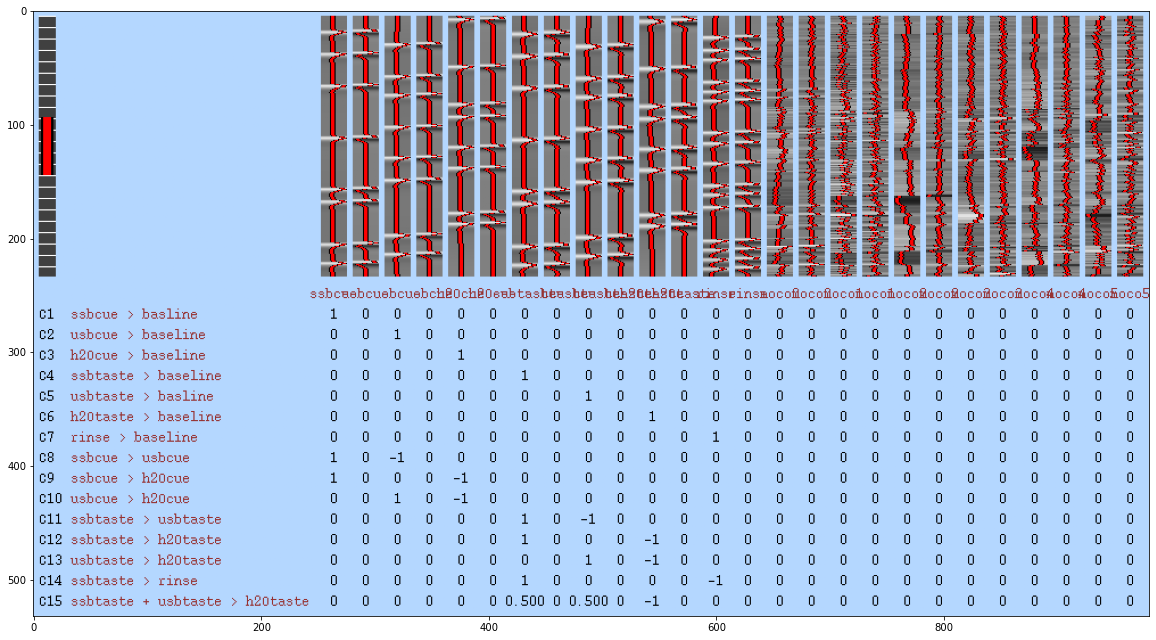

In [141]:
design_sample='/projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-2/fsl_feat1/sub-001_ses-2_task-training_run-2.feat/design.png'

print('[INFO] design (.png) file taken from file: \n', 
      design_sample)


img = mpimg.imread(design_sample)
imgplot = plt.imshow(img)
plt.show()



In [142]:
feat1_dfs=feat1_qc()

[INFO] 579 ses-1 run folders found.
[INFO] 406 ses-2 run folders found.


In [143]:
s1_feat1_df=feat1_dfs[0][1]
s2_feat1_df=feat1_dfs[1][1]

In [144]:
s1_feat1_df.head()

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-001,0.058060,0.496957,0.025917,0.518592,0.112477,0.597372,-0.113098,0.528711,4
sub-002,NaN,NaN,0.017653,0.408110,-0.069755,0.463544,-0.017831,0.571133,3
sub-003,0.039313,0.535803,0.042738,0.558736,0.108834,0.572889,0.101243,0.583815,4
sub-004,-0.101026,0.636548,0.237793,0.746915,0.074372,0.421301,NaN,NaN,3
sub-005,0.189450,0.729622,0.003350,0.526322,0.021617,0.582914,0.026376,0.521771,4


In [145]:
s2_feat1_df.head()

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-001,0.077487,0.552250,0.025917,0.518592,-0.069194,0.538014,0.040417,0.505749,3
sub-002,0.060267,0.544122,0.017653,0.408110,-0.069755,0.463544,-0.017831,0.571133,1
sub-003,0.039313,0.535803,0.042738,0.558736,0.108834,0.572889,0.101243,0.583815,0
sub-004,0.004448,0.458207,0.237793,0.746915,0.074372,0.421301,0.033080,0.504488,2
sub-005,0.068371,0.431774,0.003350,0.526322,0.021617,0.582914,-0.016997,0.430959,2


In [146]:
s1_feat1_bad_df = s1_feat1_df[(s1_feat1_df.T == 0).any()]
s2_feat1_bad_df = s2_feat1_df[(s2_feat1_df.T == 0).any()]



In [147]:
display(s1_feat1_bad_df)

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [148]:
display(s2_feat1_bad_df)

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-003,0.039313,0.535803,0.042738,0.558736,0.108834,0.572889,0.101243,0.583815,0
sub-012,-0.033296,0.532530,0.130198,0.599928,0.123569,0.541397,0.019447,0.529666,0
sub-016,-0.039448,0.514719,0.047446,0.488554,0.085792,0.498311,0.069784,0.561728,0
sub-018,-0.015295,0.459766,0.058127,0.642083,0.141345,0.583435,0.009892,0.509376,0
sub-024,-0.004092,0.447093,-0.021899,0.483544,0.121707,0.516107,-0.178815,0.597990,0
sub-025,0.170477,0.629283,0.020963,0.548274,0.050056,0.583832,0.016039,0.523681,0
sub-026,-0.006597,0.526167,-0.058685,0.460199,-0.045198,0.548519,-0.028242,0.483019,0
sub-027,-0.073189,0.635884,0.067475,0.497923,0.046587,0.495774,-0.032813,0.515691,0
sub-028,0.076035,0.507775,0.041585,0.536067,0.026387,0.569270,0.093521,0.525812,0
sub-030,0.179346,0.612692,0.092669,0.535538,0.074085,0.560408,-0.003010,0.578265,0


In [149]:
import openpyxl

In [150]:
# make reports
def write_feat1_report():
    output_path=os.path.join('/projects/niblab/experiments/bbx/data/quality_analysis/reports')
    outfile="bbx_preprocessing_report.xlsx"
    report_path=os.path.join(output_path,outfile)


    writer = pd.ExcelWriter(report_path, engine='openpyxl')

    if os.path.exists(report_path):
        book = openpyxl.load_workbook(report_path)
        writer.book = book

    s1_feat1_df.to_excel(writer, sheet_name='feat1')
    writer.save()
    writer.close()



In [151]:
write_feat1_report() #write report

In [152]:
# session1 dataframe 
s1_feat1_df.tail()

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-166,0.149184,0.578036,-0.102465,0.568828,0.043126,0.536462,0.017281,0.531648,4
sub-167,-0.052531,0.416007,0.104545,0.517077,-0.039071,0.484028,-0.092822,0.512050,4
sub-168,0.073844,0.670975,0.075086,0.607207,0.103516,0.614694,0.088961,0.669561,4
sub-169,0.026228,0.542299,0.023964,0.485225,0.041078,0.546674,0.016181,0.516702,4
sub-170,-0.007131,0.466157,-0.110091,0.569927,0.077623,0.495821,0.039700,0.501013,4


In [153]:
s1_feat1_df[pd.isnull(s1_feat1_df).any(axis=1)]

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-002,NaN,NaN,0.017653,0.408110,-0.069755,0.463544,-0.017831,0.571133,3
sub-004,-0.101026,0.636548,0.237793,0.746915,0.074372,0.421301,NaN,NaN,3
sub-042,-0.111181,0.572966,NaN,NaN,0.144583,0.519646,0.004246,0.564308,3
sub-048,NaN,NaN,0.048706,0.497673,-0.049904,0.499049,0.026600,0.576425,3
sub-052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-060,NaN,NaN,0.053533,0.518561,0.020665,0.443002,NaN,NaN,2
sub-073,NaN,NaN,0.060851,0.490683,0.203455,0.605660,-0.010985,0.508591,3
sub-074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-076,NaN,NaN,0.120554,0.526913,0.058018,0.460365,0.130688,0.609239,3
sub-079,0.089863,0.544328,-0.050593,0.531631,0.043579,0.540027,NaN,NaN,3


In [154]:
s2_feat1_df[pd.isnull(s2_feat1_df).any(axis=1)]

,run-4_zstat_mean,run-4_zstat_std,run-1_zstat_mean,run-1_zstat_std,run-2_zstat_mean,run-2_zstat_std,run-3_zstat_mean,run-3_zstat_std,run_ct
sub-042,-0.075222,0.492909,NaN,NaN,0.144583,0.519646,0.010667,0.445736,2
sub-052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-060,NaN,NaN,0.053533,0.518561,0.020665,0.443002,NaN,NaN,0
sub-074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-076,NaN,NaN,0.120554,0.526913,0.058018,0.460365,0.130688,0.609239,0
sub-079,0.089863,0.544328,-0.050593,0.531631,0.043579,0.540027,NaN,NaN,0
sub-094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-117,0.072138,0.521900,NaN,NaN,0.070186,0.570291,-0.014197,0.607519,3
sub-128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
sub-147,NaN,NaN,0.161028,0.664986,0.320057,0.812958,-0.142931,0.470894,0


## Skipping Registration  

When using the FMRIPREP process we skip registration in FSL feat1 because it was already done in the FMRIPREP process. Before running feat2, *we have to modify the feat1 folders slighty to adjust for this registration difference.*

Full run down video: [skipping registration](https://www.youtube.com/watch?v=U3tG7JMEf7M)  
  
* Check for `reg_standard/` folder, delete if it exists.  
Note, this is only created if a feat2 process has been run, should not exist otherwise.  
  
  
* Delete all `.mat` files in the `reg/` folder, replace with identity matrix.  
`cp $FSLDIR/etc/flirtsch/ident.mat reg/ example_func2standard.mat`  
This ensures the data won't be moved at all.    
  

* Make sure the data isn't interpolated again.  
Essentially means, after the movement the voxels still align exactly.  
`cp mean_func.nii.gz reg/standard.nii.gz`  


In [158]:
def skipping_registration(sub_data_path,verbose=False):
    print('[INFO] skipping registration mods')
    
    #print('[INFO] ', sub_data_path )
    
    # Get folders 
    
    # get .feat folders 
    feat_folders=glob.glob(os.path.join(
            sub_data_path, "fsl_feat1/*.feat"))
    
    feat_folders.sort()
    

    # loop through subject feat1 folders
    for feat_folder in feat_folders:
       
        # get .mat files for subject
        mat_files = glob.glob(os.path.join(feat_folder,
               "reg/*.mat"))
        
        # loop through .mat files found 
        for mat_file in mat_files:        
            
            if verbose==True: print("\n[INFO] removing .mat files \n%s"%mat_file)
            
            try:
                pass
                os.remove(mat_file)
            except Exception as e:
                print(e)
              
          
        
        
        # Remove reg_standard directories
        
        #get reg_standard directories for subject
        reg_std_folder = os.path.join(feat_folder, 
                  "reg_standard")# reg_standard/ directories 
        
        
        if os.path.exists(reg_std_folder):
            if verbose==True: print("\n[INFO] removing reg_standard/ directory \n%s"%reg_std_folder)
            
            # remove folder
            try:
                pass
                rmtree(reg_std_folder)
            
            except Exception as e:
                print(e)
        
        
        # Copy identity matrix
        reg_folders = glob.glob(os.path.join(sub_data_path, 
                       "fsl_feat1/*run*.feat/reg"))
        for reg in reg_folders:
            path="%s/example_func2standard.mat"%reg
            copy_mat_cmd='cp $FSLDIR/etc/flirtsch/ident.mat %s'%path
            
            if verbose==True: print("\n[INFO] copying identity matrix \n%s"%copy_mat_cmd)
            
            try:
                pass
                sp.run(copy_mat_cmd, shell=True)
            except Exception as e:
                print(e)
     
                
        # copy mean files 
               
        MEAN_PATH = os.path.join(feat_folder, "mean_func.nii.gz")
        REG_DIR = os.path.join(feat_folder, "reg", "standard.nii.gz")
        #print("[INFO] ", MEAN_PATH)
        #print("[INFO] ", REG_DIR)
        copy_mean_cmd = 'cp %s %s'%(MEAN_PATH, REG_DIR)
        if verbose==True: print("\n[INFO] copying mean file \n%s"%copy_mean_cmd)
        sp.run(copy_mean_cmd, shell=True)
   
    print('[INFO] process complete.')
        
    

Setup method variables:

In [159]:
# variables
base_path='/projects/niblab/experiments/bbx/data/preprocessed' 
task="task-training"
session='ses-2'


Method 1: **running a single subject-**

In [8]:
subject='sub-117'
subject_path=os.path.join(base_path,subject, session)

# call the skipping_registration() method
# subject_path = the preprocessed folder, where feat1 folder is held
# verbose = True, verbose=False by default
skipping_registration(subject_path, True)


[INFO] skipping registration mods

[INFO] removing .mat files 
/projects/niblab/experiments/bbx/data/preprocessed/sub-117/ses-1/fsl_feat1/sub-117_ses-1_task-training_run-2.feat/reg/example_func2standard.mat

[INFO] copying identity matrix 
cp $FSLDIR/etc/flirtsch/ident.mat /projects/niblab/experiments/bbx/data/preprocessed/sub-117/ses-1/fsl_feat1/sub-117_ses-1_task-training_run-3.feat/reg/example_func2standard.mat

[INFO] copying identity matrix 
cp $FSLDIR/etc/flirtsch/ident.mat /projects/niblab/experiments/bbx/data/preprocessed/sub-117/ses-1/fsl_feat1/sub-117_ses-1_task-training_run-2.feat/reg/example_func2standard.mat

[INFO] copying identity matrix 
cp $FSLDIR/etc/flirtsch/ident.mat /projects/niblab/experiments/bbx/data/preprocessed/sub-117/ses-1/fsl_feat1/sub-117_ses-1_task-training_run-4.feat/reg/example_func2standard.mat

[INFO] copying mean file 
cp /projects/niblab/experiments/bbx/data/preprocessed/sub-117/ses-1/fsl_feat1/sub-117_ses-1_task-training_run-2.feat/mean_func.nii.gz

Method 2: **running multiple subjects-**

In [160]:
# set the subject id range
start=1
finish=170


for sub_id in range(start, finish+1):
    # format the input path
    subject="sub-%s"%f'{sub_id:03}'
    subject_path=os.path.join(base_path,subject, session)
    # call the skipping_registration() method
    # subject_path = the preprocessed folder, where feat1 folder is held
    # verbose = True, verbose=False by default
    skipping_registration(subject_path, False) 


[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complete.
[INFO] skipping registration mods
[INFO] process complet

## Feat 2  <a class="anchor" id="feat2"></a>
Running FSL Feat 2  
  
  
Steps:  
* Setup the subject design `.fsf` files  
* Run the subject `.fsf` file, submit batch `.job`  

Feat 2 design `.fsf` setup method-

In [161]:
def setup_feat2(sub_folder, verbose=True, make_dir=False):
    # set variables
    subject = sub_folder.split("/")[-2]
    session = sub_folder.split("/")[-1]
    filename="%s_%s_task-training"%(subject, session)#,today)
    #check for existence of feat2 directory
    feat2_path = os.path.join(sub_folder, "fsl_feat2")
    
    if make_dir==True:
        if os.path.exists(feat2_path):
            if verbose==True: print('[INFO] path %s already exists'%feat2_path)
            pass
        else:
            os.makedirs(feat2_path)
     
    
    # setup variables to fill fsf file
    
    # get feat1 paths
    feat1_path = os.path.join(sub_folder, "fsl_feat1/*.feat")
    feat1_folders = sorted(glob.glob(feat1_path)) 
    feat1_ct=len(feat1_folders)
    if verbose==True: print("[INFO] %s feat1 folders found"%feat1_ct)
    
    if feat1_ct == 4:
        
        design_file="/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat2/design.fsf"
    
    
        # open fsf template file
        with open(os.path.join(design_file), 'r') as infile:
            tempfsf=infile.read()
            # set outpath for fsf OUTPATH variable, by run
            sub_id =  sub_folder.split("/")[-2]
            outpath = os.path.join(feat2_path, 
                   '%s'%(filename))
            #print('[INFO] outpath: ', outpath)
            tempfsf = tempfsf.replace("OUTPUT", outpath)

            # fill in feat1 folder paths
            for index,feat_path in enumerate(feat1_folders):
                feat_id = "run%s"%(index+1)
                tempfsf = tempfsf.replace(feat_id, feat_path)

            # view fsf file 
            #print("\n\n", tempfsf)

            # setup outfile path for fsf file
            OUTFILE_PATH = os.path.join(feat2_path, "%s.fsf"%(filename))
            if verbose ==True: print("[INFO] writing to file: ", OUTFILE_PATH)
            # write the new fsf to the fsf file path
            with open(OUTFILE_PATH, "w") as outfile:
                outfile.write(tempfsf)
            outfile.close()
        infile.close()
        
    elif feat1_ct==3:
        design_file="/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat2/design_3runs.fsf"
    
    
        # open fsf template file
        with open(os.path.join(design_file), 'r') as infile:
            tempfsf=infile.read()
            # set outpath for fsf OUTPATH variable, by run
            sub_id =  sub_folder.split("/")[-2]
            outpath = os.path.join(feat2_path, 
                   '%s'%(filename))
            #print('[INFO] outpath: ', outpath)
            tempfsf = tempfsf.replace("OUTPUT", outpath)

            # fill in feat1 folder paths
            for index,feat_path in enumerate(feat1_folders):
                feat_id = "run%s"%(index+1)
                tempfsf = tempfsf.replace(feat_id, feat_path)

            # view fsf file 
            #print("\n\n", tempfsf)

            # setup outfile path for fsf file
            OUTFILE_PATH = os.path.join(feat2_path, "%s.fsf"%(filename))
            if verbose ==True: print("[INFO] writing to file: ", OUTFILE_PATH)
            # write the new fsf to the fsf file path
            with open(OUTFILE_PATH, "w") as outfile:
                outfile.write(tempfsf)
            outfile.close()
        infile.close()
    else:
        
        pass

    if verbose==True: print('[INFO] process complete')


In [162]:
# variables
base_path='/projects/niblab/experiments/bbx/data/preprocessed' 
task="task-training"
session='ses-2'


**run single subject-**

In [11]:

subject='sub-117'
subject_path=os.path.join(base_path,subject, session)
setup_feat2(subject_path, verbose=True)




[INFO] 3 feat1 folders found
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/sub-117/ses-1/fsl_feat2/sub-117_ses-1_task-training.fsf
[INFO] process complete


**run multiple subjects-**

In [164]:
# set the subject id range
start=1
finish=170

print('[INFO] writing feat2 fsf files')

for sub_id in range(start, finish+1):
    # format the input path
    subject="sub-%s"%f'{sub_id:03}'
    subject_path=os.path.join(base_path,subject, session)
    # call the skipping_registration() method
    # subject_path = the preprocessed folder, where feat1 folder is held
    # verbose = True, verbose=False by default
    setup_feat2(subject_path, verbose=True)
print('[INFO] process complete')


[INFO] writing feat2 fsf files
[INFO] 4 feat1 folders found
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/sub-001/ses-2/fsl_feat2/sub-001_ses-2_task-training.fsf
[INFO] process complete
[INFO] 4 feat1 folders found
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/sub-002/ses-2/fsl_feat2/sub-002_ses-2_task-training.fsf
[INFO] process complete
[INFO] 0 feat1 folders found
[INFO] process complete
[INFO] 4 feat1 folders found
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/sub-004/ses-2/fsl_feat2/sub-004_ses-2_task-training.fsf
[INFO] process complete
[INFO] 4 feat1 folders found
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/sub-005/ses-2/fsl_feat2/sub-005_ses-2_task-training.fsf
[INFO] process complete
[INFO] 4 feat1 folders found
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/sub-006/ses-2/fsl_feat2/sub-006_ses-2_task-training.fsf
[INFO] process 

### Submit job 

In [168]:
run_bash=True
start="1"
finish="170"
batch_size=100
file_ext="ses-2_task-training.fsf"
session="ses-2"

if run_bash == True:
    bash_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat2'
                             , 'feat2.job')

    
    
    #for session in ['ses-1', 'ses-2']:
    shell_cmd = "sbatch --array={}-{}%{} {} {} {}".format(start, finish, 
                                               batch_size, bash_file, file_ext, session)
    sp.run(shell_cmd, shell=True)
    print('[INFO] submitted: ', shell_cmd)
    
    
    #for sub_num in subject_set:
        #shell_cmd = "sbatch --array={}%1 {}".format(sub_num, bash_file)
        #os.system(shell_cmd)
        #print(shell_cmd)

        
        

[INFO] submitted:  sbatch --array=1-170%100 /projects/niblab/experiments/bbx/code/preprocessing/fsl_feat2/feat2.job ses-2_task-training.fsf ses-2


### Quality Analysis <a class="anchor" id="feat2_qc"></a>

Quality Check Tools  
`fslstats` - report certain summary statistics for an input 3D/4D image. Of particular value is the "robust intensity range" which calculates values similar to the 2% and 98% percentiles, but ensuring that the majority of the intensity range is captured, even for binary images. In addition, it can take an aribitrary mask as input (values need to be greater than 0.5 to be part of the mask) so that statistics are only calculated within the mask and can also generate histogram data.  
`-w : output smallest ROI <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize> containing nonzero voxels`

In [174]:
#get good files ct
s1_subjects_good=[x.split('/')[-4].split("_")[0] for x in glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-1/fsl_feat2/*.gfeat/cope1.feat/stats/cope1.nii.gz')]
session1_feat2=glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-1/fsl_feat2/*.gfeat/cope1.feat/stats/cope1.nii.gz')
s1_subjects_good.sort()                



print('[INFO] %s feat2 folders found.'%len(session1_feat2))                     
print('[INFO] %s subjects found for feat3'%len(s1_subjects_good))
# get feats
session1_feat2=glob.glob(
    '/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-1/fsl_feat2/sub-*.gfeat')



[INFO] 147 feat2 folders found.
[INFO] 147 subjects found for feat3


In [190]:
#get good files ct
s2_subjects_good=[x.split('/')[-4].split("_")[0] for x in glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-2/fsl_feat2/*.gfeat/cope1.feat/stats/cope1.nii.gz')]
session2_feat2=glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-2/fsl_feat2/*.gfeat/cope1.feat/stats/cope1.nii.gz')
s2_subjects_good.sort()                



print('[INFO] %s feat2 folders found.'%len(session2_feat2))                     
print('[INFO] %s subjects found for feat3'%len(s2_subjects_good))
# get feats
session2_feat2=glob.glob(
    '/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-2/fsl_feat2/sub-*.gfeat')



[INFO] 25 feat2 folders found.
[INFO] 25 subjects found for feat3


In [199]:
feat2_dict={}
session2_feat2.sort()

for feat2_folder in session2_feat2:
    
    subject=feat2_folder.split("/")[-4].split("_")[0]
    if subject not in feat2_dict:
        feat2_dict[subject]={}
            
    copes=glob.glob(os.path.join(feat2_folder,"cope*/stats/cope1.nii.gz"))
    copes.sort()
    #print(copes)
    zstats=glob.glob(os.path.join(feat2_folder,"cope*/stats/zstat1.nii.gz"))
    masksum=os.path.join(feat2_folder, 'inputreg/masksum_overlay.png')
    maskunique=os.path.join(feat2_folder, 'inputreg/maskunique_overlay.png')

    #if os.path.exists(masksum):
     #   feat2_dict[subject]['masksum_img']=masksum
    #if os.path.exists(maskunique):
     #   feat2_dict[subject]['maskunique_img']=maskunique
    cope_ct=len(copes)
    feat2_dict[subject]['cope_ct']=cope_ct
    

    
    for zstat in zstats:
        copeID=zstat.split("/")[-3].split(".")[0]
        #print(zstat)
        cmd_out= sp.check_output(["fslstats", zstat, '-m', '-s'])
        cmd_out=cmd_out.decode("utf-8")
        var1=cmd_out.split(" ")[0]
        var2=cmd_out.split(" ")[1]
        feat2_dict[subject]['%s_zstat_mean'%copeID]=var1
        feat2_dict[subject]['%s_zstat_std'%copeID]=var2
    
        
#print(feat2_dict)        
ses2_feat2_df=pd.DataFrame(feat2_dict).T
        
                           

**Stats Cope Report**

In [200]:
display(ses2_feat2_df.head())

,cope_ct,cope2_zstat_mean,cope2_zstat_std,cope3_zstat_mean,cope3_zstat_std,cope4_zstat_mean,cope4_zstat_std,cope5_zstat_mean,cope5_zstat_std,cope6_zstat_mean,...,cope12_zstat_mean,cope12_zstat_std,cope13_zstat_mean,cope13_zstat_std,cope14_zstat_mean,cope14_zstat_std,cope15_zstat_mean,cope15_zstat_std,cope1_zstat_mean,cope1_zstat_std
sub-001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-002,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-004,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-005,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
s2_bad_feat2_df = ses2_feat2_df[pd.isnull(ses2_feat2_df).any(axis=1)]
s2_good_feat2_df = ses2_feat2_df[(ses2_feat2_df.T != 0).all()]


In [204]:
display(s2_good_feat2_df)

,cope_ct,cope2_zstat_mean,cope2_zstat_std,cope3_zstat_mean,cope3_zstat_std,cope4_zstat_mean,cope4_zstat_std,cope5_zstat_mean,cope5_zstat_std,cope6_zstat_mean,...,cope12_zstat_mean,cope12_zstat_std,cope13_zstat_mean,cope13_zstat_std,cope14_zstat_mean,cope14_zstat_std,cope15_zstat_mean,cope15_zstat_std,cope1_zstat_mean,cope1_zstat_std
sub-009,15,0.109257,0.537399,0.026872,0.601332,0.024175,0.603407,-0.021577,0.529281,-0.049902,...,0.051117,0.529117,0.020618,0.496193,0.033709,0.587720,0.041220,0.522635,0.071023,0.608639
sub-011,15,0.056125,0.601606,-0.159773,0.671940,0.282902,0.880265,0.305017,0.902707,0.434278,...,-0.074520,0.506086,-0.069986,0.503607,0.318417,1.000209,-0.081818,0.526529,0.128938,0.629898
sub-015,15,0.018123,0.450560,-0.060651,0.593949,-0.136610,0.645224,-0.053825,0.608207,0.248540,...,-0.288166,0.810004,-0.223209,0.743509,-0.196546,0.735730,-0.289745,0.845193,0.114714,0.515424
sub-019,15,0.246643,0.818704,0.037522,0.577728,-0.079575,0.588723,-0.143701,0.645271,-0.128261,...,0.031615,0.499442,-0.025665,0.476756,-0.019844,0.814736,0.003855,0.493840,0.159032,0.684064
sub-021,15,0.025914,0.557284,0.242106,0.806182,0.098717,0.697111,0.150903,0.814429,0.035358,...,0.058219,0.490796,0.095482,0.555478,-0.032310,0.767210,0.087646,0.538727,0.032321,0.581057
sub-023,15,0.017980,0.487834,0.025920,0.597230,-0.032999,0.553654,-0.113385,0.534421,-0.069160,...,0.021750,0.557185,-0.042599,0.515094,-0.024101,0.698358,-0.011691,0.552610,0.020011,0.510238
sub-037,15,0.074111,0.626038,0.052030,0.613546,0.072944,0.587253,0.053504,0.508903,0.043022,...,0.027934,0.550448,0.012883,0.477092,-0.053829,0.632903,0.023532,0.527763,0.074561,0.741593
sub-039,15,0.088652,0.467780,-0.024521,0.472881,0.017197,0.556442,0.132407,0.556072,0.230305,...,-0.143433,0.562400,-0.052189,0.475229,-0.059162,0.598793,-0.110715,0.515875,0.066796,0.515413
sub-044,15,0.022584,0.557445,0.071481,0.576699,0.086758,0.641704,0.179809,0.703465,0.099785,...,-0.000391,0.445279,0.072576,0.481675,0.071920,0.629124,0.040460,0.456487,0.050655,0.573061
sub-054,15,0.041241,0.559186,-0.156395,0.723800,0.299990,1.049952,0.312292,1.126448,0.427909,...,-0.057175,0.473475,-0.049775,0.493337,0.379673,1.066732,-0.060498,0.499536,0.071191,0.623810


**View Bad Subjects**

In [205]:
display(s2_bad_feat2_df)

,cope_ct,cope2_zstat_mean,cope2_zstat_std,cope3_zstat_mean,cope3_zstat_std,cope4_zstat_mean,cope4_zstat_std,cope5_zstat_mean,cope5_zstat_std,cope6_zstat_mean,...,cope12_zstat_mean,cope12_zstat_std,cope13_zstat_mean,cope13_zstat_std,cope14_zstat_mean,cope14_zstat_std,cope15_zstat_mean,cope15_zstat_std,cope1_zstat_mean,cope1_zstat_std
sub-001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-002,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-004,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-005,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-007,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-008,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-013,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-017,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
print("[INFO] %s subjects for feat3"%len(list(good_feat2_df.index.values)))

[INFO] 145 subjects for feat3


In [138]:
# set dropped subjects
dropped_subjects=[
                "sub-042", "sub-115", "sub-117", "sub-148", "sub-157",
                "sub-151", "sub-164", "sub-168", "sub-169"
                ]

In [139]:
print("[INFO] dropping %s subjects"%len(list(dropped_subjects)))

[INFO] dropping 9 subjects


In [140]:
feat3_subjects=[
                x for x in list(good_feat2_df.index.values)
                if x not in dropped_subjects
               ]

In [141]:
print("[INFO] %s subjects for feat3"%len(feat3_subjects))

[INFO] 137 subjects for feat3


In [119]:
#feat2_df.loc[:, (feat2_df == 0).any()]

**Make Output Reports**

In [118]:
# make reports
output_path=os.path.join('/projects/niblab/experiments/bbx/data/quality_analysis/reports')
outfile="bbx_preprocessing_report_2020-11-10.xlsx"
report_path=os.path.join(output_path,outfile)



writer = pd.ExcelWriter(report_path, engine='openpyxl')

if os.path.exists(report_path):
    book = openpyxl.load_workbook(report_path)
    writer.book = book
    
feat2_df.to_excel(writer, sheet_name='feat2')
writer.save()
writer.close()

In [232]:
len(list(good_feat2_df.index.values))

136

In [233]:
len(list(bad_feat2_df.index.values))

16

In [ ]:
feat2_df.to_csv('/projects/niblab/experiments/bbx/data/quality_analysis/reports/bbx_ses-1_feat2_report_2020-11-13.tsv', sep="\t")


good_feat2_df.to_csv('/projects/niblab/experiments/bbx/data/quality_analysis/reports/bbx_ses-1_feat2_good_report_2020-11-13.tsv', sep="\t")

bad_feat2_df.to_csv('/projects/niblab/experiments/bbx/data/quality_analysis/reports/bbx_ses-1_feat2_bad_report_2020-11-13.tsv', sep="\t")


In [102]:
from IPython.display import SVG, display
from datetime import date
import ipywidgets as widgets
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 159)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#pd.set_option('display.max_rows', 159)
#pd.set_option('display.max_colwidth', -1)

from matplotlib import rcParams
rcParams['axes.titlepad'] = 15

%matplotlib inline 

In [103]:
def display_feat2_widget(subject=list(feat2_df.index.values)[0]):
    cope_ct=feat2_df.loc[subject, 'cope_ct']

    print('[INFO] cope count: ',cope_ct)
    
    #print("[size] 0s found")
    display(feat2_df.loc[subject, :].to_frame().T)
    img1 = mpimg.imread(feat2_df.loc[subject, 'masksum_img'])
    imgplot = plt.imshow(img1)

    plt.show()

In [104]:
# run widget that calls help functions above
w_feat2= widgets.Select(options=list(feat2_df.index.values))
widgets.interactive(display_feat2_widget, subject=w_feat2)

interactive(children=(Select(description='subject', options=('sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-…

## Feat 3 <a class="anchor" id="feat3"></a>

**View Design**

In [24]:


def make_dict(cope_dict,x):
    cope_dict[x] = {}


def make_fsfs(num_of_copes, num_of_input, template_file,
              deriv_dir, cope_dict, dropped_subjects):#, remove_subjects=remove_subjects):

    # loop through copes and make design file for each
    for cope_num in range(1, num_of_copes+1):
        
        # make dictionary
        make_dict(cope_dict, cope_num)
        if cope_num == 1:
            cope_name = 'c%s_ssbcue_%s'%(cope_num,num_of_input)
        elif cope_num == 2:
            cope_name = 'c%s_usbcue_%s'%(cope_num,num_of_input)
        elif cope_num == 3:
            cope_name = 'c%s_h2Ocue_%s'%(cope_num,num_of_input)
        elif cope_num == 4:
            cope_name = 'c%s_ssbtaste_%s'%(cope_num,num_of_input)
        elif cope_num == 5:
            cope_name = 'c%s_usbtaste_%s'%(cope_num,num_of_input)
        elif cope_num == 6:
            cope_name = 'c%s_h2Otaste_%s'%(cope_num,num_of_input)
        elif cope_num == 7:
            cope_name = 'c%s_rinse_%s'%(cope_num,num_of_input)
        elif cope_num == 8:
            cope_name = 'c%s_ssbcue_usbcue_%s'%(cope_num,num_of_input)
        elif cope_num == 9:
            cope_name = 'c%s_ssbcue_h2Ocue_%s'%(cope_num,num_of_input)
        elif cope_num == 10:
            cope_name = 'c%s_usbcue_h2Ocue_%s'%(cope_num,num_of_input)
        elif cope_num == 11:
            cope_name = 'c%s_ssbtaste_usbtaste_%s'%(cope_num,num_of_input)
        elif cope_num == 12:
            cope_name = 'c%s_ssbtaste_h2Otaste_%s'%(cope_num,num_of_input)
        elif cope_num == 13:
            cope_name = 'c%s_usbtaste_h2Otaste_%s'%(cope_num,num_of_input)
        elif cope_num == 14:
            cope_name = 'c%s_ssbtaste_rinse_%s'%(cope_num,num_of_input)
        elif cope_num == 15:
            cope_name = 'c%s_usbcue_ssbcue_%s'%(cope_num,num_of_input)
        else: 
            cope_name=cope
        """elif cope_num == 16:
            cope_name = 'c%s_ssbtaste+usbtaste_h2Otaste%s'%(cope_num,num_of_input)
        elif cope_num == 17:
            cope_name = 'c%s_usbtaste_ssbtaste_%s'%(cope_num,num_of_input)
        elif cope_num == 18:
            cope_name = 'c%s_rinse_%s'%(cope_num,num_of_input)
        elif cope_num == 19:
            cope_name = 'c%s_ssbtaste_rinse_%s'%(cope_num,num_of_input)
        elif cope_num == 20: 
            cope_name = 'c%s_usbtaste_rinse_%s'%(cope_num,num_of_input)"""
        
        
        session = 'ses-1'

        #OUTPUTDIR = os.path.join(deriv_dir, 'group_ana/cope%s_ses-1'%cope_num)
        OUTPUTDIR = os.path.join('/projects/niblab/experiments/bbx/data/fsl_feat3/%s/%s_%s_task-training'%(session,cope_name, session))
        
        
        
        COPES = glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/sub-*',
                                       session, 'fsl_feat2/sub-*_ses-1_task-training.gfeat/cope%s.feat'%cope_num))
        COPES = [
                x for x in COPES
                if x.split("/")[-5] not in dropped_subjects
                ]

        #print("[INFO]REPLACING 'OUTPUT' > %s"%OUTPUTDIR)
        #print("RUNNING ON SESSION ", sess )
        #COPES = glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/sub-*',
         #                              session,'fsl_feat2/sub-*task-training*.gfeat/cope%s.feat'%cope_num))
    
        
        print("[INFO] %s subjects found."%len(COPES))
        # fill dictionary
        for x,cope in enumerate(COPES):
            count=int(x)+1
            #print(count)
            if count > 9:
                INPUTX = "INPUT_%i"%(count)
            else:
                INPUTX = "INPUT%i"%(count)
            cope_dict[cope_num][INPUTX] = cope
            
            #print("%s : \t%s"%(INPUTX,cope))
        #print(cope_dict)
        
        # open and fill template file
        with open(template_file, 'r') as infile:
            tempfsf=infile.read()
            tempfsf = tempfsf.replace("OUTPUT", OUTPUTDIR)
            for input_title in sorted(cope_dict[cope_num]):
                input_ = cope_dict[cope_num][input_title]
                #print("\nTITLE: \t{} \n\nINPUT: \t{}".format(input_title,input_))
                input_match = re.compile(r"\b%s\b"%(input_title))
                #print(input_match)
                tempfsf = re.sub(r"\b%s\b"%(input_title), input_, tempfsf)
                tempfsf = tempfsf.replace("%s"%input_match, input_)
            OUTFILE_PATH = os.path.join('/projects/niblab/experiments/bbx/data/fsl_feat3/ses-1/%s_ses-1_%s.gfeat.fsf'%(cope_name, 'task-training'))
            
            #print(tempfsf)
            with open(OUTFILE_PATH, 'w') as outfile:
                #print("[INFO] Writing output file: ", OUTFILE_PATH)
                outfile.write(tempfsf)
            outfile.close()
        infile.close()
    print("[INFO] Complete. ")


In [34]:
# get subject count of cope1 available

COPES = glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/sub-*',
                   "ses-1", 'fsl_feat2/sub-*_ses-1_task-training.gfeat/cope1.feat'))
subject_list=[x.split("/")[-5] for x in COPES]
subject_list.sort()

In [35]:
len(subject_list)

146

In [36]:
subject_list[-4:]

['sub-167', 'sub-168', 'sub-169', 'sub-170']

In [38]:
COPES = [
        x for x in COPES
        if x.split("/")[-5] not in dropped_subjects
        ]

subject_list=[x.split("/")[-5] for x in COPES]
subject_list.sort()

In [40]:
len(dropped_subjects)

22

In [39]:
len(subject_list)

125

In [ ]:
#subject_list[:75]



In [41]:
def main():
    # SET OUR RELEVANT PATHS
    deriv_dir = "/projects/niblab/experiments/bbx/data/preprocessed"
    #cope_dict[x] = {}
    
    template_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat3/design3_125.fsf')
    
    # set dropped subjects
    dropped_subjects=[ 'sub-073', 'sub-099', "sub-115",
    "sub-131", "sub-137", "sub-138", "sub-140", "sub-141", 
    "sub-142", "sub-143", "sub-147", "sub-151", "sub-152", 
    "sub-153", "sub-154", "sub-156", "sub-157", "sub-153",
    "sub-164", "sub-168", "sub-169", "sub-170"
    ]
    # get the number of cope files to make (# of copes)
    num_of_copes = 15
    num_of_input = 125
    cope_dict = {}
    make_fsfs(num_of_copes, num_of_input, template_file, deriv_dir, cope_dict, dropped_subjects)



In [42]:
main()

[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] 125 subjects found.
[INFO] Complete. 


### Run `.fsf` files

In [26]:
fsf_files=glob.glob( 
    '/projects/niblab/experiments/bbx/data/fsl_feat3/ses-1/*.fsf')
print("[INFO] {} cope fsf files found.".format(len(fsf_files)))

[INFO] 15 cope fsf files found.


In [27]:
from multiprocessing import Pool

def run_command(fsf):
    feat_cmd="Feat {} &".format(fsf)
    #subprocess.cal(feat_cmd, shell=True)
    #print("[INFO] submitted command: \n> %s"%feat_cmd)
    p = sp.Popen(["feat", fsf, "&"], stdout=sp.PIPE, stderr=sp.PIPE, universal_newlines=True)

    output, errors = p.communicate()
    
    
print("[INFO] submitting feat 3 batch job")
pool = Pool()
pool.map(run_command, fsf_files)
print("[INFO] process complete.")



[INFO] submitting feat 3 batch job
[INFO] process complete.


**Quality Check**

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display
from IPython.html.widgets import interactive
plt.rcParams["figure.figsize"] = (40,20)

In [29]:
COPE_FOLDERS=glob.glob( 
    '/projects/niblab/experiments/bbx/data/fsl_feat3/ses-1/*.gfeat')
print("[INFO] {} cope folders found.".format(len(COPE_FOLDERS)))


data_dict={}

for folder in sorted(COPE_FOLDERS):
    
    cope_name=folder.split("/")[-1].split(".")[0]
    #print("[INFO] cope: %s"%cope_name)
    
    # get threshold png file for each cope
    zstat_img = os.path.join(folder, 'cope1.feat/rendered_thresh_zstat1.png')
    #print("[INFO] zstat file path: %s"%zstat_img)
    
    cluster_txt = os.path.join(folder, 'cope1.feat/cluster_zstat1_std.txt')
    
    
    if cope_name not in data_dict:
        data_dict[cope_name] = {}
    
    data_dict[cope_name]['zstat_img'] = zstat_img
    data_dict[cope_name]['folder_path'] = folder
    data_dict[cope_name]['cluster_txt'] = cluster_txt
    
    

[INFO] 15 cope folders found.


In [30]:
copes=list(data_dict.keys())
len(copes)

15

In [31]:
def plot(x=copes[0]):
    img=data_dict[x]['zstat_img']
    path=data_dict[x]['folder_path']
    cluster_txt = data_dict[x]['cluster_txt']
    
    print("\n[INFO] SHOWING THRESHOLDED ZSTAT IMAGE FOR COPE: \n%s"%x)
    print("[INFO] RENCI FOLDER PATH: \n%s \n\n"%path)
    
    cluster_data=pd.read_csv(cluster_txt, sep="\t")
    display(cluster_data)
    
    img = mpimg.imread(img)
    plt.imshow(img)
    plt.show()


w = widgets.Select(options=copes)

interactive(plot, x=w)


interactive(children=(Select(description='x', options=('c10_usbcue_h2Ocue_137_ses-1_task-training', 'c11_ssbta…

In [48]:
from shutil import copy2

**Copy niftis**

In [ ]:
niftis=glob.glob("/projects/niblab/experiments/bbx/data/fsl_feat3/ses-1/c*.gfeat/cope1.feat/rendered_thresh_zstat1.png")

pngs.sort()



In [49]:
pngs=glob.glob("/projects/niblab/experiments/bbx/data/fsl_feat3/ses-1/c*.gfeat/cope1.feat/rendered_thresh_zstat1.png")

pngs.sort()



In [50]:
for png in pngs:
    cope_id=png.split("/")[-3].split(".")[0]
    newfile=cope_id+"_rendered_thresh_zstat.png"
    newpath=os.path.join('/projects/niblab/experiments/bbx/data/quality_analysis/feat3_pngs',
                         newfile)
    
   
    copy2(png, newpath)
print("[INFO] completed.") 

[INFO] completed.
